# <center> Traveling Salesman Problem (TSP)

## 1. Introduction.

### 1.1 Introduction to problem.

The traveling salesman problem (TSP) is an optimization problem involving finding the minimum Hamiltonian cycle in a complete weighted graph. The goal is to find the shortest path connecting all vertices, starting and ending at the same point. TSP belongs to the class of NP-hard problems, i.e. those whose solution is at least as difficult as solving any problem from the NP class (the entire NP class). Vertices in a graph are considered as cities and their edges as distances between them.

### 1.2 Representation.

I will use the concept of adjacency matrix to represent the cities and the distances between them. I construct a matrix that represents distances between cities i and j so that element $a_{ij}$ and $a_{ji}$ is the distance between those two cities.
When i = j, $a_{ii}$ equals to zero, since the distance from city i to itself is trivially zero.

### 1.3 Selecting small, medium and large inputs.

#### All needed imports.

In [12]:
import numpy as np
import random
import math 
import time
import pygad
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

#### Auxiliary functions for creating inputs.

In [13]:
def create_coordinates(vertex_num, a, b):
    """
    Given number of vertices in graph this fuction creates list of coordinates in given range.

    Inputs
    ------
    vertex_num: int
        number of verticles in graph
    a: int
        starting range of coordinate
    b: int
        ending range of coordinate 

    Returns
    -------
    coordinates: list of tuples
        list of coordinates in graph
    """
    coordinates = []
    for i in range(vertex_num):
        x = random.randrange(a, b + 1)
        y = random.randrange(a, b + 1)
        coordinates.append((x,y))
    return coordinates

In [14]:
def calculate_distance(vertex1,vertex2):
    """
    Given two verticles of graph calculates euclidean distance between them.
    
    Inputs
    ------
    vertex1: tuple
        coordinates of first chosen vertex in graph
    vertex2: tuple
        coordinates of second chosen vertex in graph
    Returns
    -------
    float
    The computed distance
        distance between two verticles
    """
    return (math.sqrt((vertex1[0]-vertex2[0])**2+(vertex1[1]-vertex2[1])**2))

In [15]:
def create_empty_matrix(size): 
    """
    Given desired size this function creates empty square matrix.
    
    Inputs
    ------
    size: int
        number of rows and columns in matrix

    Returns
    -------
    matrix: list of lists
        created empty square matrix
    """
    matrix = []
    for i in range(size):
        row = []
        for j in range(size):
            row.append(0)
        matrix.append(row)
    return matrix

In [16]:
def create_matrix(points):
    """
    Given list of coordinates creates matrix where element aij and aji corresponds to distance between vertex i and vertex j.
    When i equals to j then element aij equals to zero.
    
    Inputs
    ------
    points: list of tuples
        list of coordinates in graph

    Returns
    -------
    list of lists
        distance matrix where each element corresponds to the distance between verticles
    """
    matrix = create_empty_matrix(len(points))
    for i in range(len(points)):
        for j in range(i+1,len(points)):
            distance = calculate_distance(points[i], points[j])
            matrix[i][j]= distance
            matrix[j][i] = distance
    return matrix

### 1.3. Genetic algorithm model.

#### 1.3.1 Chromosome representation.

A chromosome is a list of vertices indexes in order they were visited. Its length is equal to the number of vertices. Genes in a chromosome are in range from 0 to vertex-1 (ie, gene 1 means visiting the second vertex).

#### 1.3.2 Crossover.

When crossing parents, it could happen that after gene exchange, children will contain duplicate genes, which is illegal in the TSP problem (each vertex should be visited only once). To prevent this, I set the allow_duplicate_genes parameter to False in the genetic algorithm call. When the duplicate gene appears in chromosome it is replaced with random number from defined gene_space.

#### 1.3.3 Mutation.

A similar problem arises in the case of mutations, also after replacing a gene with another, a duplicate may appear in the chromosome. The solution is to use other mutation operators such as "swap" or "inversion". The "swap" type of mutation swaps the places of genes from the same chromosome, while the "inversion" type reverses the order of a chromosome fragment. I chose the "inversion" type of mutation in my solution as it performed better for my graphs.

#### 1.3.4 Type of parents selection.

Tournament selection is a method of parent selection, which involves selecting parents by holding a tournament among a few individuals chosen randomly from the population. The individuals with the best fitness value in the tournament are chosen as parents for the next generation. I chose this type of selection because after few tests I decided that I has been giving the better results.

#### 1.3.5 Fitness function.

In [17]:
def fitness_function(solution, solution_idx):
    """
    Given soulution as indexes in the order of visiting the vertices this function counts fitness 
    so that the best fitness is achieved when the shortest distance is found.
    
    Inputs
    ------
    soulution: list of floats
        indexes in the order of visiting the vertices

    Returns
    -------
     (-1)*distance: float
        multiplies distance by (-1) because when the result of fitness function is greater than the other 
        then solution is considered as a better one. 
        Without that multiplication solutions with greater distance value would be cosidered as better.
    """
    sol = [int(x) for x in solution]
    distance = 0
    for i in range(len(sol)-1):
        distance += graph[sol[i]][sol[i+1]]
        if i == (len(sol)-2):
            distance += graph[sol[i+1]][sol[0]]
    return (-1)*distance

#### Functions for genetic algorithm.

In [18]:
def perform_genetic(graph):
    """
    Given matrix of distances between verticles performs genetic algorithm with parameters adjusted to size of graph.
    
    Inputs
    ------
    graph: list of lists
        matrix with distances between verticles

    Returns
    -------
     solution: list of floats
        order of visited coordinates given by genetic algorithm
    solution_fitness: float
        the best fitness value found by genetic algorithm
    gen_time: float
        time of genetic algorithm
    """
    
    gene_space = [*range(0, len(graph[0]), 1)] #range of gene_space is from 0 to length(graph)-1
    num_genes = len(gene_space)
    mutation_type = "inversion"
    crossover_type = "single_point"
    parent_selection_type = "tournament"
    
    if len(graph[0]) == 5:
        sol_per_pop = 80 
        #how many parents we choose to "multiplicate" (about 50% of population)
        num_parents_mating = 40
        num_generations = 20 
        keep_parents = 2 #5%
        #1/ length of chromosome -> 1/5 = 0.2% so 20% is a good choice
        mutation_percent_genes = 20 
        
    elif len(graph[0]) == 10:
        sol_per_pop = 100 
        num_parents_mating = 50
        num_generations = 100 
        keep_parents = 4 #8%
        #1/ length of chromosome -> 1/10 = 0.1 so 11% is a good choice
        mutation_percent_genes = 11 
    
    elif len(graph[0]) == 15:
        sol_per_pop = 100 
        num_parents_mating = 50
        num_generations = 300
        keep_parents = 4 #8%
        #1/ length of chromosome -> 1/15 = 0.066 so 7% is a good choice
        mutation_percent_genes = 7
    
    else:
        print("Not valid size of graph.")
    
    start = time.time() 
    ga_instance = pygad.GA(gene_space=gene_space,
                           num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           allow_duplicate_genes = False)

    ga_instance.run()
    end = time.time()
    gen_time = end - start
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    print("Parameters of best solution : {solution}".format(solution=solution))
    print("Fitness of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
    ga_instance.plot_fitness()
    
    return solution, solution_fitness, gen_time

In [19]:
def draw_path_genetic(solution,coords):
    """
    Given solution found by genetic algorithm and coords of graph this function returns solution represented by 
    visited coordinates and draws the path on plot.
    
    Inputs
    ------
    solution: list of floats
        order in which the coordinates were visited
    coords: list of tuples
        coordinates of graph

    Returns
    -------
    output_way: list of tuples
        visited coordinates in order calculated by genetic algorithm
    """
    sol = [int(x) for x in solution]
    start_vertex = sol[0]
    output_way = []
    for i in sol:
        output_way.append(coords[i])
    output_way.append(coords[start_vertex])
    x = []
    y = []
    for c in output_way:
        x.append(c[0])
        y.append(c[1])

    plt.plot(x, y, '-o')
    plt.title("Best path found by genetic algorithm: ")
    plt.ylabel("$y$")
    plt.xlabel("$x$")
    plt.show()
    
    return output_way

#### 1.3.5 Small inputs.

To create all inputs I used functions defined at the beginning of notebook as create_coordinates, calculate_distance, create_empty_matrix, create_matrix.
Firstly I created list of random coordinates which are the verticles of graphs (the chosen list of verticles is already assigned to variable). Then I calculated distance between all coordinates and put it into matrix that will represent one graph.

- first small graph

In [20]:
#create_coordinates(5, 1, 100)

In [21]:
coords_1 = [(70, 19), (58, 15), (5, 18), (25, 65), (61, 77)]

In [22]:
graph = create_matrix(coords_1)

In [23]:
graphs_small = [] #this will be the list of small graphs
graphs_small.append(graph)

Parameters of best solution : [2. 3. 4. 0. 1.]
Fitness of the best solution = -213.45377384244733


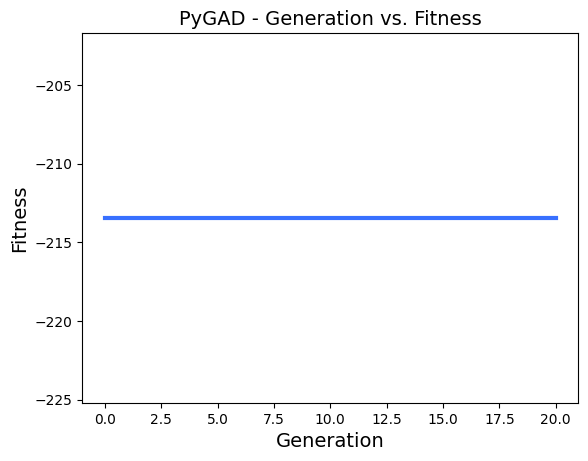

In [24]:
solution, solution_fitness,my_time = perform_genetic(graph)

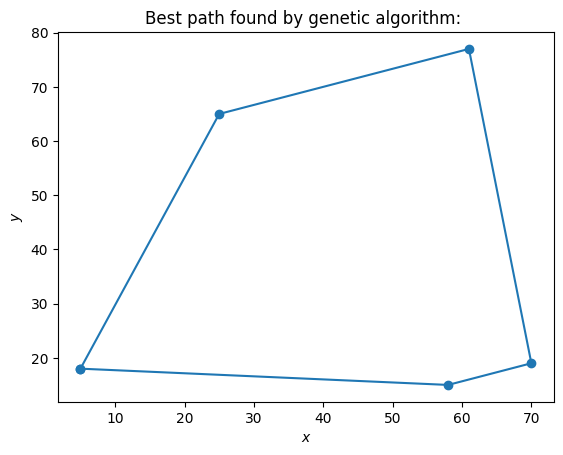

In [25]:
output_way = draw_path_genetic(solution,coords_1)

In [26]:
output_way #visited coordinates of the best solution

[(5, 18), (25, 65), (61, 77), (70, 19), (58, 15), (5, 18)]

- second small graph

In [27]:
#create_coordinates(5, 1, 100)

In [28]:
coords_2 = [(34, 20), (52, 41), (79, 15), (40, 61), (53, 33)]

In [29]:
graph = create_matrix(coords_2)

In [30]:
graphs_small.append(graph)

Parameters of best solution : [4. 2. 0. 3. 1.]
Fitness of the best solution = -149.72246633025193


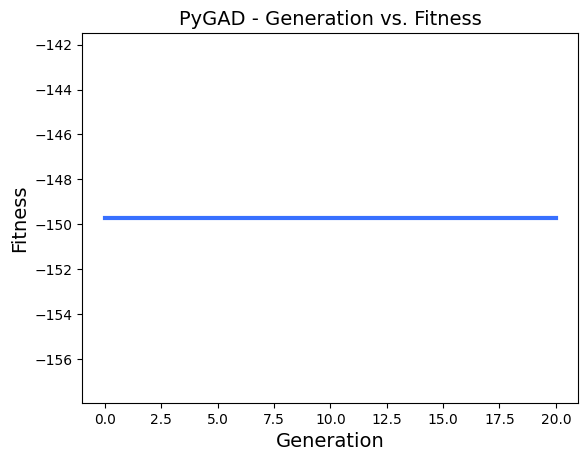

In [31]:
solution, solution_fitness,my_time = perform_genetic(graph)

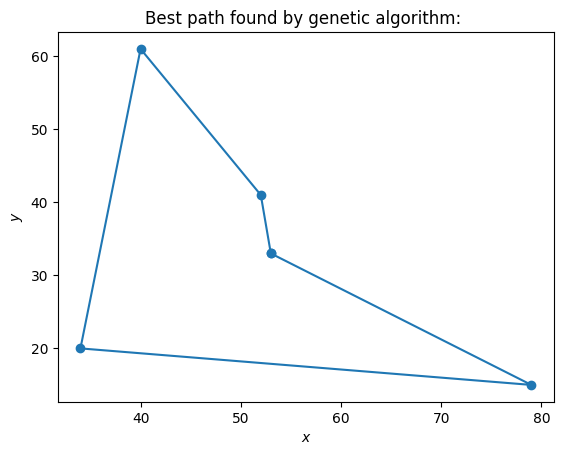

In [32]:
output_way = draw_path_genetic(solution,coords_2)

In [33]:
output_way #visited coordinates of the best solution

[(53, 33), (79, 15), (34, 20), (40, 61), (52, 41), (53, 33)]

- third small graph

In [34]:
#create_coordinates(5, 1, 100)

In [35]:
coords_3 = [(5, 24), (74, 85), (99, 84), (6, 49), (56, 19)]

In [36]:
graph = create_matrix(coords_3)

In [37]:
graphs_small.append(graph)

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


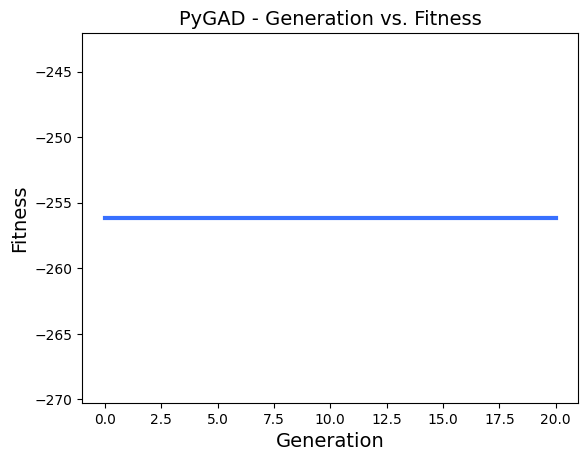

In [38]:
solution, solution_fitness, my_time = perform_genetic(graph)

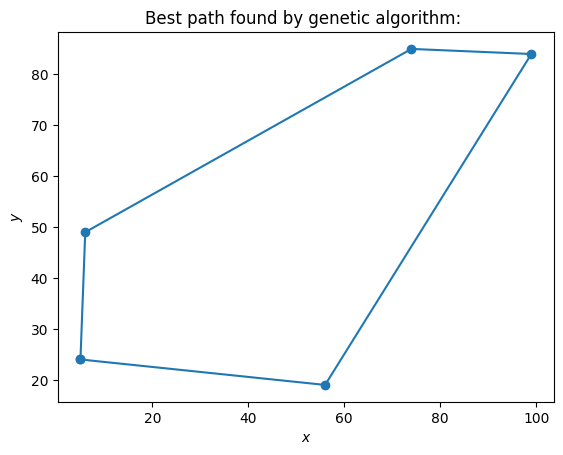

In [39]:
output_way = draw_path_genetic(solution,coords_3)

In [40]:
output_way #visited coordinates of the best solution

[(5, 24), (6, 49), (74, 85), (99, 84), (56, 19), (5, 24)]

#### conclusions:

For graphs with five verticles genetic algorithm finds the solution very fast and it seems that it's sure about it being the best one.

#### 1.3.6 Medium inputs.

- first medium input

In [41]:
#create_coordinates(10, 1, 100)

In [42]:
coords_1 = [(26, 87), (9, 93), (14, 14), (10, 68), (99, 38), (30, 72), (87, 7), (70, 47), (21, 80), (38, 90)]

In [43]:
graph = create_matrix(coords_1)

In [44]:
graphs_medium = [] #this will be the list of medium graphs
graphs_medium.append(graph)

Parameters of best solution : [1. 3. 2. 6. 4. 7. 5. 9. 0. 8.]
Fitness of the best solution = -321.6398485576058


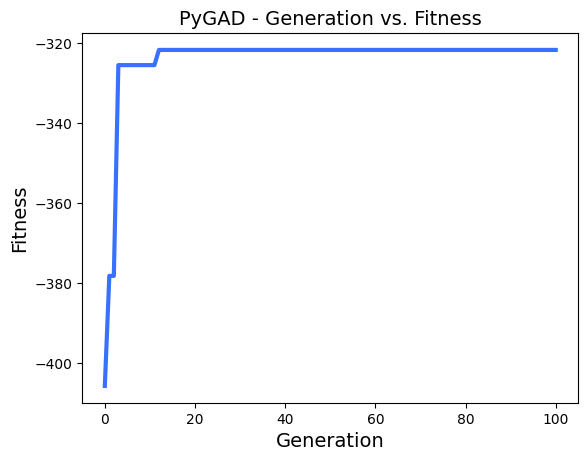

In [45]:
solution, solution_fitness,my_time = perform_genetic(graph)

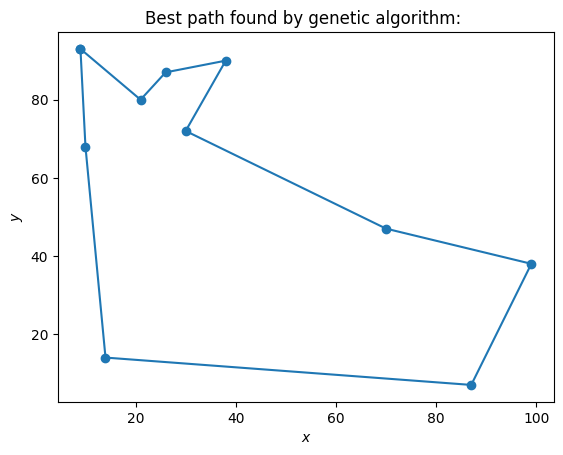

In [46]:
output_way = draw_path_genetic(solution,coords_1)

- second medium input

In [47]:
#create_coordinates(10, 1, 100)

In [48]:
coords_2 = [(79, 36), (90, 64), (53, 88), (20, 48), (35, 57), (4, 94), (100, 98), (23, 56), (30, 11), (35, 94)]

In [49]:
graph = create_matrix(coords_2)

In [50]:
graphs_medium.append(graph)

Parameters of best solution : [8. 0. 1. 6. 2. 9. 5. 4. 7. 3.]
Fitness of the best solution = -325.74132709433985


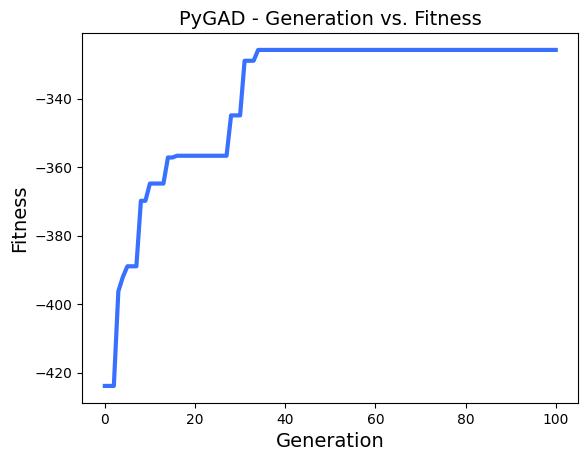

In [51]:
solution, solution_fitness, my_time = perform_genetic(graph)

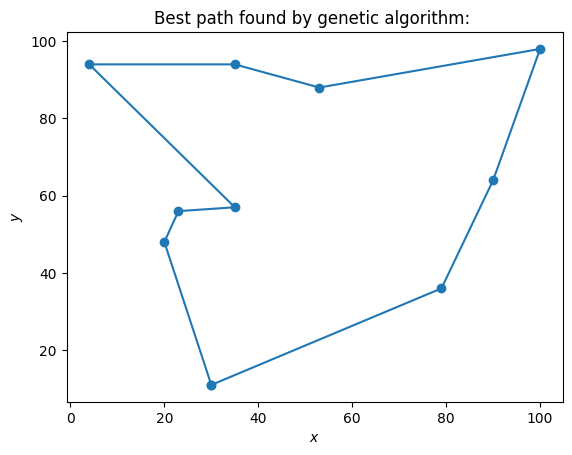

In [52]:
output_way = draw_path_genetic(solution,coords_2)

- third medium input

In [53]:
#create_coordinates(10, 1, 100)

In [54]:
coords_3 = [(20, 85), (14, 68), (3, 88), (15, 96), (92, 12), (100, 39), (88, 72), (80, 79), (61, 81), (48, 86)]

In [55]:
graph = create_matrix(coords_3)

In [56]:
graphs_medium.append(graph)

Parameters of best solution : [8. 7. 6. 5. 4. 1. 2. 3. 0. 9.]
Fitness of the best solution = -280.3072206992613


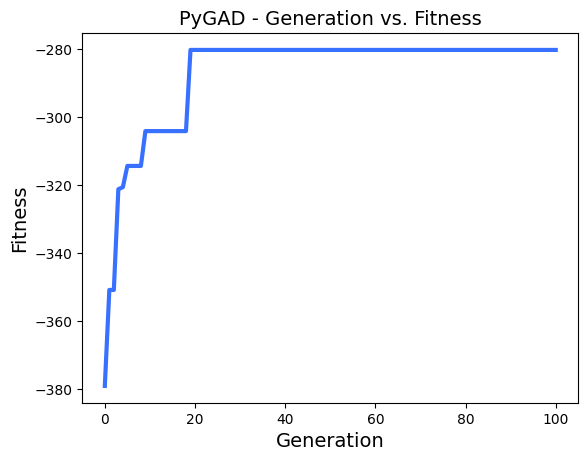

In [57]:
solution, solution_fitness, my_time = perform_genetic(graph)

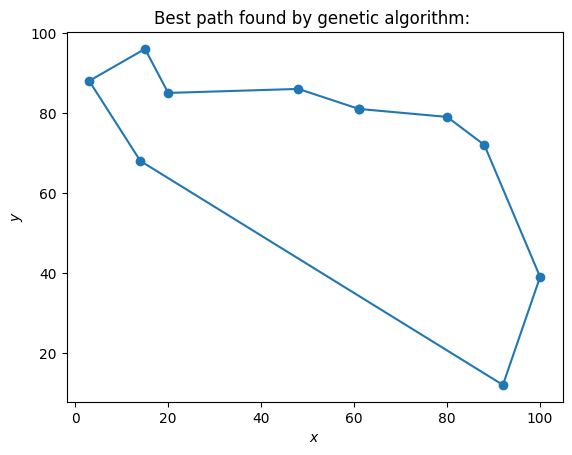

In [58]:
output_way = draw_path_genetic(solution,coords_3)

#### conclusions:

When it comes to medium graphs genetic algorithm was giving various answers but after doing some tests I think that solutions -321.63... for first graph,-325.74... for the second and -280.30... for third one are the best that I managed to achieve. However, because TSP is a NP-hard problem I can't be sure that thease are the best ones.  


#### 1.3.7 Large inputs.

- first large input

In [59]:
#create_coordinates(15, 1, 100)

In [60]:
coords_1 = [(100, 37), (96, 97), (7, 72), (69, 63), (74, 68), (23, 12), (20, 19), (23, 36), (100, 7), (22, 97), (43, 39), (59, 47), (34, 46), (24, 35), (75, 19)]

In [61]:
graph = create_matrix(coords_1)

In [62]:
graphs_large = [] #this will be the list with large graphs
graphs_large.append(graph)

Parameters of best solution : [ 9.  2. 12.  7. 13.  6.  5. 10. 11. 14.  8.  0.  3.  4.  1.]
Fitness of the best solution = -406.4270602205307


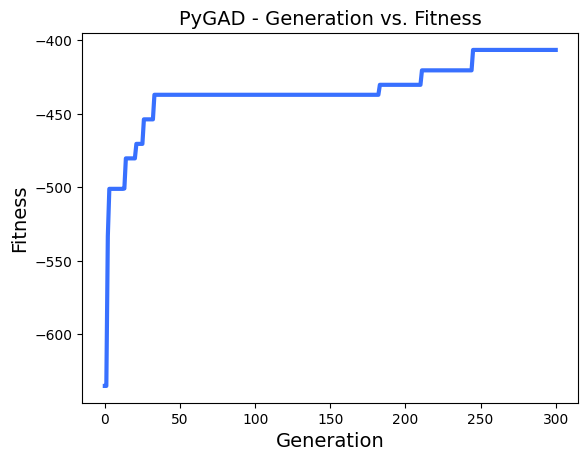

In [71]:
solution, solution_fitness, my_time = perform_genetic(graph)

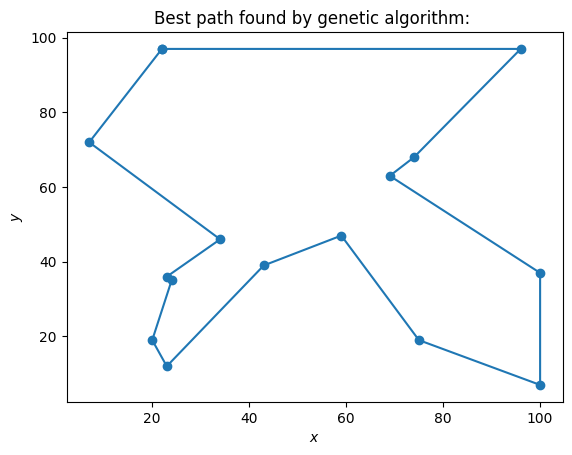

In [72]:
output_way = draw_path_genetic(solution,coords_1)

- second large input

In [73]:
#create_coordinates(15, 1, 100)

In [74]:
coords_2 = [(2, 83), (48, 26), (25, 3), (51, 7), (18, 29), (50, 18), (22, 9), (57, 63), (6, 95), (33, 45), (30, 77), (39, 7), (22, 81), (87, 98), (62, 80)]

In [75]:
graph = create_matrix(coords_2)

In [76]:
graphs_large.append(graph)

Parameters of best solution : [ 4.  9.  0.  8. 12. 10. 14. 13.  7.  1.  5.  3. 11.  2.  6.]
Fitness of the best solution = -333.9050085276734


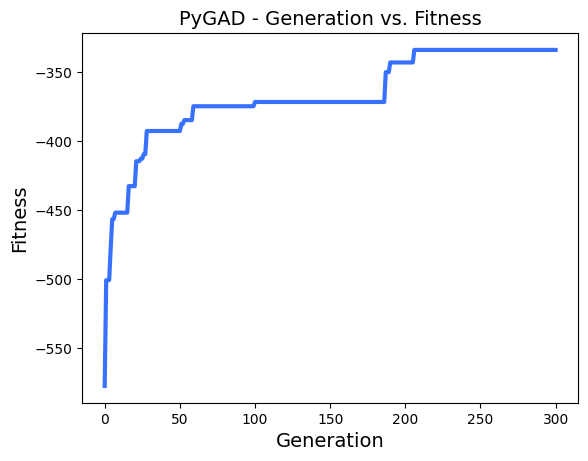

In [79]:
solution, solution_fitness, my_time = perform_genetic(graph)

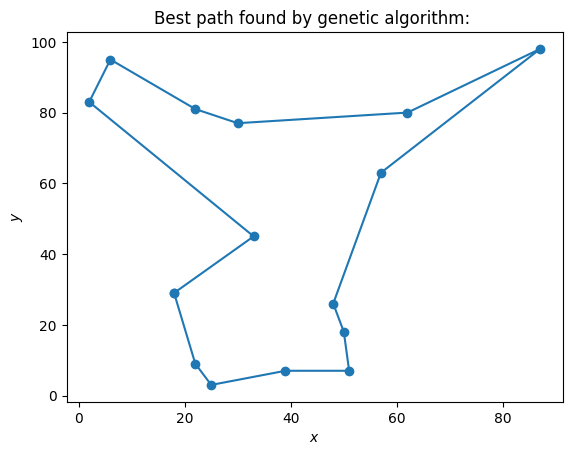

In [80]:
output_way = draw_path_genetic(solution,coords_2)

- third large input

In [81]:
#create_coordinates(15, 1, 100)

In [82]:
coords_3 = [(62, 46), (83, 22), (43, 33), (94, 39), (21, 76), (99, 43), (97, 35), (6, 49), (15, 27), (70, 11), (18, 96), (12, 52), (17, 69), (7, 19), (1, 42)]

In [83]:
graph = create_matrix(coords_3)

In [84]:
graphs_large.append(graph)

Parameters of best solution : [ 0.  3.  5.  6.  1.  9.  2.  8. 13. 14.  7. 11. 12.  4. 10.]
Fitness of the best solution = -310.0074862775921


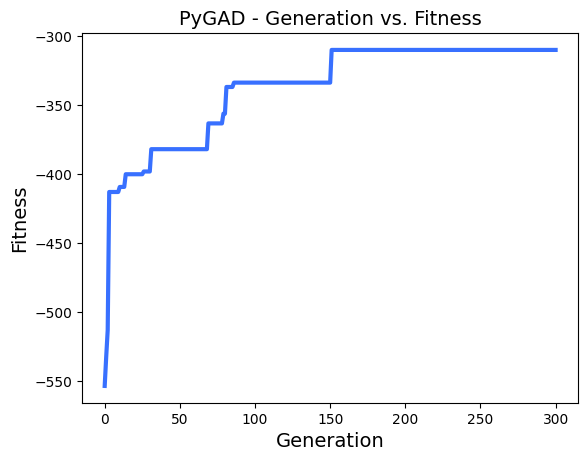

In [85]:
solution, solution_fitness, my_time = perform_genetic(graph)

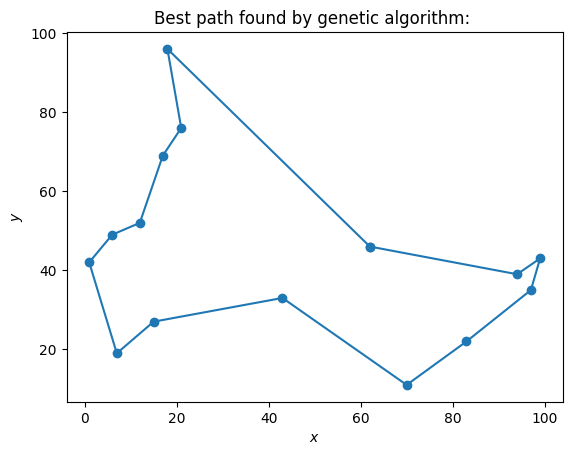

In [86]:
output_way = draw_path_genetic(solution,coords_3)

#### conclusions:

For large graphs I decided to consider solutions greater or equal to -406 in first graph, -333 in second and -310 in third as the optimal ones.

## 2. Experimental observations.

### 2.1 Effectiveness of genetic algorithm.

In [87]:
#list of reasuls that I consider as optimal ones decreased by 1
best_results = [[-214,-150,-257],[-322,-326,-281],[-407,-334,-311]]

In [88]:
def get_counter_sum_time(results, best_fitness):
    """
    Given list of tuples (where for genetic algorithm each tuple consists of fitness, time, solution and in aco of fitness, time)
    and best_fitness value for chosen graph this funtion gets the number of best solutions in graph and calculates their mean time. 
    
    Inputs
    ------
    results: list of tuples
       tuple as (fitness, time, solution)
    best_fitness: int
        best fitness value for specyfic graph

    Returns
    -------
    counter: int
        number of best solutions in one example from three graphs
    sum_time: float
        sum of time for solutions with the best fitness value
    sum_time/counter: float
        mean time for solutions with the best fitness value in one example from three graphs 
    """
    counter = 0
    sum_time = 0
    for tup in results:
        if tup[0] > best_fitness: #if the algorithm found better fitness value than I proposed it is also countes
            counter += 1 #it counts how many times the best fitness have occcured
            sum_time += tup[1]  #counts time of finding solution with that fitness value 
            
    if counter == 0: #if my algorithm hasn't found solution for that graph
        return 0, 0, 0
    else:
        return counter, sum_time, sum_time/counter

In [89]:
def effectiveness_genetic(graphs):
    """
    Given list of three graphs this function performs genetic algorithm 100 times and each time it chooses randomly one graph
    then it calculates the mean time of best solutions in each chosen graph separatly and in all graphs together.
    
    Inputs
    ------
    graphs: list of lists
       list of three lists where each list represent one graph wich is also represented as list of lists

    Returns
    -------
    effectivness_graph: list of tuples
     tuple as (counter,len(results),mean_time), it represents effectivness for each example seperatly
    counters: int
        number of best solutions in all examples together
    sum_times/counters:
        mean time of best solutions in all examples together
    """
    results = [[],[],[]] #there will be resuls for each example of graphs
    global graph
    for i in range(100):
        index = random.randint(0,2) #randomly chooses index
        graph = graphs[index] #chooses this graf from inputs that is on chosen index in list graphs
        solution, solution_fitness, my_time = perform_genetic(graph)
        #for results on position of index chosen adds tuple with fitness of solution, time of algorithm and solution
        results[index].append((solution_fitness, my_time, solution))
    
    effectivness_graph = [] #effectiveness seperatly in each graph
    counters = 0
    sum_times = 0
    index_graphs = 0 
    if len(graphs[0]) == 10: #if it is one of medium graphs it will be cheking list of position 1 in best_resulst
        index_graphs = 1
    elif len(graphs[0]) == 15: #if it is one of large graphs it will be cheking list of position 2 in best_resulst
        index_graphs = 2
    for i in range(len(results)):
        counter, sum_time, mean_time = get_counter_sum_time(results[i], best_results[index_graphs][i]) 
        counters += counter #counts how many times graphs achieved its best fitness
        sum_times += sum_time #counts time of finding that solutions with best fitnesses for specyfic graph
        effectivness_graph.append((counter,len(results[i]),mean_time))
    if counters == 0:
        print("No solution with fitness value declared as the optimal have appeard.")
        return effectivness_graph, 0, 0, results
    else:
        return effectivness_graph,counters, sum_times/counters, results

#### 2.1.1 Small inputs.

In [90]:
small_results = []

Parameters of best solution : [4. 3. 2. 1. 0.]
Fitness of the best solution = -213.45377384244733


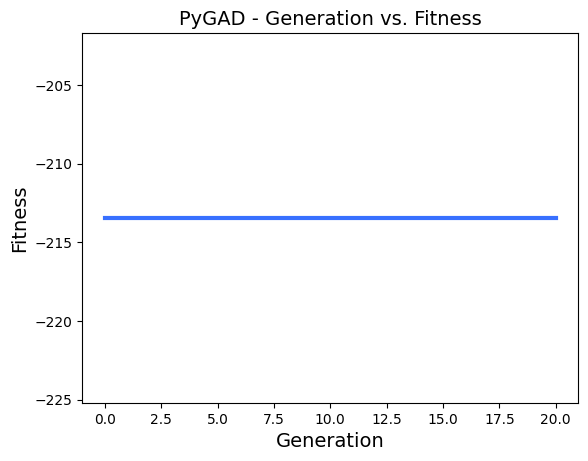

Parameters of best solution : [0. 1. 2. 3. 4.]
Fitness of the best solution = -213.45377384244733


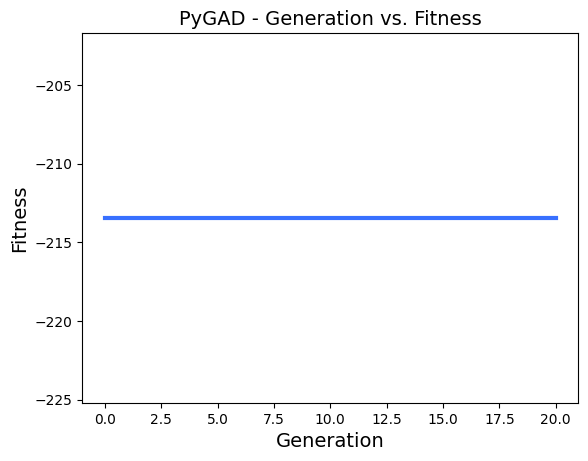

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


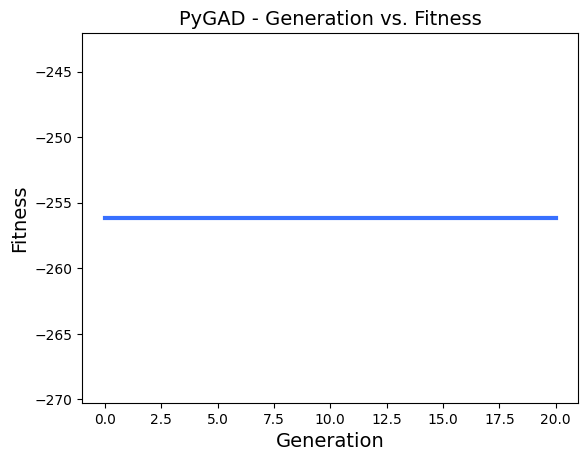

Parameters of best solution : [4. 2. 0. 3. 1.]
Fitness of the best solution = -149.72246633025193


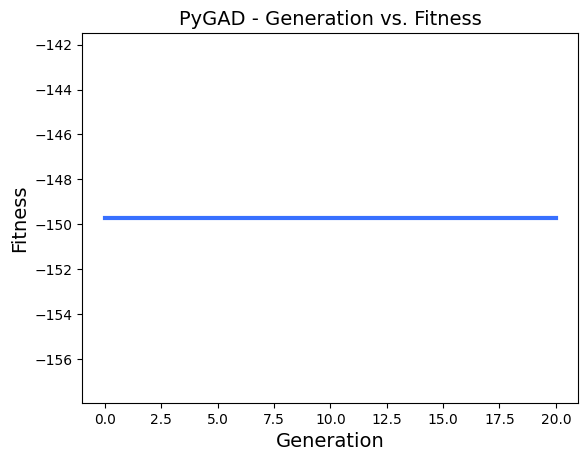

Parameters of best solution : [4. 3. 2. 1. 0.]
Fitness of the best solution = -213.45377384244733


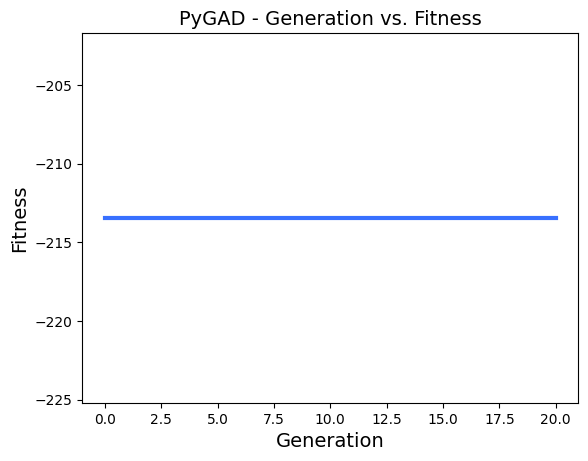

Parameters of best solution : [0. 1. 2. 3. 4.]
Fitness of the best solution = -213.45377384244733


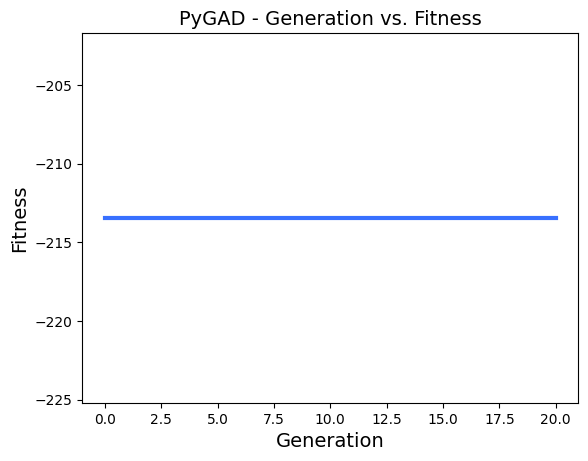

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


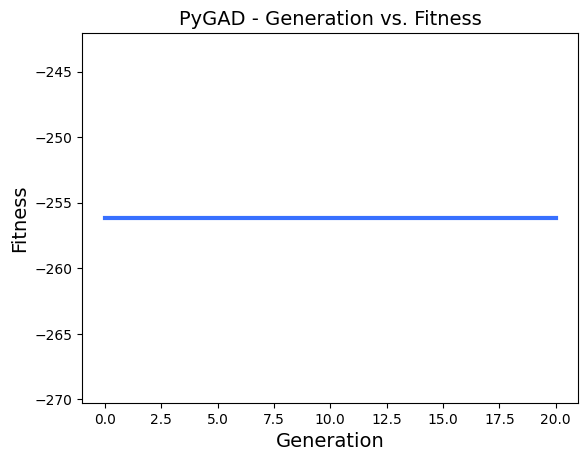

Parameters of best solution : [0. 1. 2. 3. 4.]
Fitness of the best solution = -213.45377384244733


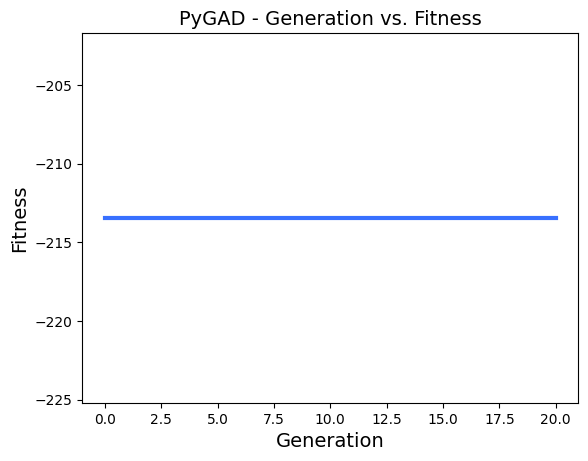

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


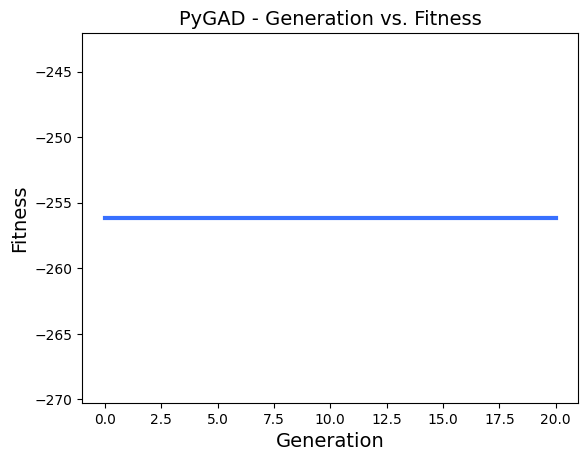

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


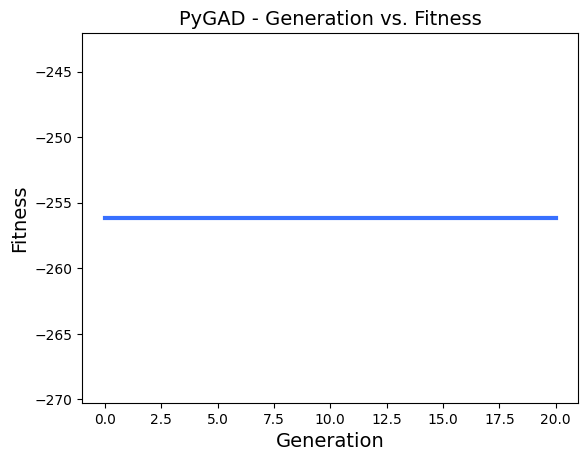

Parameters of best solution : [3. 1. 4. 2. 0.]
Fitness of the best solution = -149.72246633025193


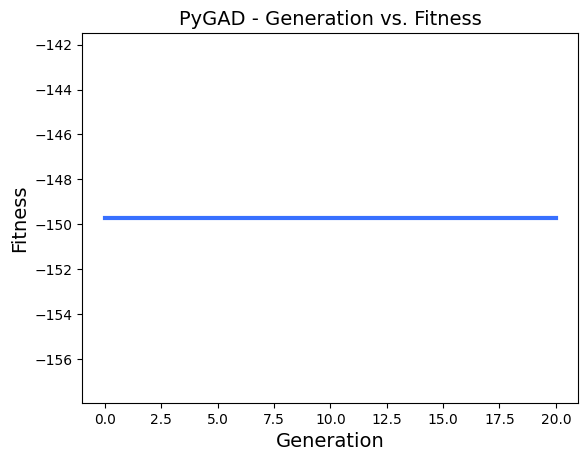

Parameters of best solution : [0. 1. 2. 3. 4.]
Fitness of the best solution = -213.45377384244733


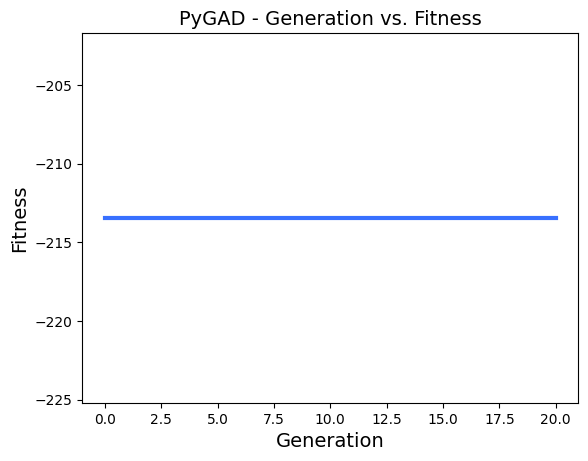

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


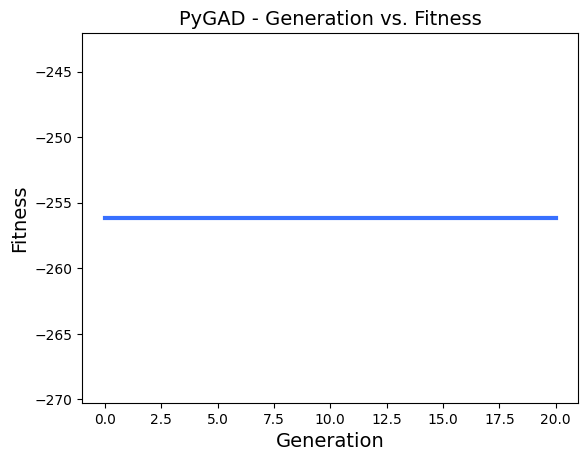

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


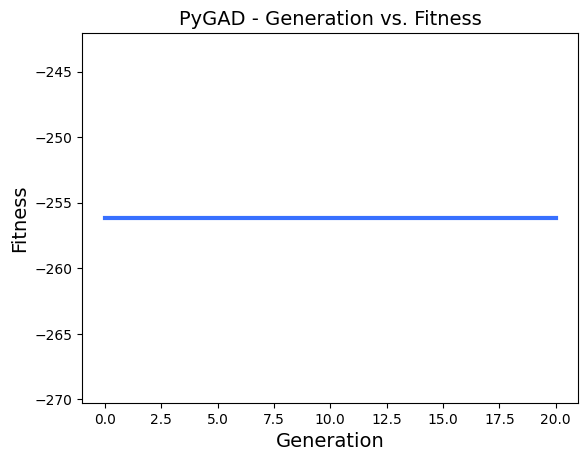

Parameters of best solution : [4. 3. 2. 1. 0.]
Fitness of the best solution = -213.45377384244733


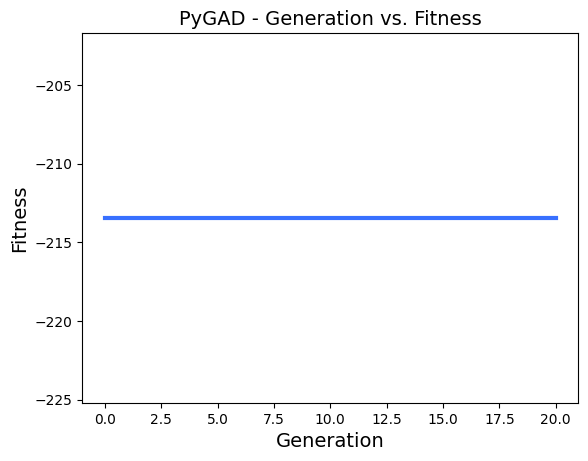

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


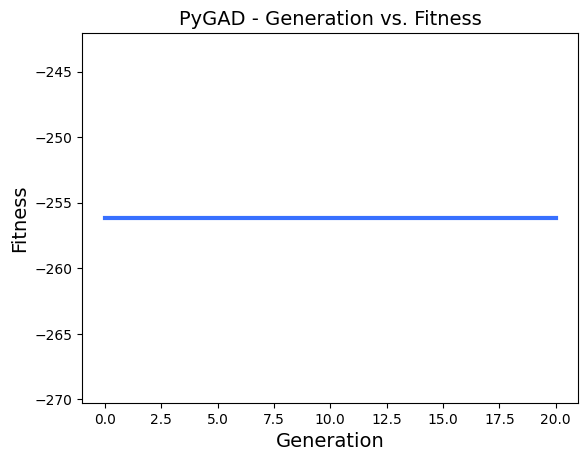

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


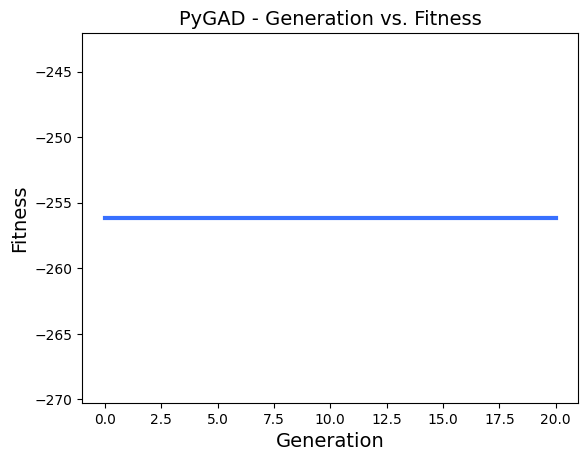

Parameters of best solution : [2. 3. 4. 0. 1.]
Fitness of the best solution = -213.45377384244733


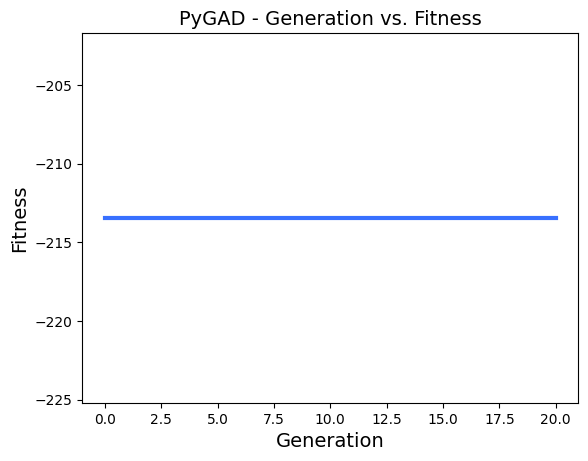

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


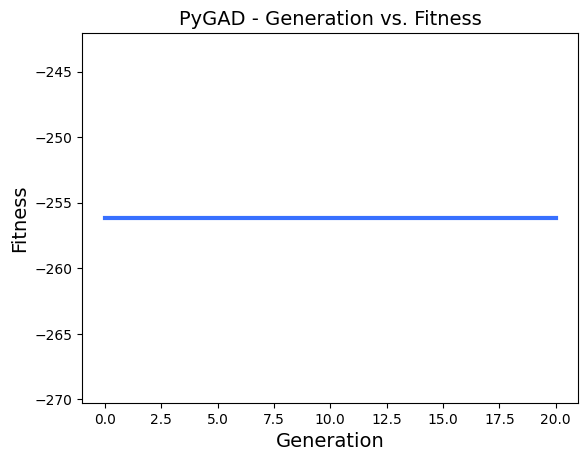

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


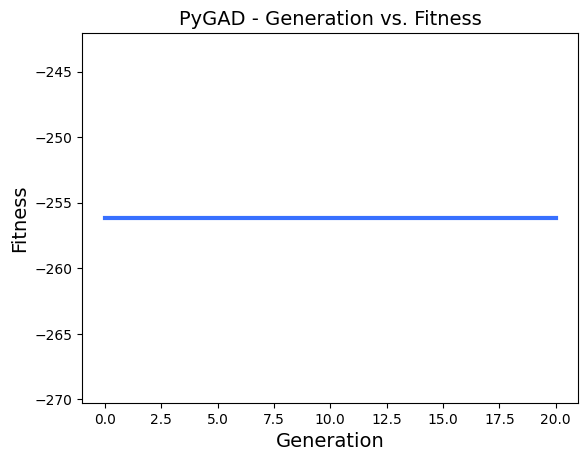

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


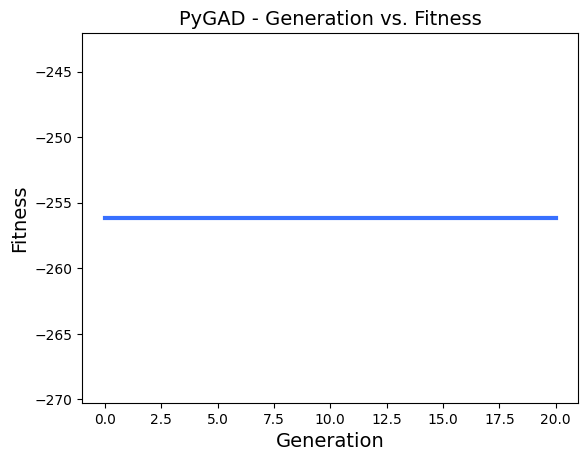

Parameters of best solution : [4. 2. 0. 3. 1.]
Fitness of the best solution = -149.72246633025193


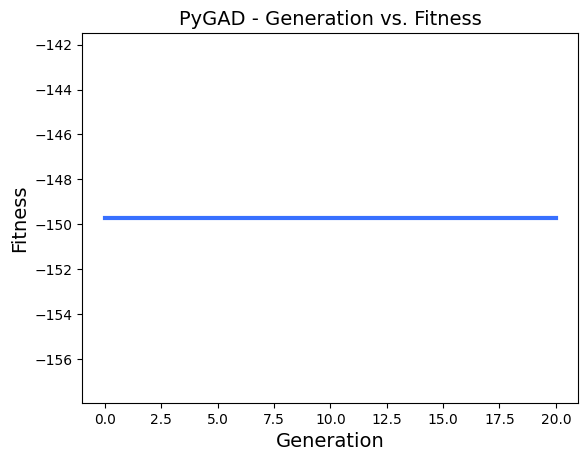

Parameters of best solution : [4. 3. 2. 1. 0.]
Fitness of the best solution = -213.45377384244733


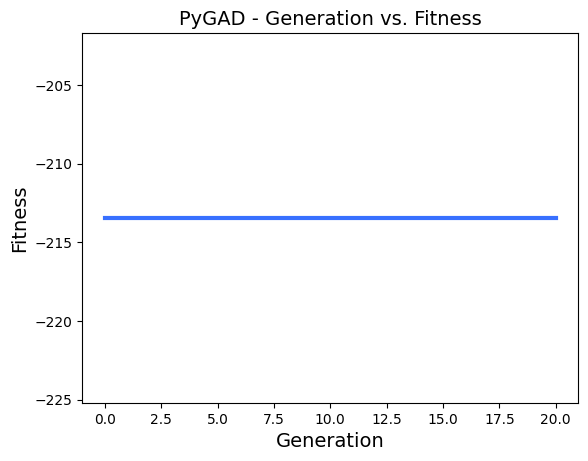

Parameters of best solution : [0. 1. 2. 3. 4.]
Fitness of the best solution = -213.45377384244733


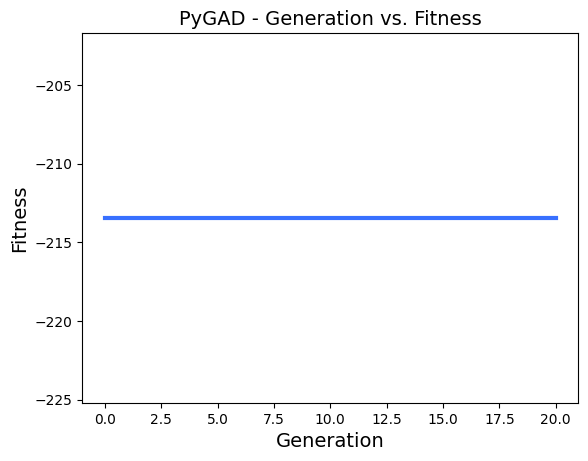

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


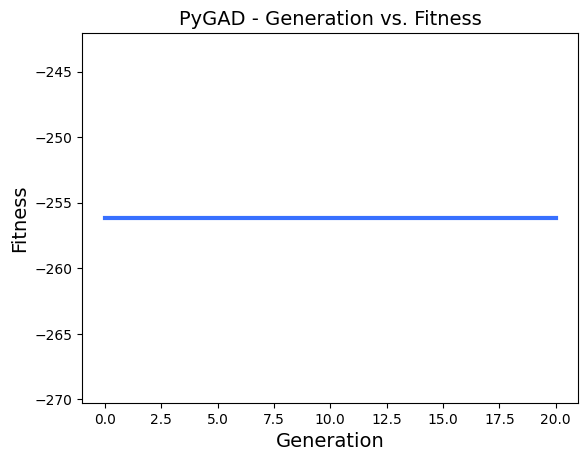

Parameters of best solution : [4. 3. 2. 1. 0.]
Fitness of the best solution = -213.45377384244733


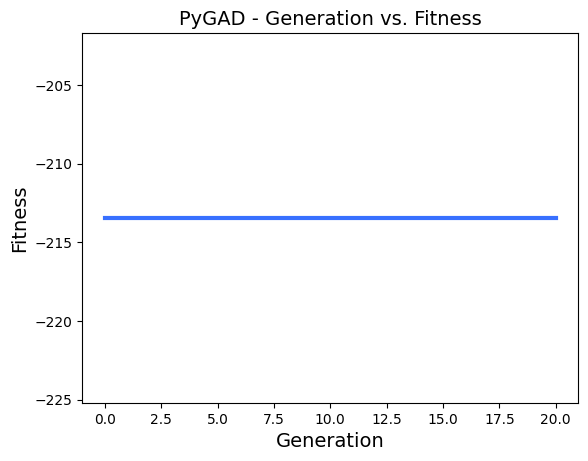

Parameters of best solution : [2. 3. 4. 0. 1.]
Fitness of the best solution = -213.45377384244733


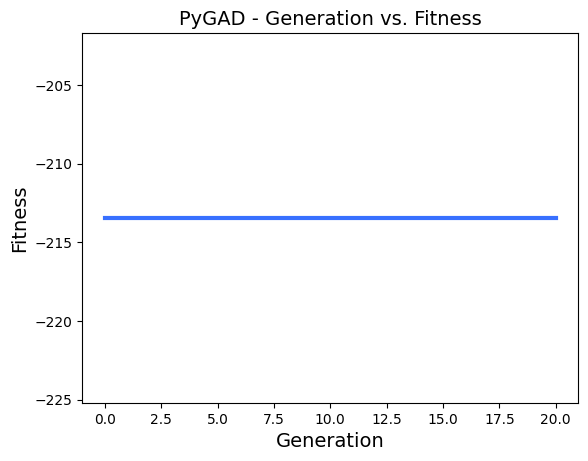

Parameters of best solution : [2. 3. 4. 0. 1.]
Fitness of the best solution = -213.45377384244733


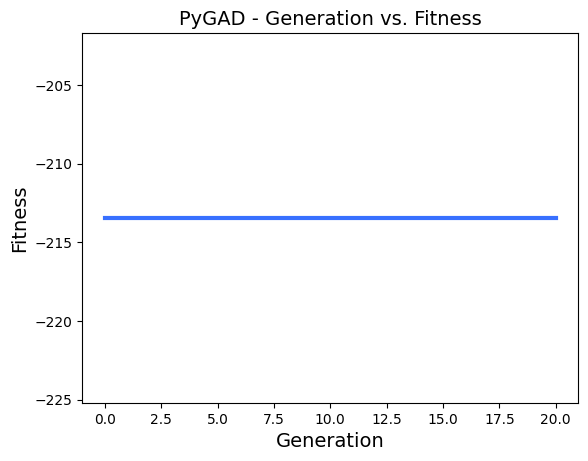

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


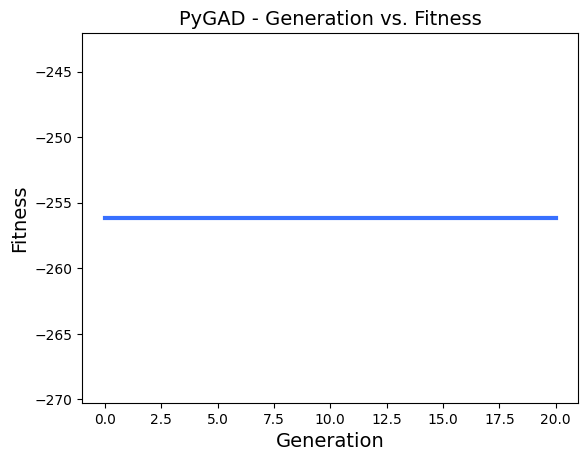

Parameters of best solution : [2. 3. 4. 0. 1.]
Fitness of the best solution = -213.45377384244733


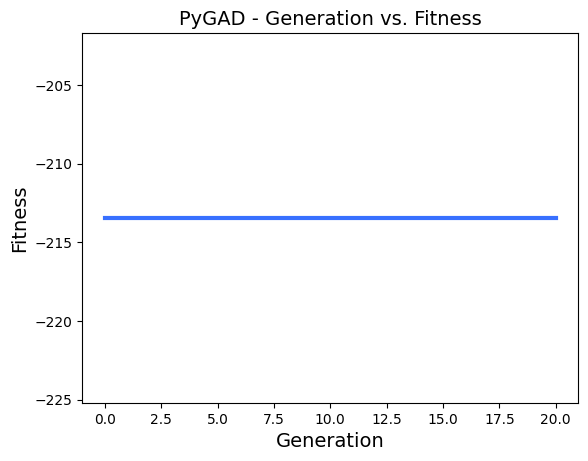

Parameters of best solution : [0. 2. 4. 1. 3.]
Fitness of the best solution = -149.72246633025193


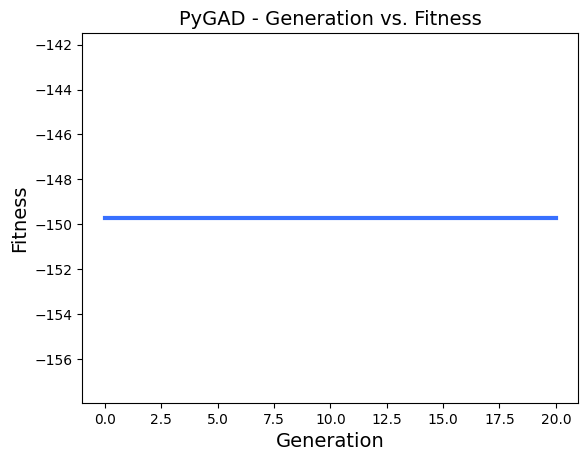

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


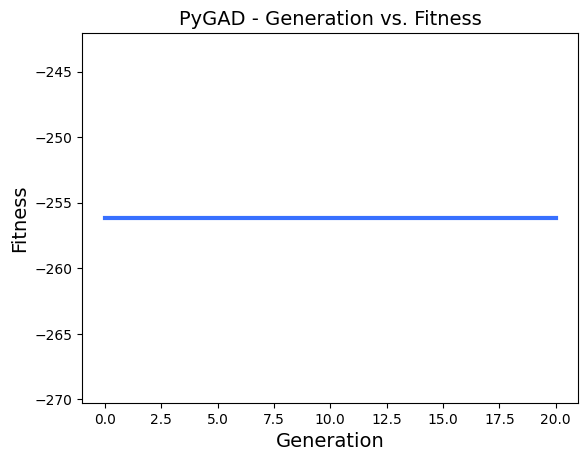

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


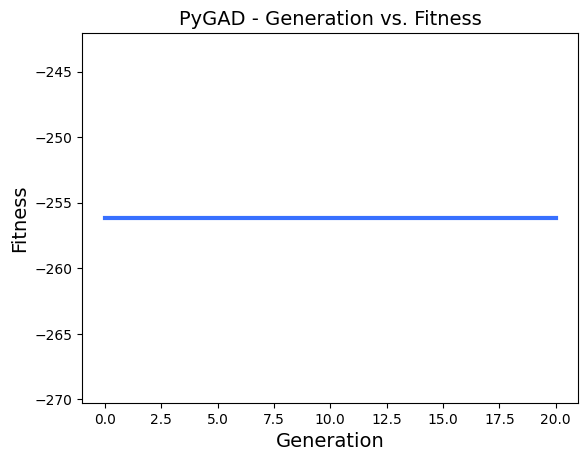

Parameters of best solution : [3. 1. 4. 2. 0.]
Fitness of the best solution = -149.72246633025193


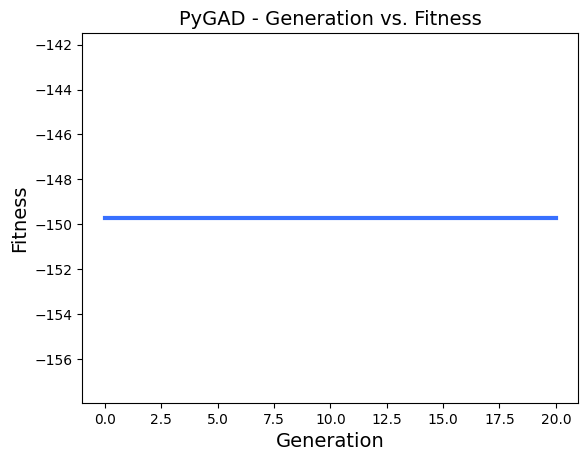

Parameters of best solution : [3. 1. 4. 2. 0.]
Fitness of the best solution = -149.72246633025193


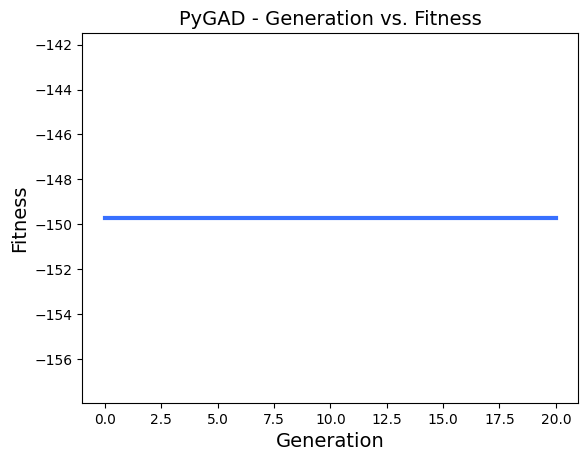

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


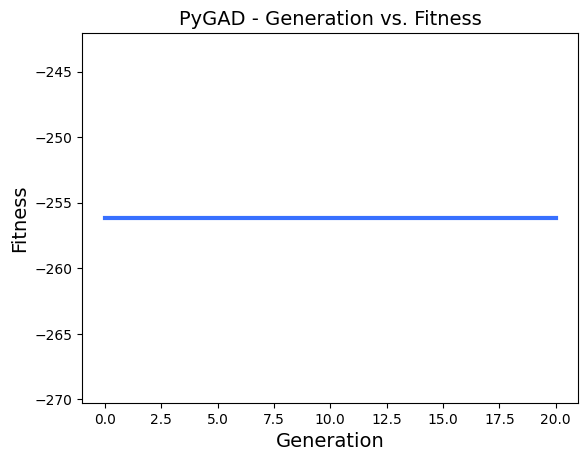

Parameters of best solution : [2. 3. 4. 0. 1.]
Fitness of the best solution = -213.45377384244733


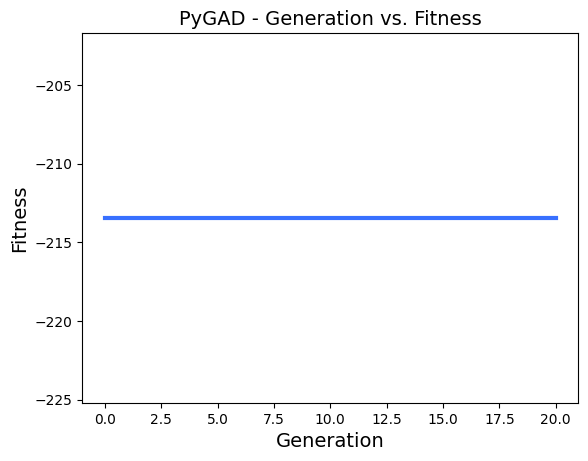

Parameters of best solution : [4. 3. 2. 1. 0.]
Fitness of the best solution = -213.45377384244733


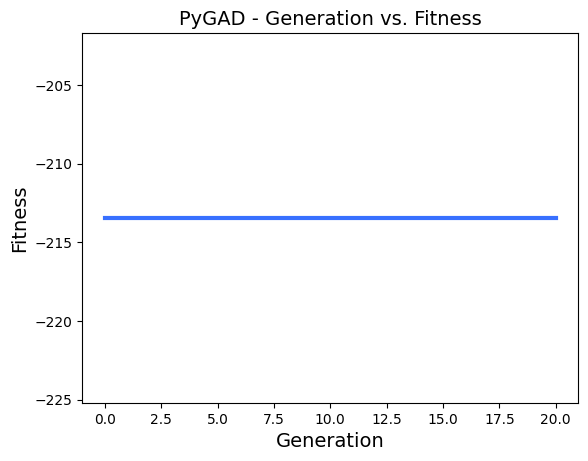

Parameters of best solution : [3. 1. 4. 2. 0.]
Fitness of the best solution = -149.72246633025193


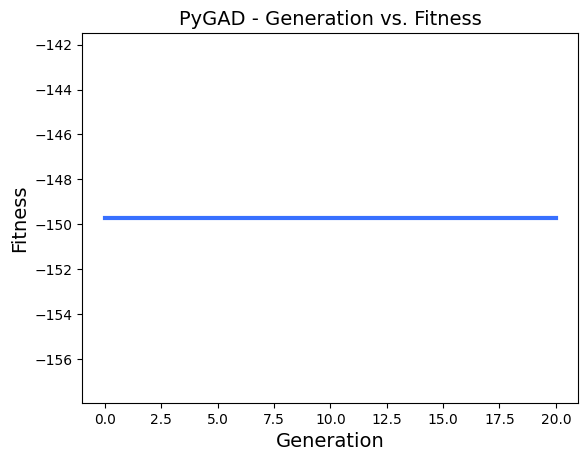

Parameters of best solution : [3. 1. 4. 2. 0.]
Fitness of the best solution = -149.72246633025193


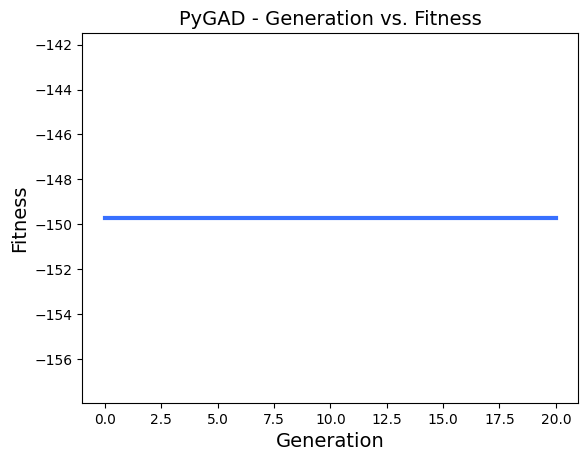

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


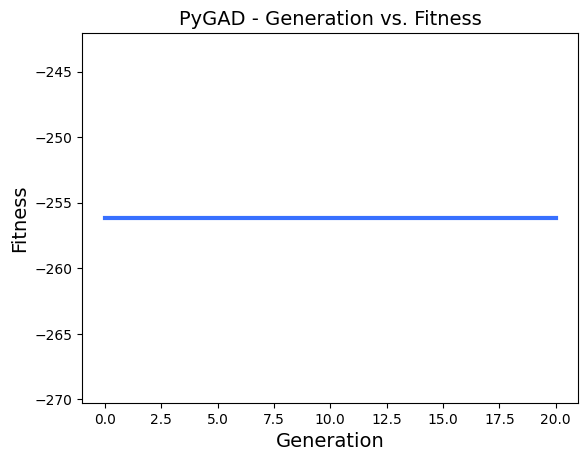

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


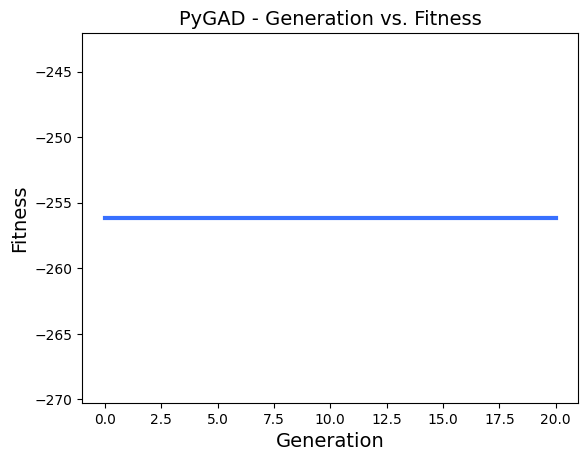

Parameters of best solution : [0. 1. 2. 3. 4.]
Fitness of the best solution = -213.45377384244733


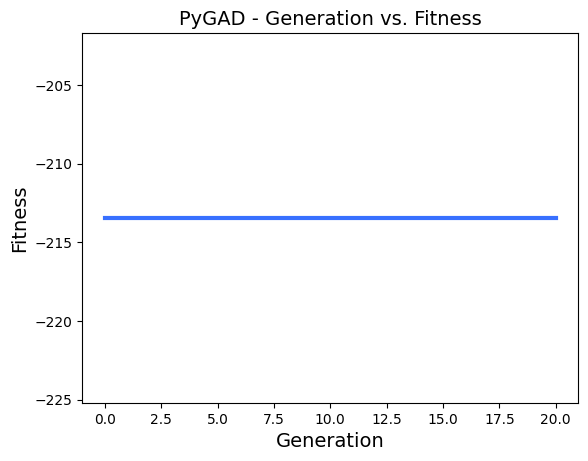

Parameters of best solution : [3. 1. 4. 2. 0.]
Fitness of the best solution = -149.72246633025193


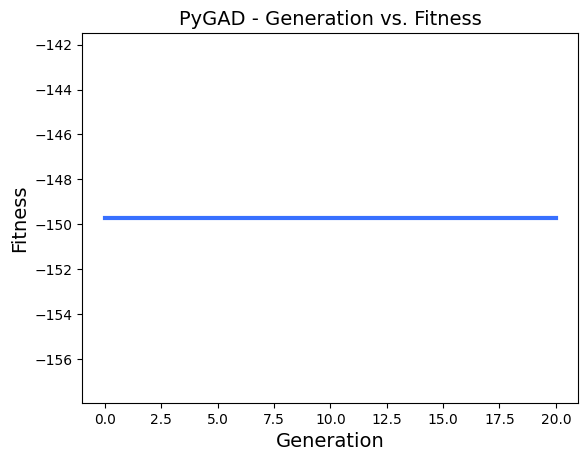

Parameters of best solution : [0. 1. 2. 3. 4.]
Fitness of the best solution = -213.45377384244733


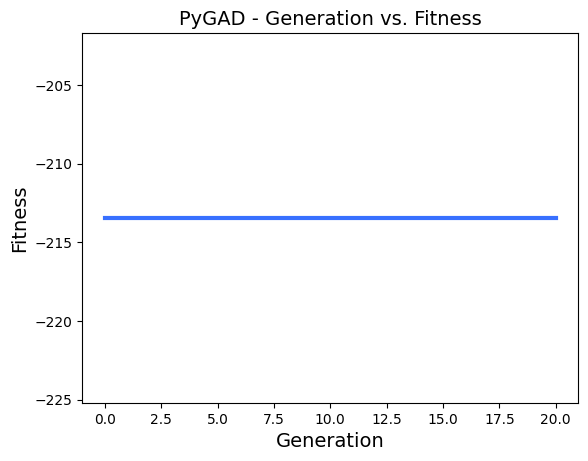

Parameters of best solution : [2. 3. 4. 0. 1.]
Fitness of the best solution = -213.45377384244733


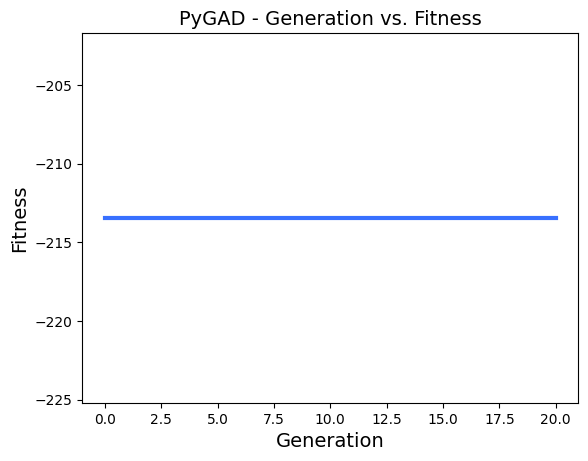

Parameters of best solution : [0. 1. 2. 3. 4.]
Fitness of the best solution = -213.45377384244733


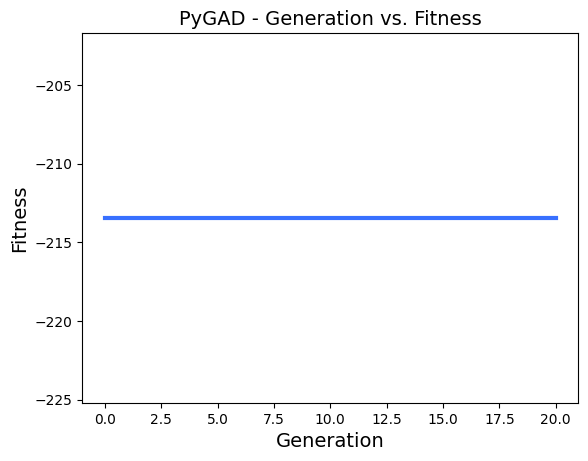

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


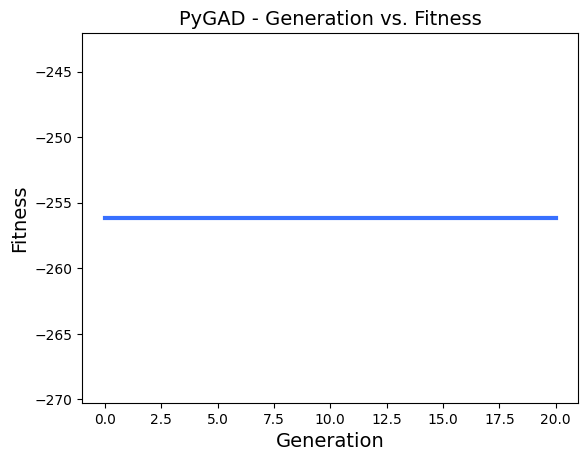

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


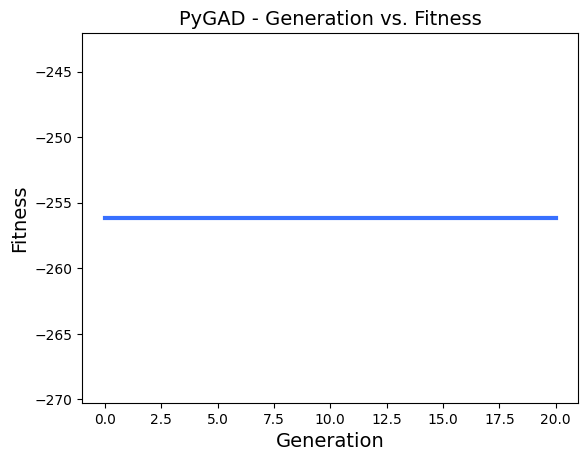

Parameters of best solution : [0. 2. 4. 1. 3.]
Fitness of the best solution = -149.72246633025193


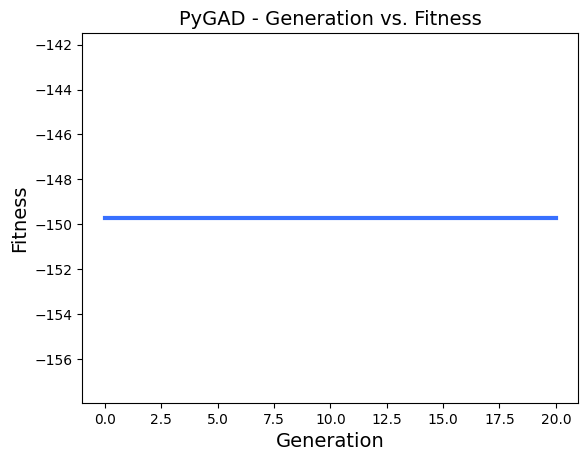

Parameters of best solution : [2. 3. 4. 0. 1.]
Fitness of the best solution = -213.45377384244733


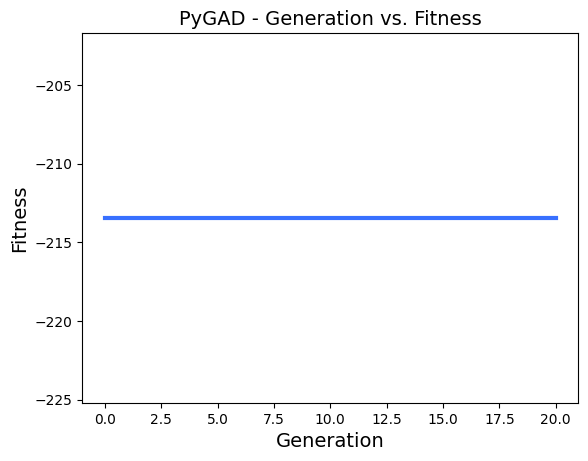

Parameters of best solution : [3. 1. 4. 2. 0.]
Fitness of the best solution = -149.72246633025193


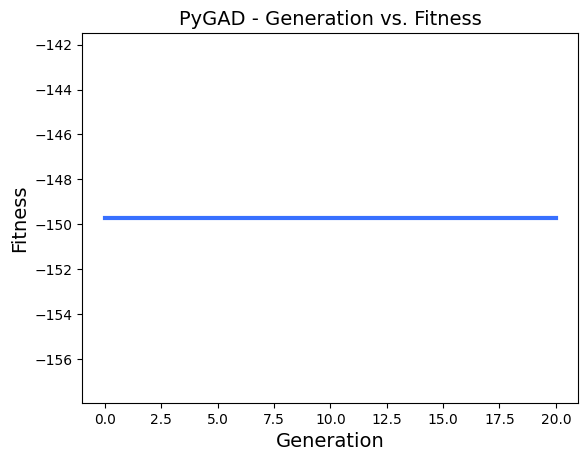

Parameters of best solution : [0. 2. 4. 1. 3.]
Fitness of the best solution = -149.72246633025193


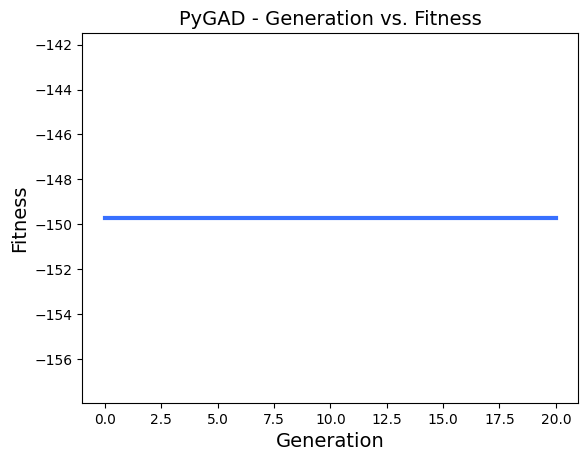

Parameters of best solution : [0. 2. 4. 1. 3.]
Fitness of the best solution = -149.72246633025193


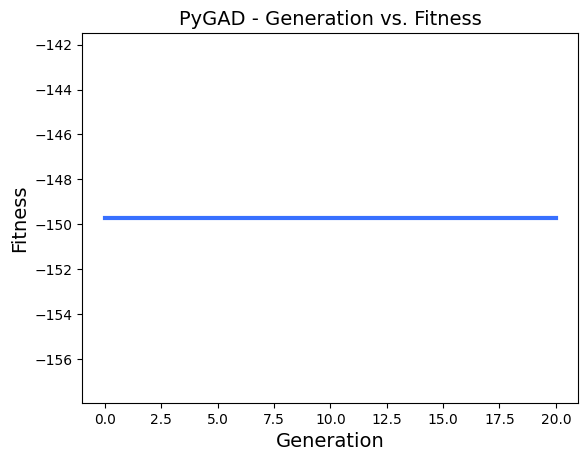

Parameters of best solution : [0. 2. 4. 1. 3.]
Fitness of the best solution = -149.72246633025193


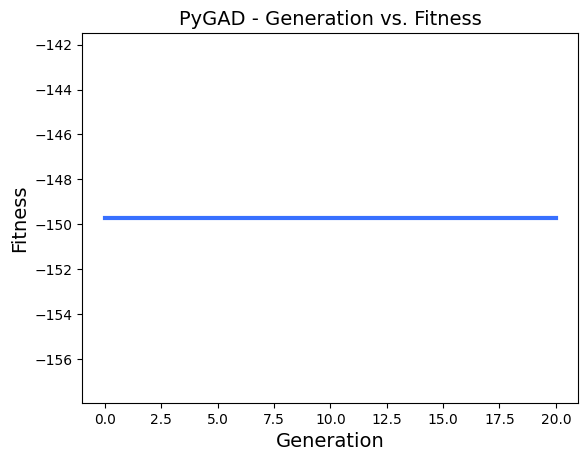

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


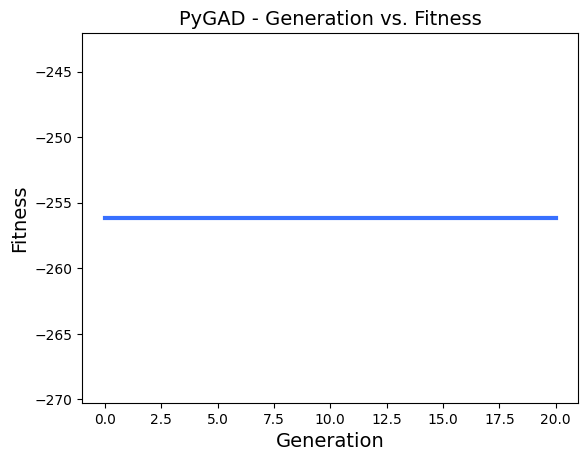

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


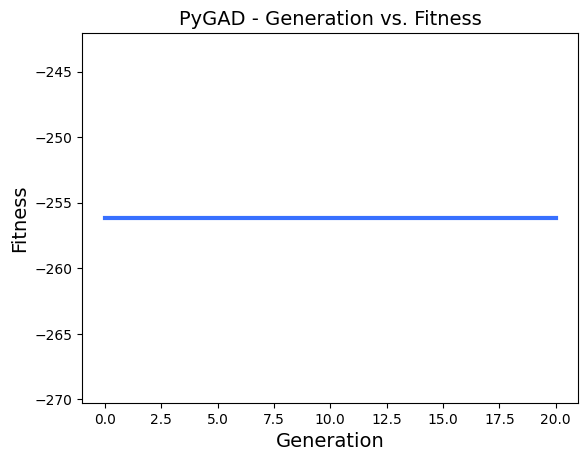

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


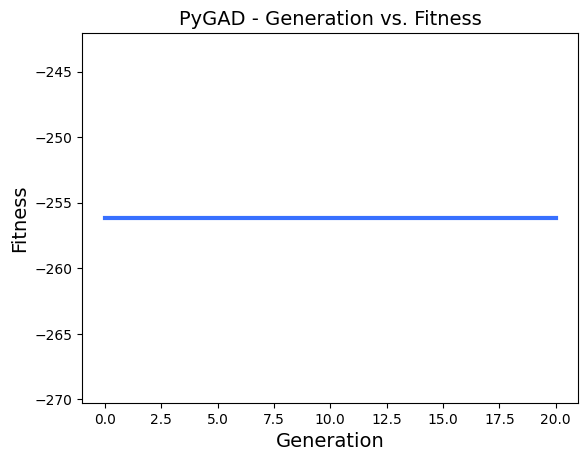

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


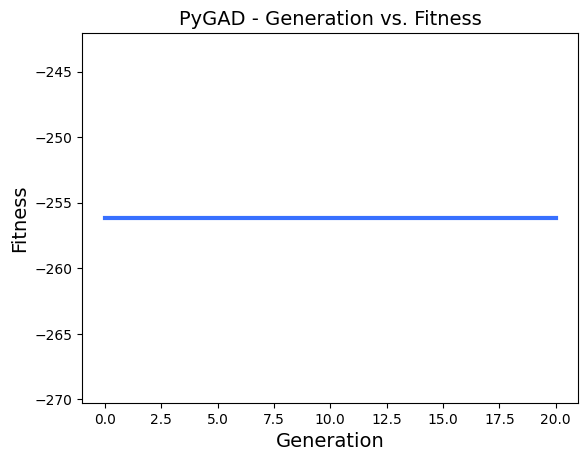

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


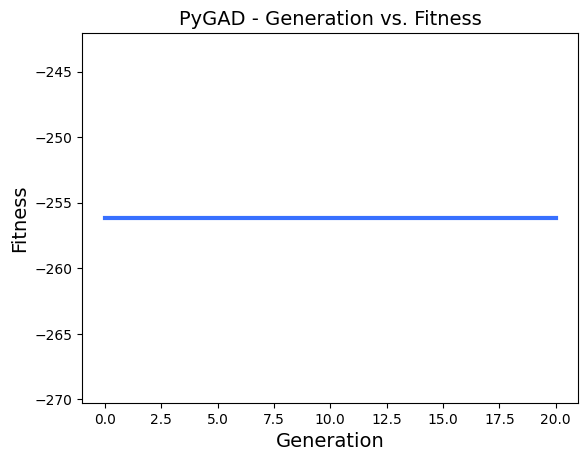

Parameters of best solution : [0. 2. 4. 1. 3.]
Fitness of the best solution = -149.72246633025193


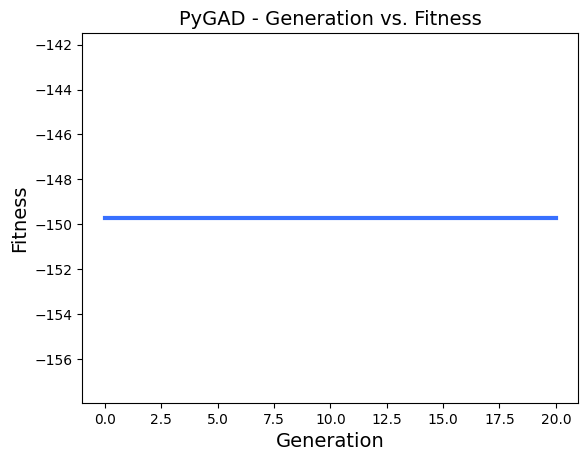

Parameters of best solution : [0. 1. 2. 3. 4.]
Fitness of the best solution = -213.45377384244733


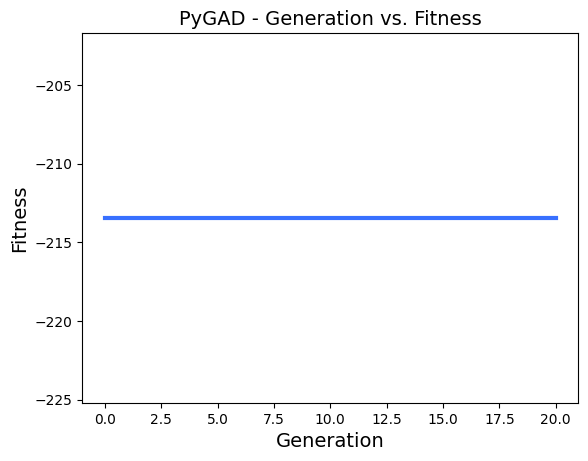

Parameters of best solution : [2. 3. 4. 0. 1.]
Fitness of the best solution = -213.45377384244733


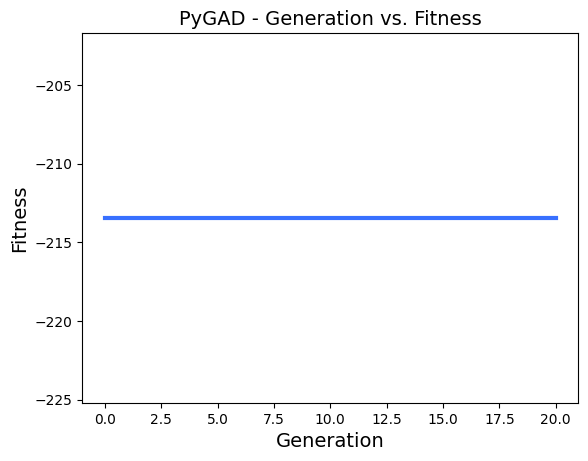

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


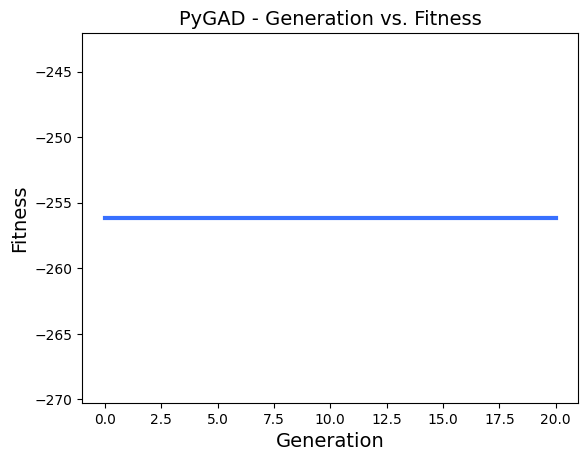

Parameters of best solution : [2. 3. 4. 0. 1.]
Fitness of the best solution = -213.45377384244733


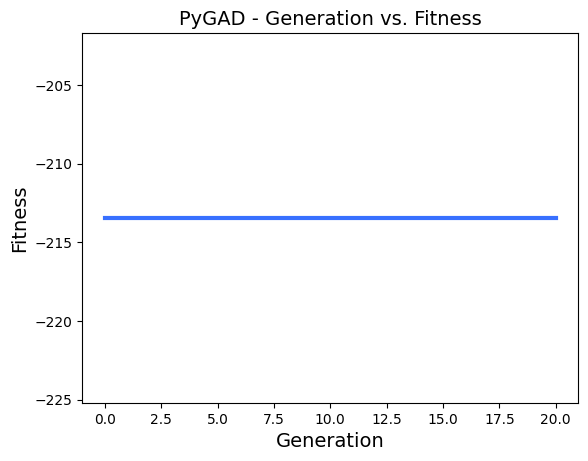

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


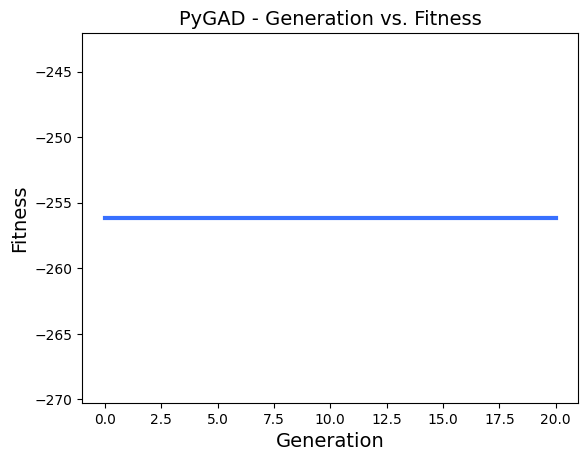

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


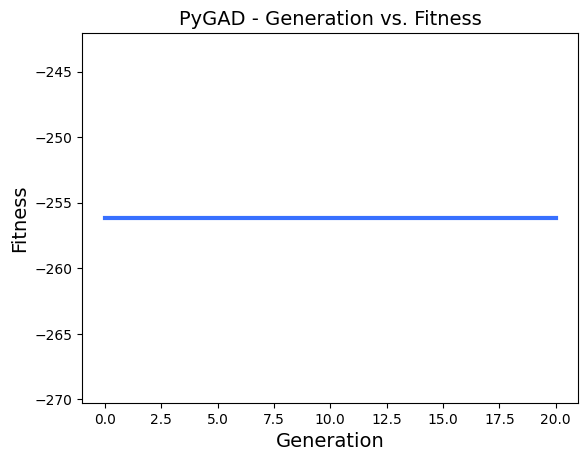

Parameters of best solution : [3. 1. 4. 2. 0.]
Fitness of the best solution = -149.72246633025193


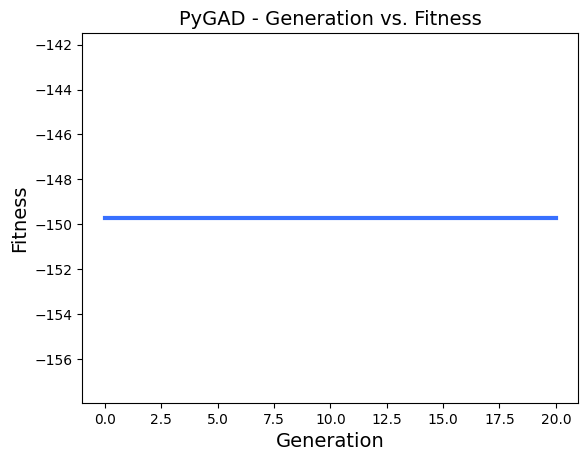

Parameters of best solution : [4. 2. 0. 3. 1.]
Fitness of the best solution = -149.72246633025193


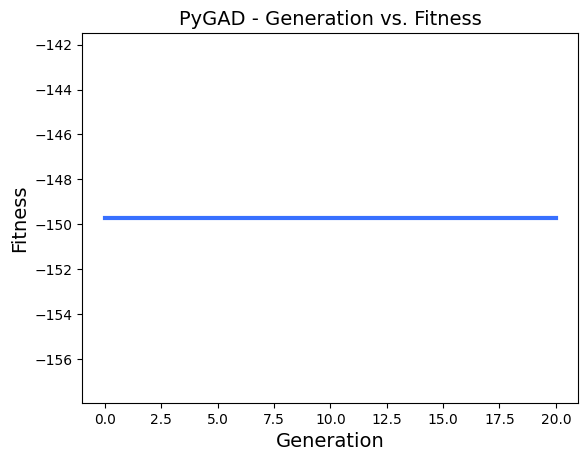

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


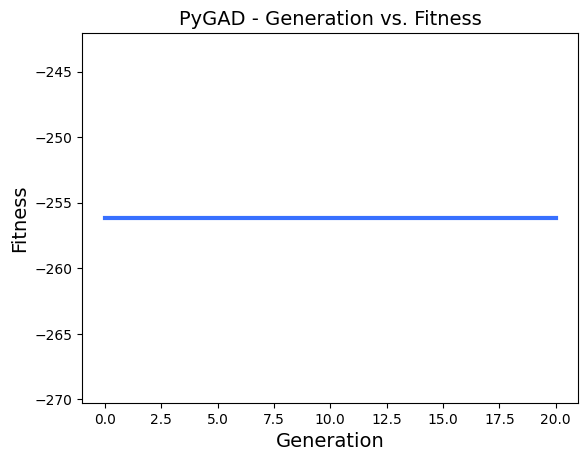

Parameters of best solution : [0. 1. 2. 3. 4.]
Fitness of the best solution = -213.45377384244733


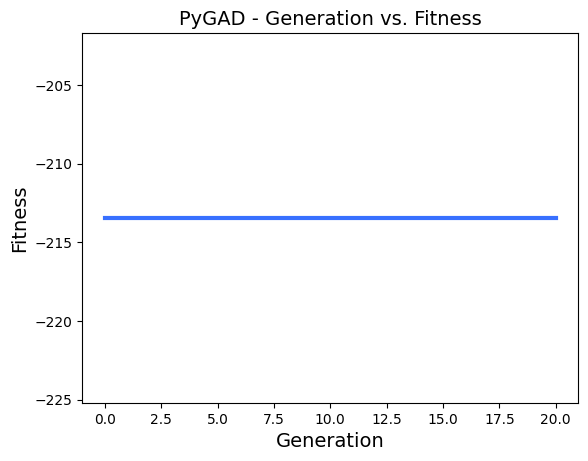

Parameters of best solution : [4. 2. 0. 3. 1.]
Fitness of the best solution = -149.72246633025193


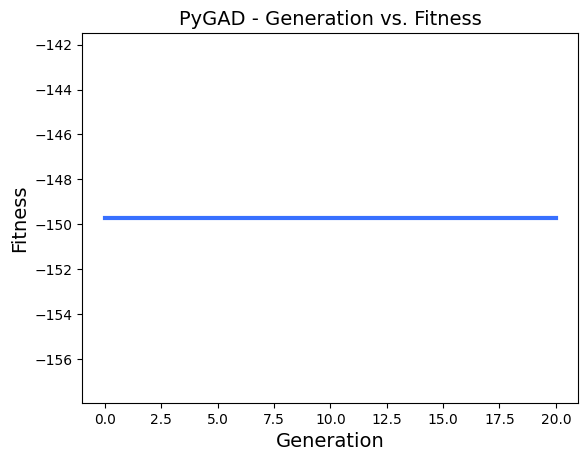

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


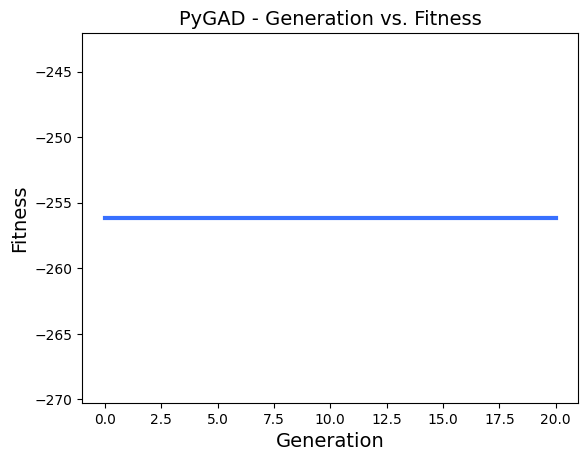

Parameters of best solution : [4. 2. 0. 3. 1.]
Fitness of the best solution = -149.72246633025193


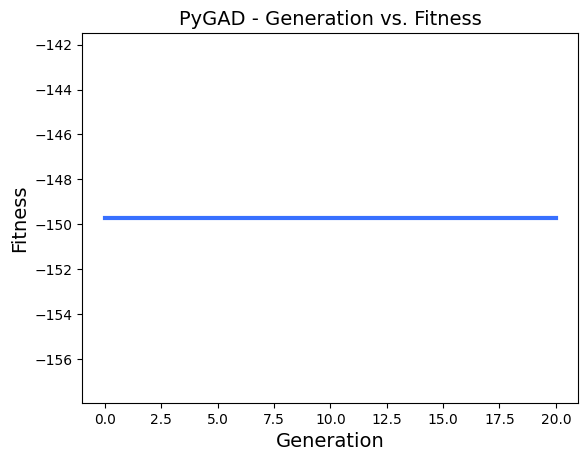

Parameters of best solution : [4. 3. 2. 1. 0.]
Fitness of the best solution = -213.45377384244733


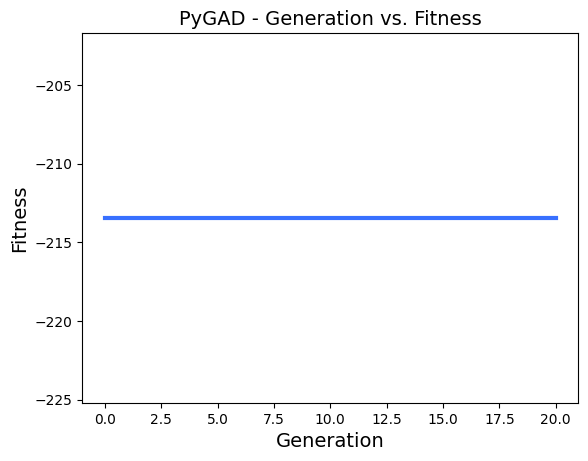

Parameters of best solution : [4. 3. 2. 1. 0.]
Fitness of the best solution = -213.45377384244733


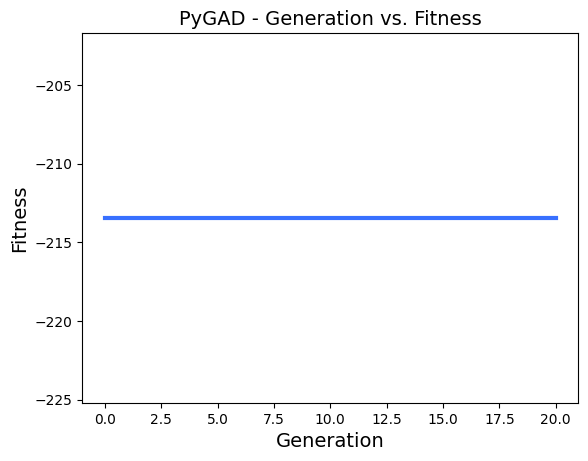

Parameters of best solution : [0. 2. 4. 1. 3.]
Fitness of the best solution = -149.72246633025193


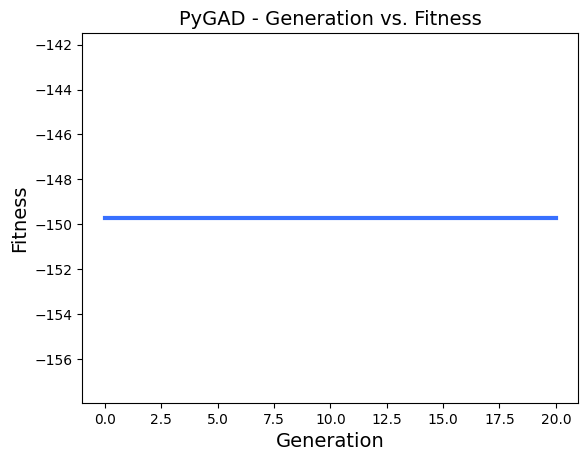

Parameters of best solution : [0. 2. 4. 1. 3.]
Fitness of the best solution = -149.72246633025193


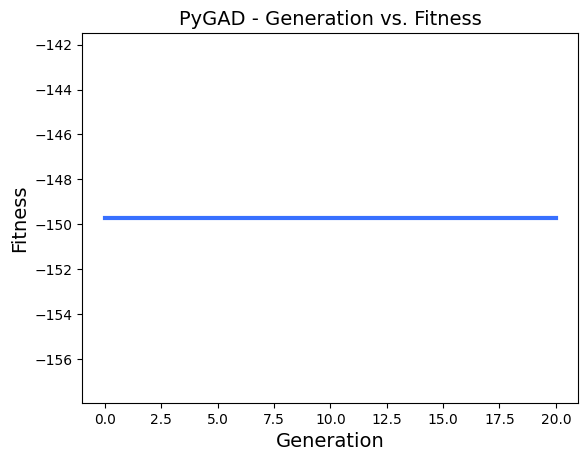

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


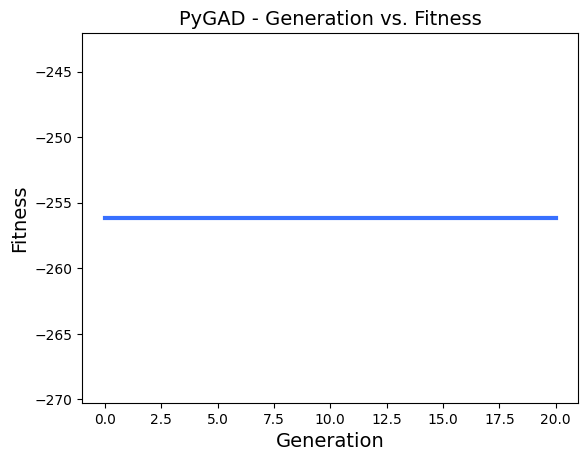

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


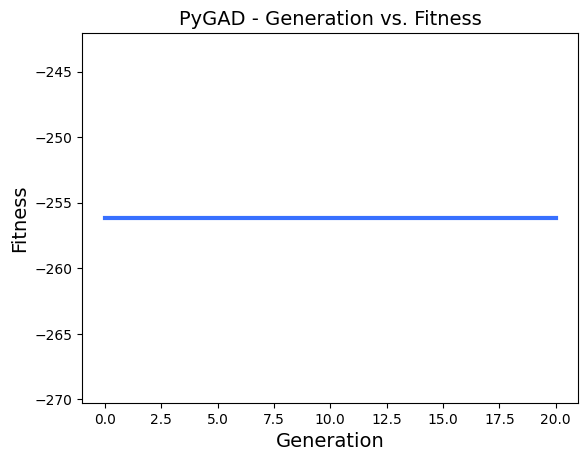

Parameters of best solution : [4. 2. 0. 3. 1.]
Fitness of the best solution = -149.72246633025193


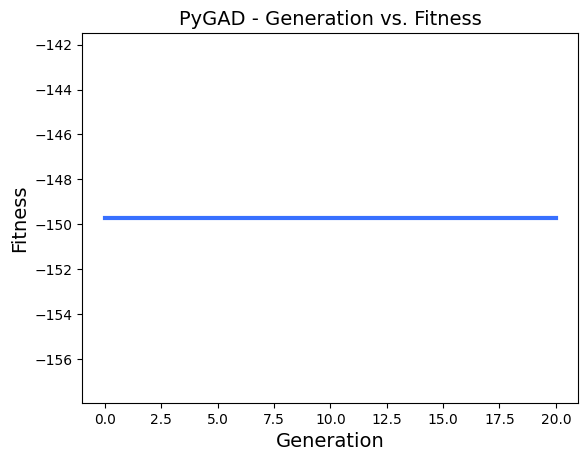

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


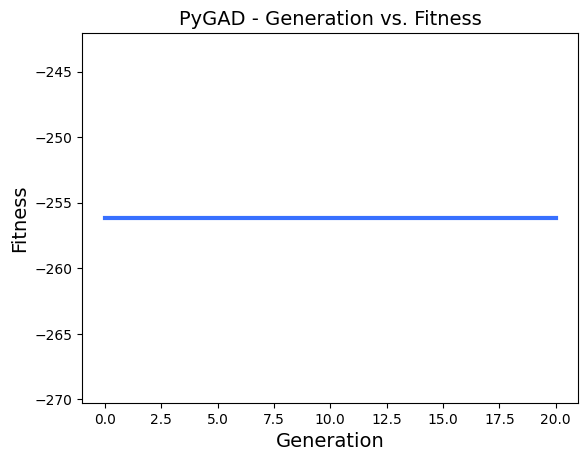

Parameters of best solution : [2. 3. 4. 0. 1.]
Fitness of the best solution = -213.45377384244733


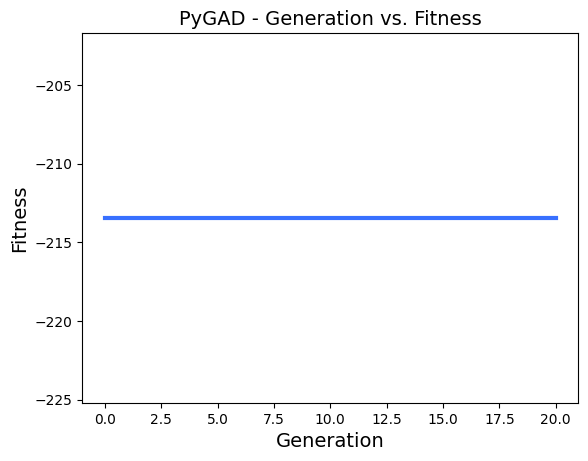

Parameters of best solution : [4. 2. 0. 3. 1.]
Fitness of the best solution = -149.72246633025193


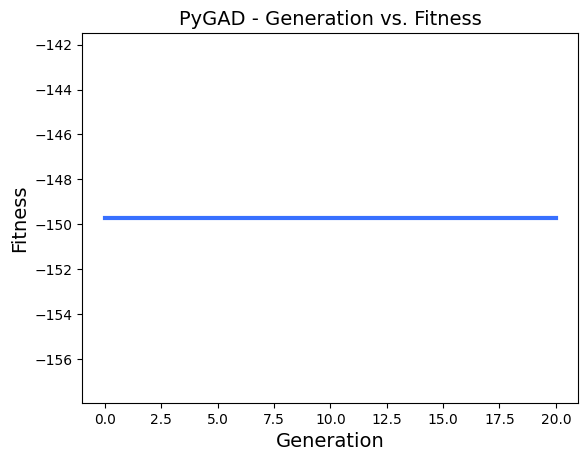

Parameters of best solution : [4. 3. 2. 1. 0.]
Fitness of the best solution = -213.45377384244733


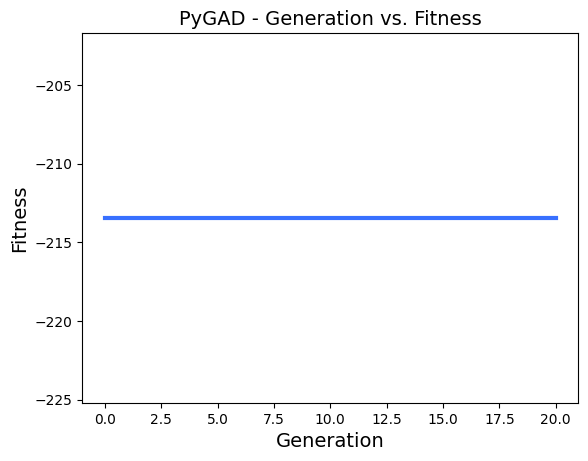

Parameters of best solution : [0. 1. 2. 3. 4.]
Fitness of the best solution = -213.45377384244733


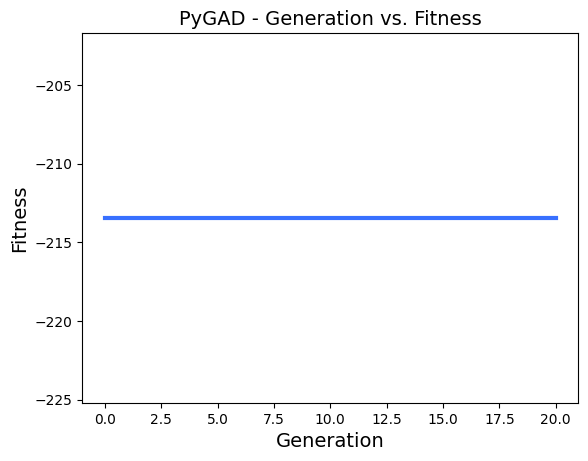

Parameters of best solution : [3. 1. 4. 2. 0.]
Fitness of the best solution = -149.72246633025193


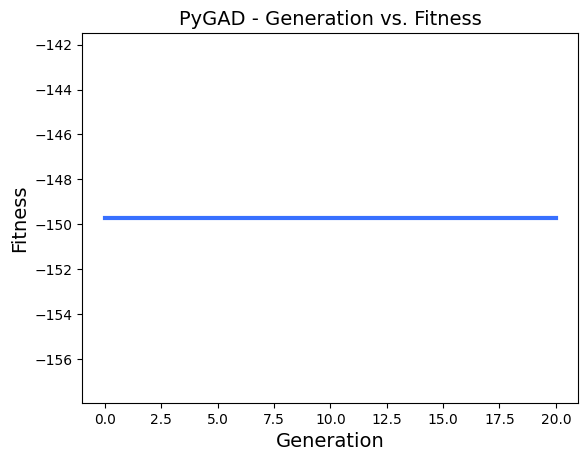

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


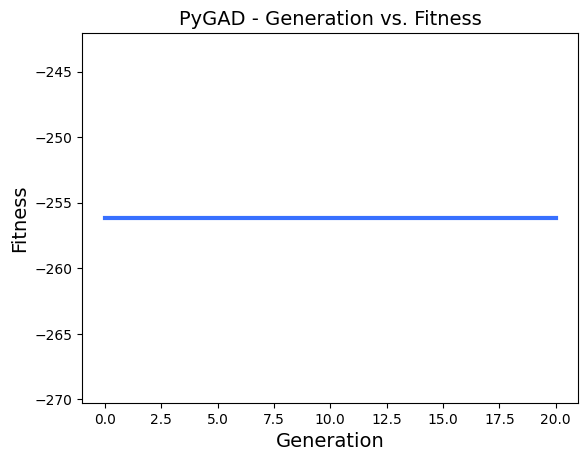

Parameters of best solution : [3. 1. 4. 2. 0.]
Fitness of the best solution = -149.72246633025193


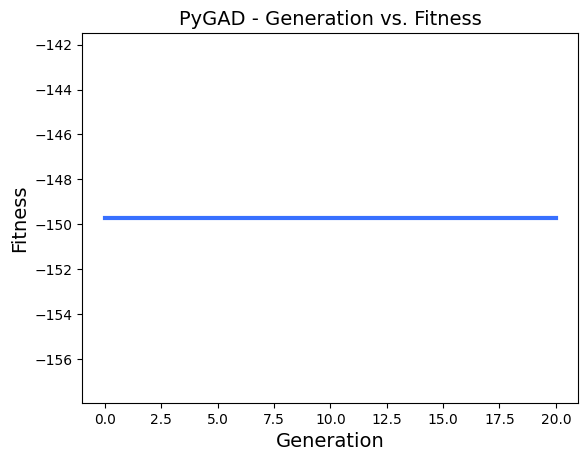

Parameters of best solution : [4. 0. 1. 2. 3.]
Fitness of the best solution = -213.45377384244733


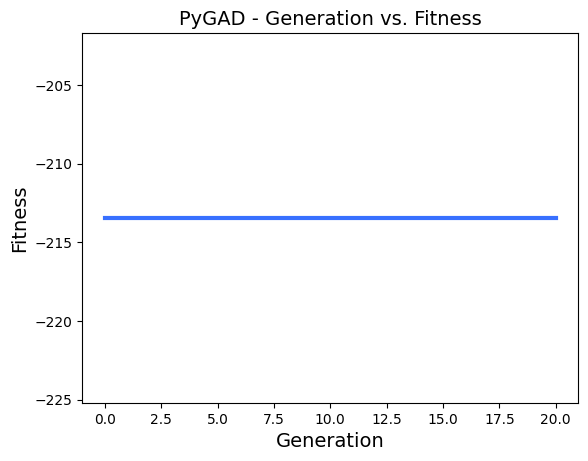

Parameters of best solution : [4. 3. 2. 1. 0.]
Fitness of the best solution = -213.45377384244733


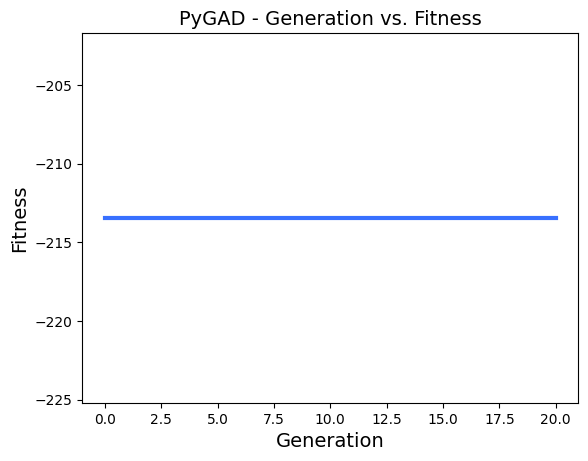

Parameters of best solution : [0. 2. 4. 1. 3.]
Fitness of the best solution = -149.72246633025193


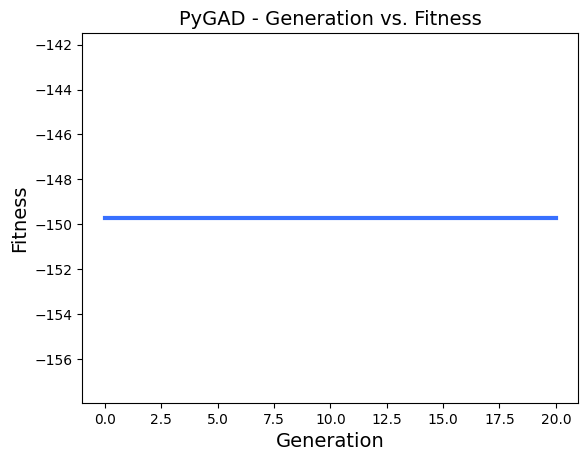

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


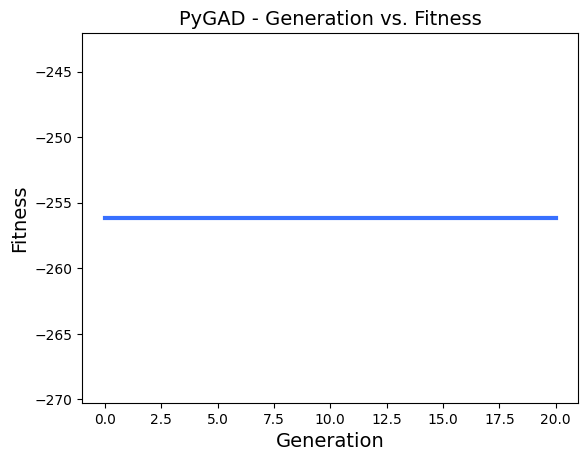

Parameters of best solution : [3. 1. 4. 2. 0.]
Fitness of the best solution = -149.72246633025193


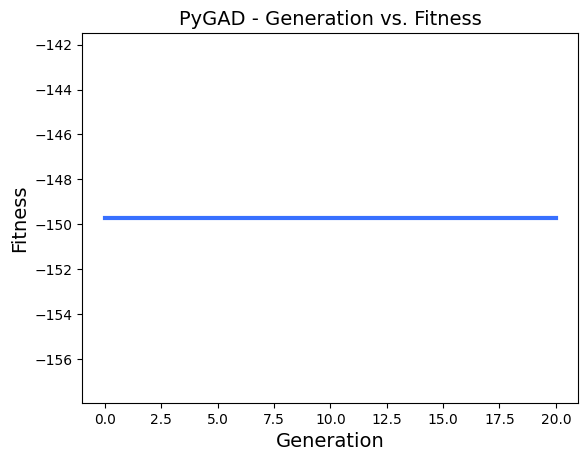

Parameters of best solution : [4. 2. 0. 3. 1.]
Fitness of the best solution = -149.72246633025193


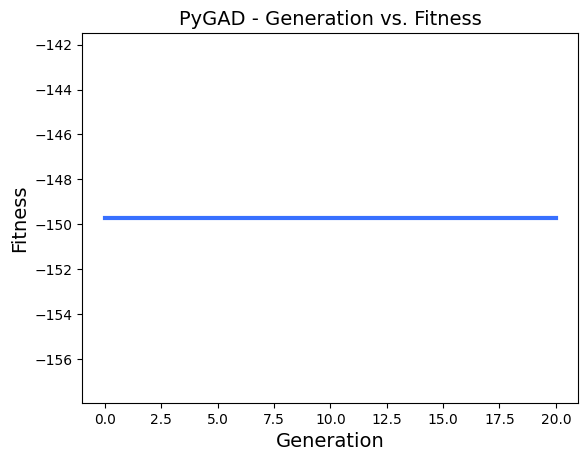

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


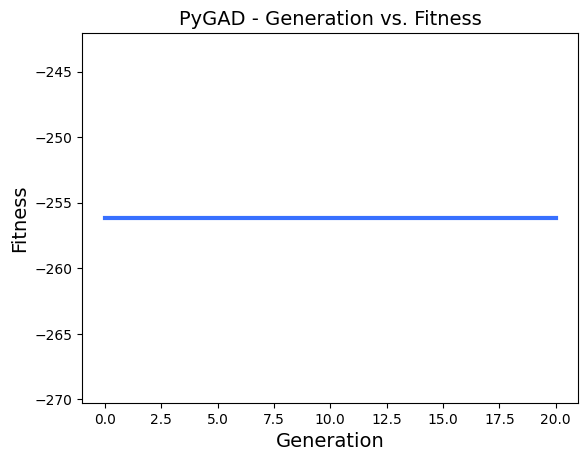

Parameters of best solution : [0. 2. 4. 1. 3.]
Fitness of the best solution = -149.72246633025193


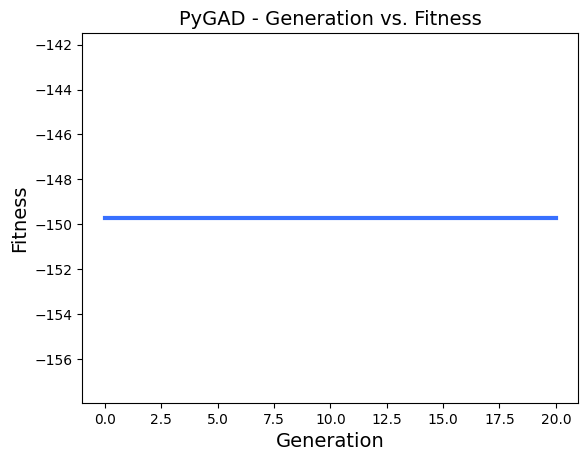

Parameters of best solution : [4. 3. 2. 1. 0.]
Fitness of the best solution = -213.45377384244733


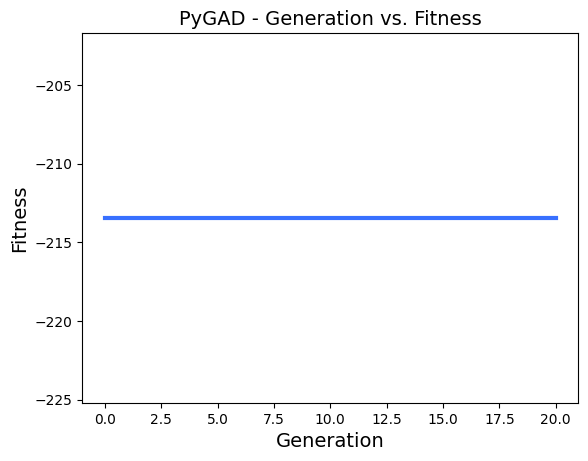

Parameters of best solution : [0. 3. 1. 2. 4.]
Fitness of the best solution = -256.16190323434324


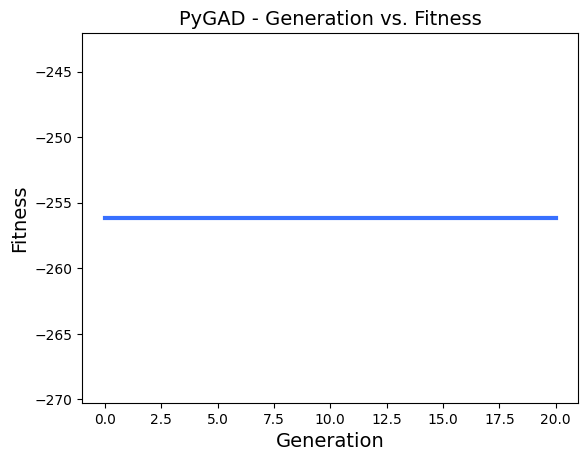

Parameters of best solution : [3. 1. 4. 2. 0.]
Fitness of the best solution = -149.72246633025193


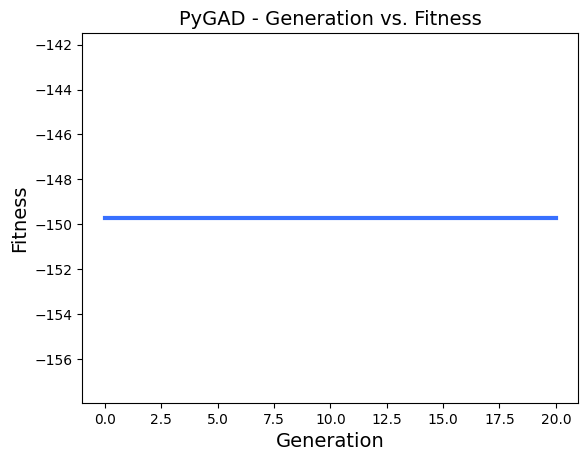

In [91]:
effectivness_graph,counters, mean_time, all_results = effectiveness_genetic(graphs_small)

In [92]:
#effectivness table for each of large graphs
df_small = {
  "Graph": [1, 2, 3],
  "Time": [effectivness_graph[0][2], effectivness_graph[1][2], effectivness_graph[2][2]],
    "Effectivness(%)" : [round((effectivness_graph[0][0]/effectivness_graph[0][1])*100,2), round((effectivness_graph[1][0]/effectivness_graph[1][1])*100,2),round((effectivness_graph[2][0]/effectivness_graph[2][1])*100,2)]}

table_small = pd.DataFrame(df_small)
table_small

Graph      Time  Effectivness(%)
0      1  0.137526            100.0
1      2  0.141676            100.0
2      3  0.144172            100.0

In [94]:
small_results.append(counters)

In [95]:
small_results.append(mean_time)

In [96]:
small_results

[100, 0.1412300658226013]

#### 2.1.2 Medium inputs.

In [97]:
medium_results = []

Parameters of best solution : [5. 7. 4. 6. 2. 3. 1. 8. 0. 9.]
Fitness of the best solution = -321.6398485576058


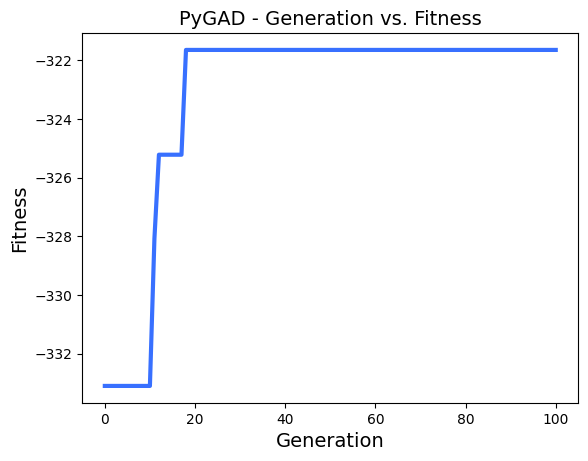

Parameters of best solution : [9. 5. 7. 4. 6. 2. 3. 1. 8. 0.]
Fitness of the best solution = -321.6398485576057


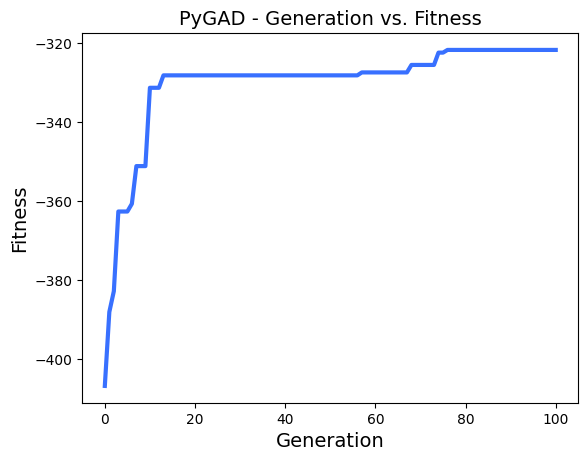

Parameters of best solution : [9. 2. 6. 1. 0. 8. 3. 7. 4. 5.]
Fitness of the best solution = -325.7413270943398


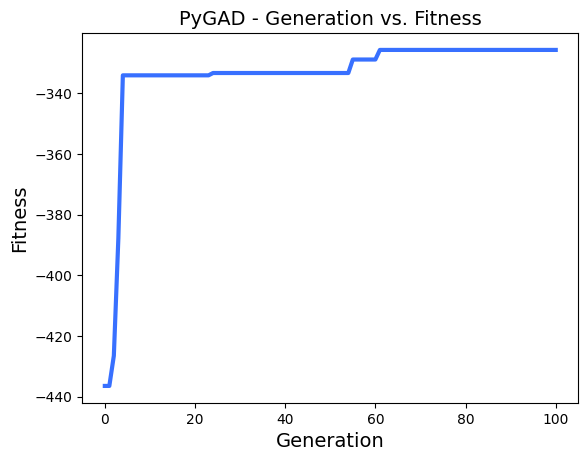

Parameters of best solution : [9. 8. 7. 6. 5. 4. 1. 2. 3. 0.]
Fitness of the best solution = -280.3072206992613


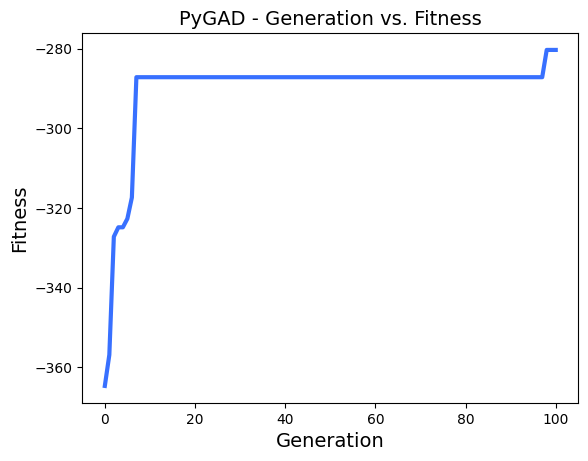

Parameters of best solution : [3. 2. 6. 4. 7. 5. 9. 0. 8. 1.]
Fitness of the best solution = -321.6398485576058


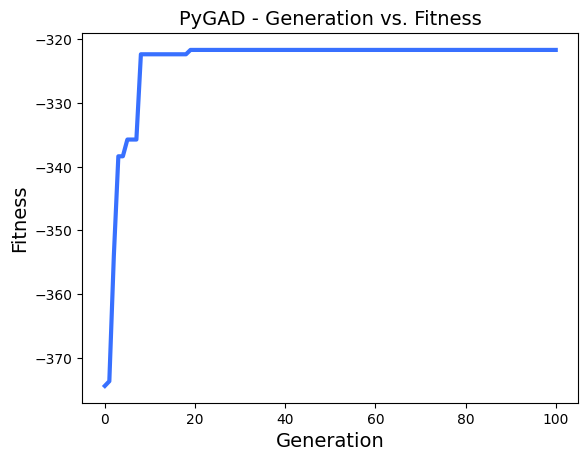

Parameters of best solution : [3. 2. 6. 4. 7. 5. 9. 0. 8. 1.]
Fitness of the best solution = -321.6398485576058


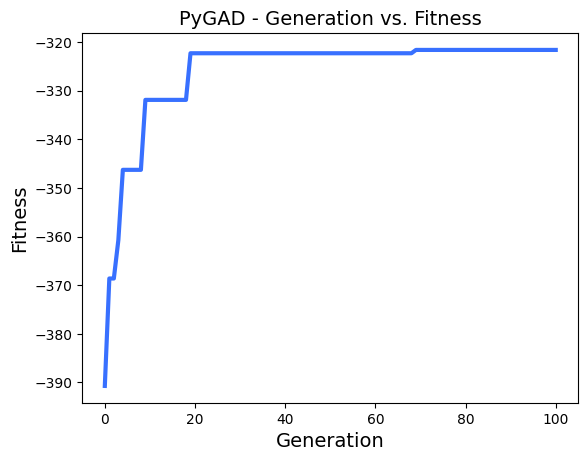

Parameters of best solution : [4. 5. 6. 7. 8. 9. 0. 3. 2. 1.]
Fitness of the best solution = -280.3072206992613


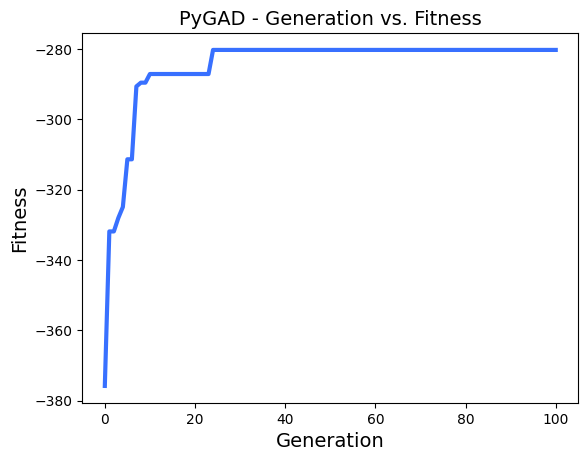

Parameters of best solution : [4. 6. 2. 3. 1. 8. 0. 9. 5. 7.]
Fitness of the best solution = -321.6398485576058


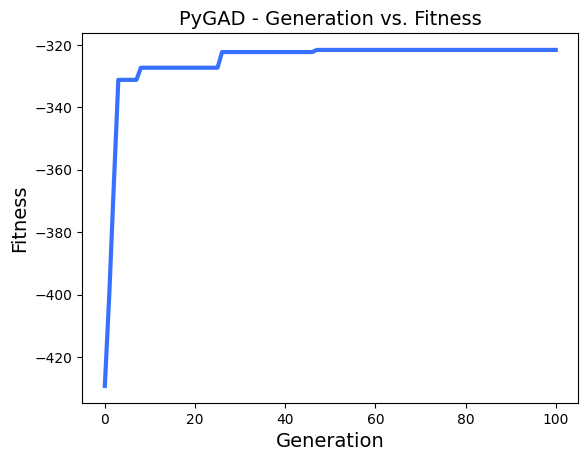

Parameters of best solution : [3. 2. 6. 4. 7. 5. 9. 0. 8. 1.]
Fitness of the best solution = -321.6398485576058


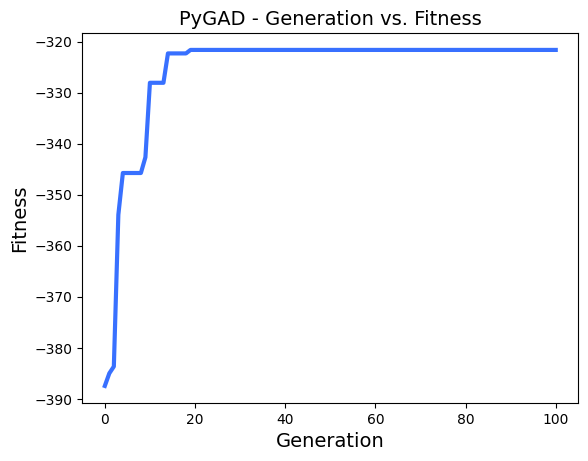

Parameters of best solution : [9. 2. 6. 1. 0. 8. 3. 7. 4. 5.]
Fitness of the best solution = -325.7413270943398


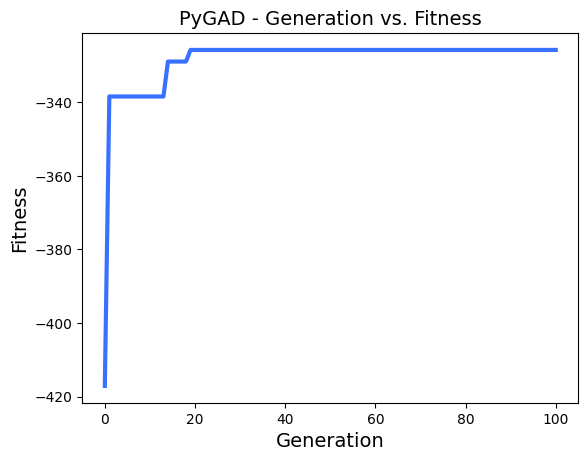

Parameters of best solution : [9. 0. 3. 2. 1. 4. 5. 6. 7. 8.]
Fitness of the best solution = -280.3072206992613


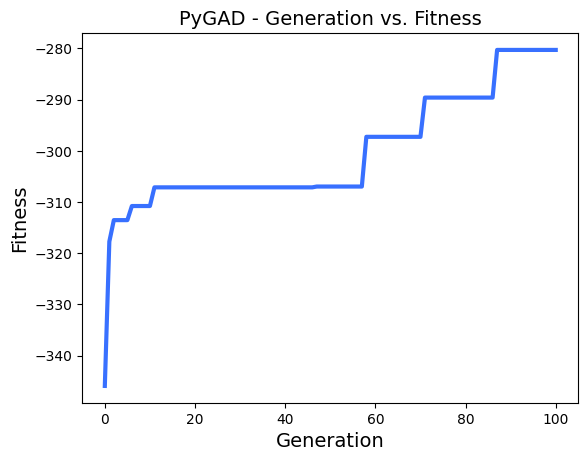

Parameters of best solution : [1. 6. 2. 9. 5. 4. 7. 3. 8. 0.]
Fitness of the best solution = -325.74132709433985


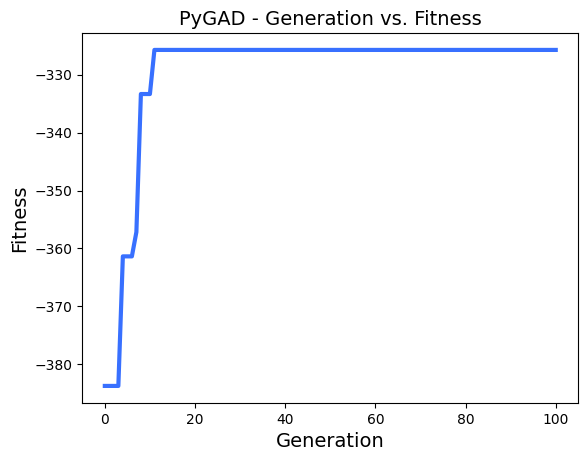

Parameters of best solution : [9. 5. 4. 7. 3. 8. 0. 1. 6. 2.]
Fitness of the best solution = -325.7413270943398


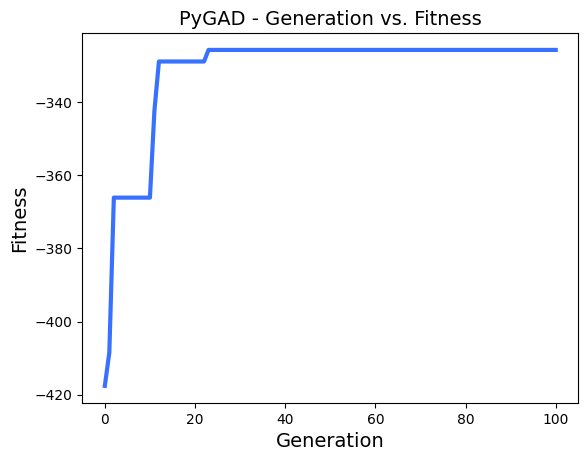

Parameters of best solution : [1. 8. 0. 9. 5. 7. 4. 6. 2. 3.]
Fitness of the best solution = -321.6398485576058


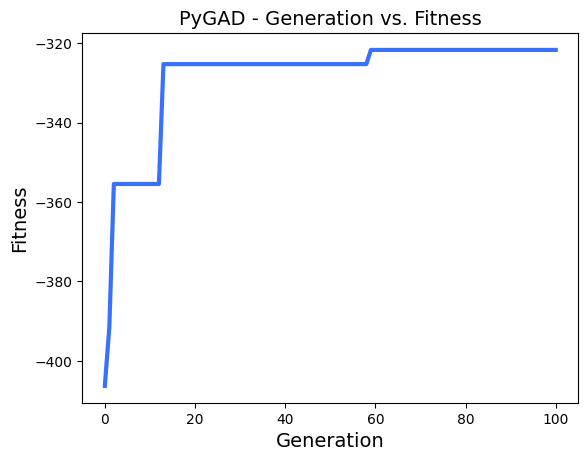

Parameters of best solution : [8. 7. 6. 5. 4. 1. 2. 3. 0. 9.]
Fitness of the best solution = -280.3072206992613


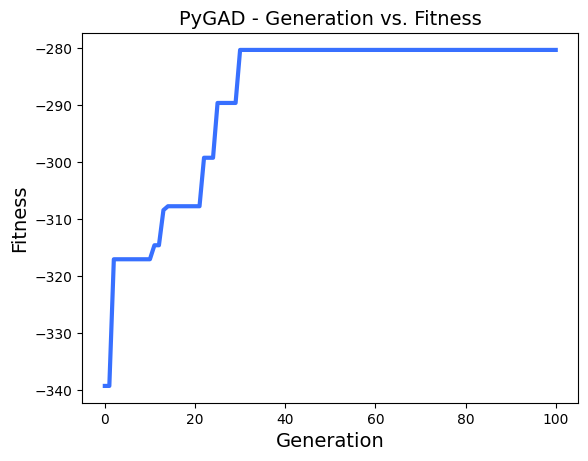

Parameters of best solution : [1. 8. 0. 9. 5. 7. 4. 6. 2. 3.]
Fitness of the best solution = -321.6398485576058


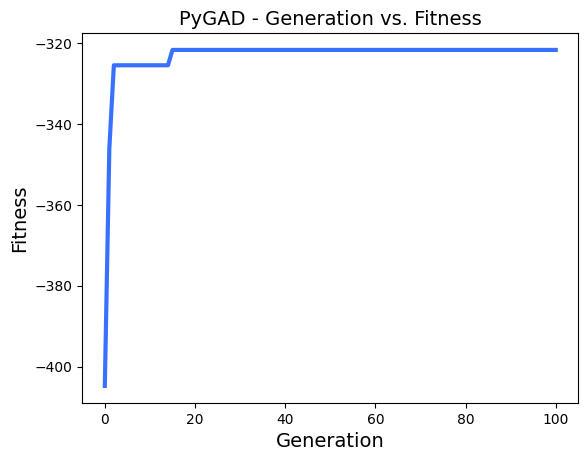

Parameters of best solution : [5. 4. 1. 2. 3. 0. 9. 8. 7. 6.]
Fitness of the best solution = -280.3072206992613


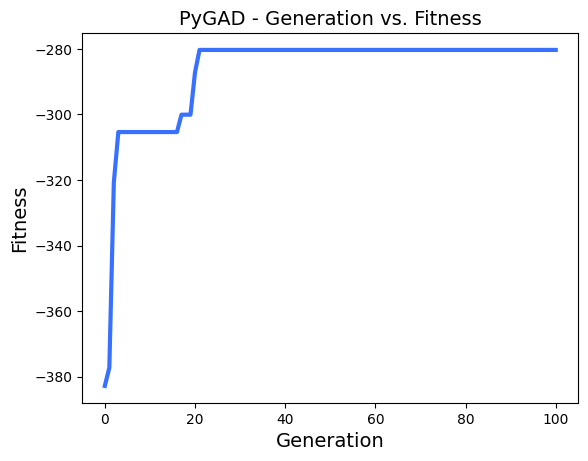

Parameters of best solution : [1. 8. 0. 9. 5. 7. 4. 6. 2. 3.]
Fitness of the best solution = -321.6398485576058


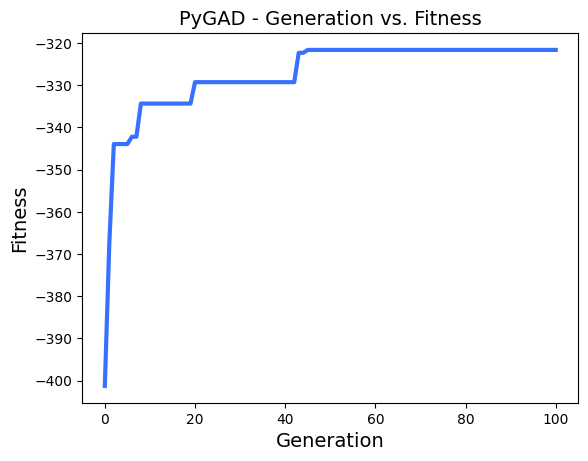

Parameters of best solution : [5. 7. 4. 6. 2. 3. 1. 8. 0. 9.]
Fitness of the best solution = -321.6398485576058


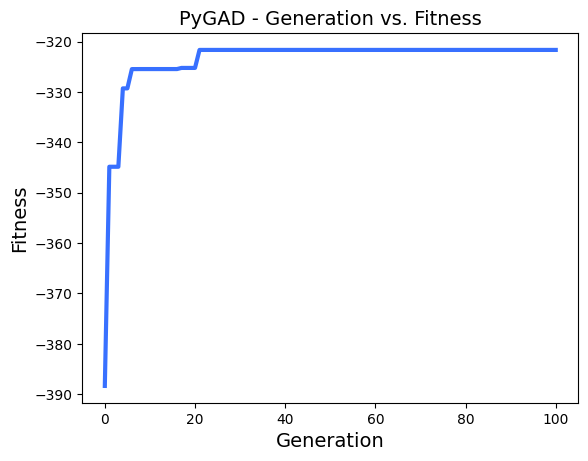

Parameters of best solution : [0. 8. 1. 3. 2. 6. 4. 7. 5. 9.]
Fitness of the best solution = -321.6398485576058


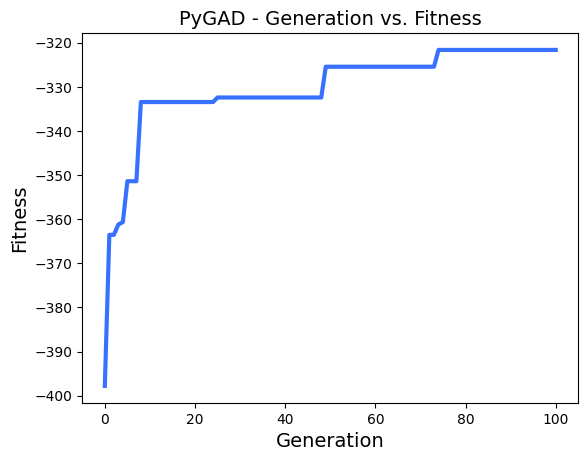

Parameters of best solution : [9. 8. 7. 6. 5. 4. 1. 2. 3. 0.]
Fitness of the best solution = -280.3072206992613


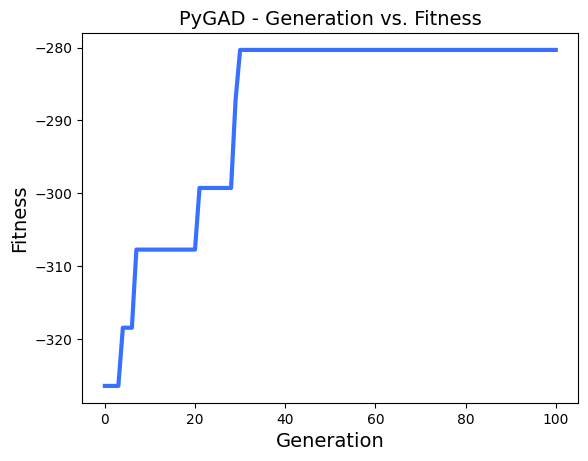

Parameters of best solution : [5. 7. 4. 6. 2. 3. 1. 8. 0. 9.]
Fitness of the best solution = -321.6398485576058


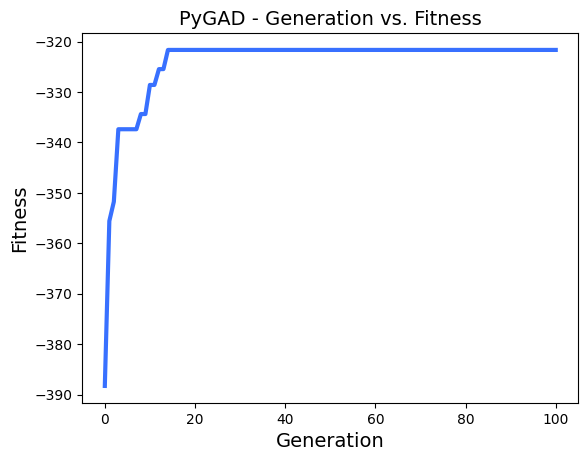

Parameters of best solution : [9. 8. 7. 6. 5. 4. 1. 2. 3. 0.]
Fitness of the best solution = -280.3072206992613


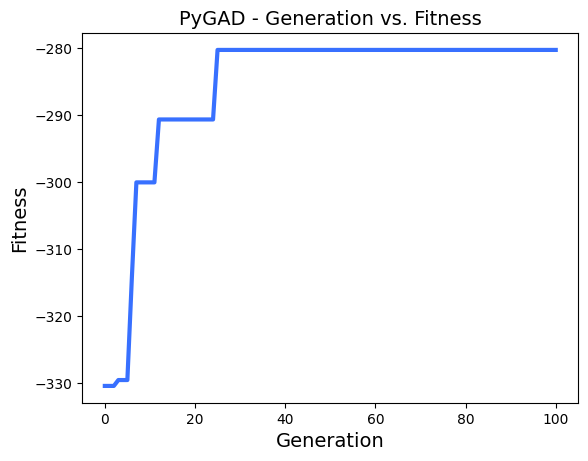

Parameters of best solution : [2. 9. 5. 4. 7. 3. 8. 0. 1. 6.]
Fitness of the best solution = -325.7413270943398


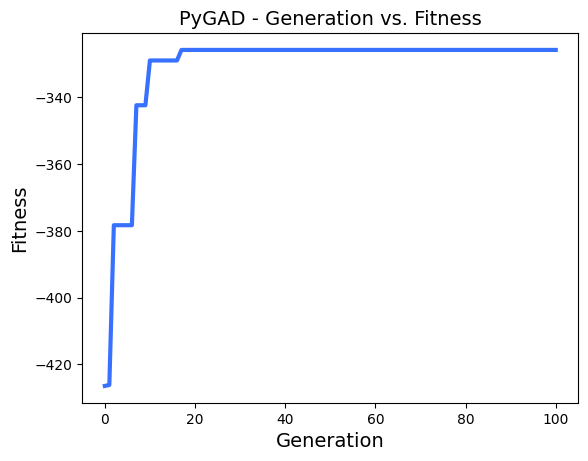

Parameters of best solution : [3. 2. 6. 4. 7. 5. 9. 0. 8. 1.]
Fitness of the best solution = -321.6398485576058


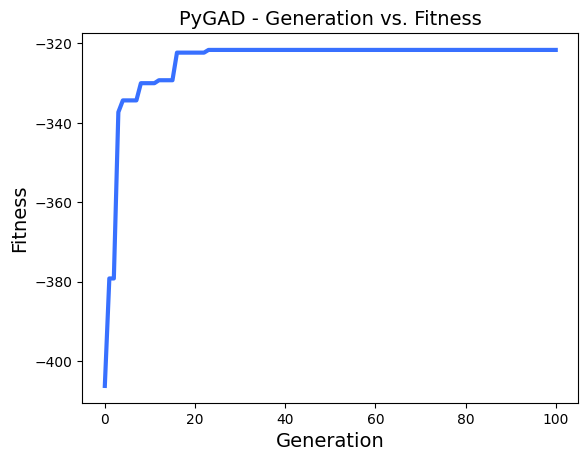

Parameters of best solution : [5. 7. 4. 6. 2. 3. 1. 8. 0. 9.]
Fitness of the best solution = -321.6398485576058


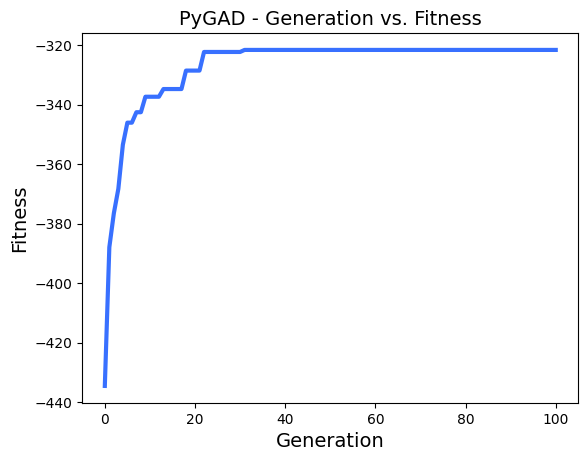

Parameters of best solution : [8. 7. 6. 5. 4. 1. 2. 3. 0. 9.]
Fitness of the best solution = -280.3072206992613


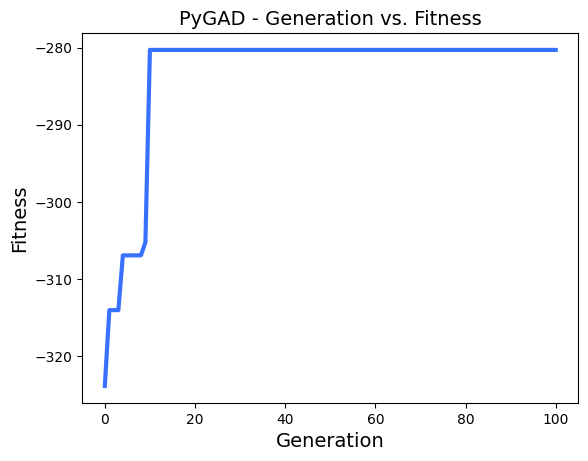

Parameters of best solution : [3. 1. 8. 0. 9. 5. 7. 4. 6. 2.]
Fitness of the best solution = -321.6398485576058


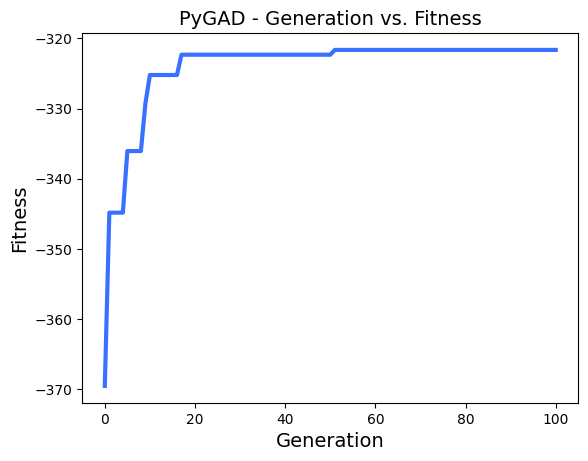

Parameters of best solution : [9. 5. 7. 4. 6. 2. 3. 1. 8. 0.]
Fitness of the best solution = -321.6398485576057


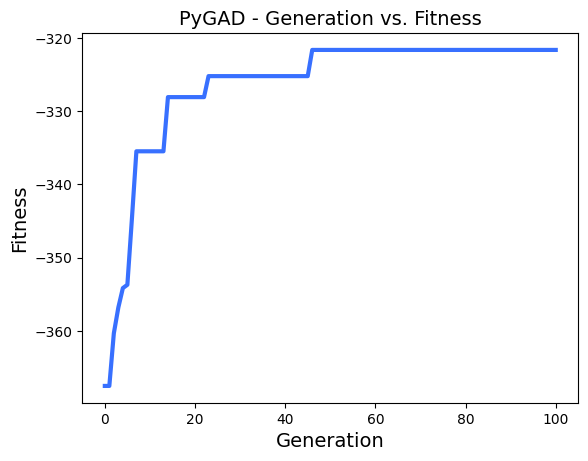

Parameters of best solution : [3. 2. 1. 4. 5. 6. 7. 8. 9. 0.]
Fitness of the best solution = -280.3072206992613


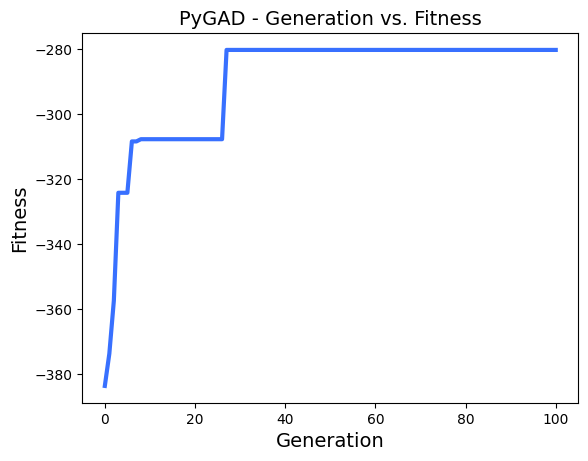

Parameters of best solution : [0. 3. 2. 1. 4. 5. 6. 7. 8. 9.]
Fitness of the best solution = -280.30722069926134


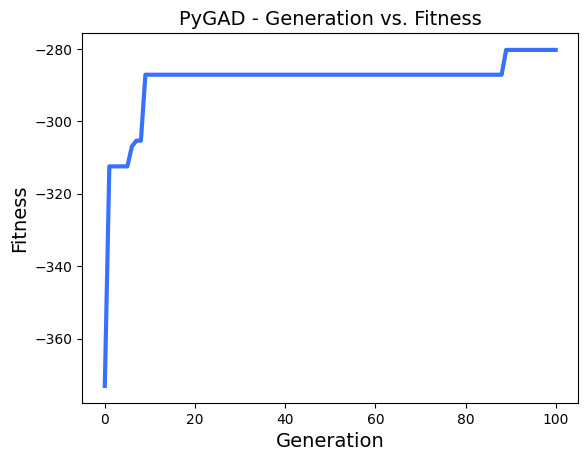

Parameters of best solution : [2. 9. 5. 4. 7. 3. 8. 0. 1. 6.]
Fitness of the best solution = -325.7413270943398


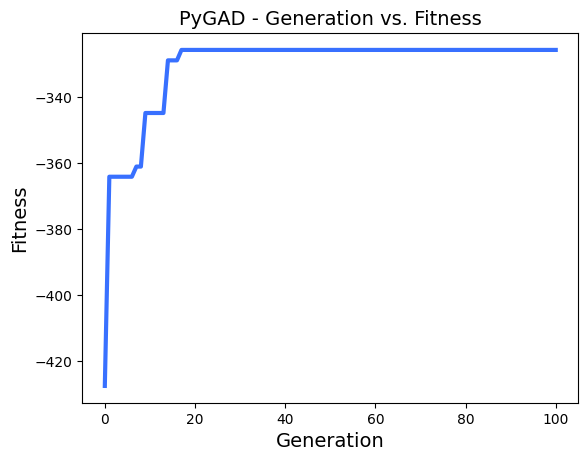

Parameters of best solution : [9. 0. 3. 2. 1. 4. 5. 6. 7. 8.]
Fitness of the best solution = -280.3072206992613


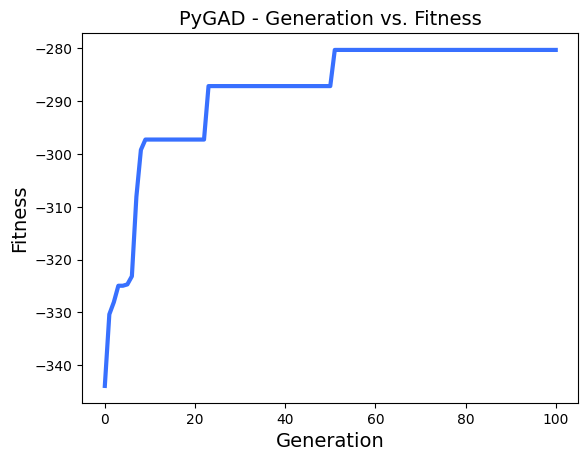

Parameters of best solution : [9. 0. 3. 2. 1. 4. 5. 6. 7. 8.]
Fitness of the best solution = -280.3072206992613


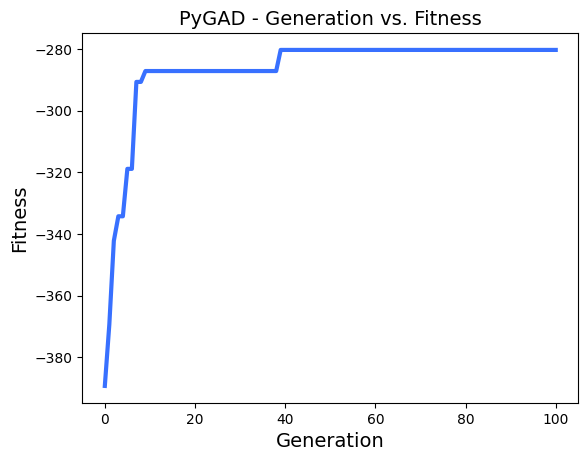

Parameters of best solution : [3. 2. 6. 4. 7. 5. 9. 0. 8. 1.]
Fitness of the best solution = -321.6398485576058


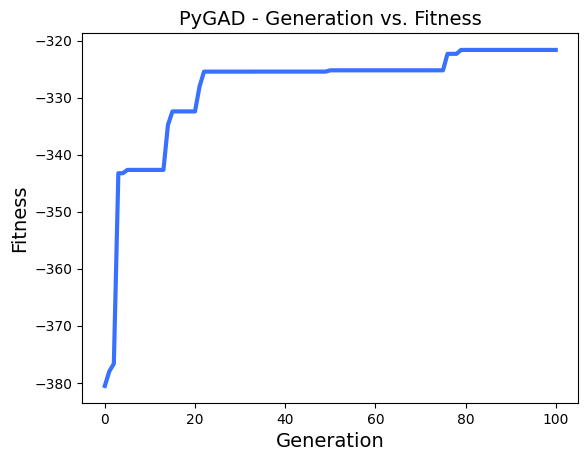

Parameters of best solution : [0. 3. 2. 1. 4. 5. 6. 7. 8. 9.]
Fitness of the best solution = -280.30722069926134


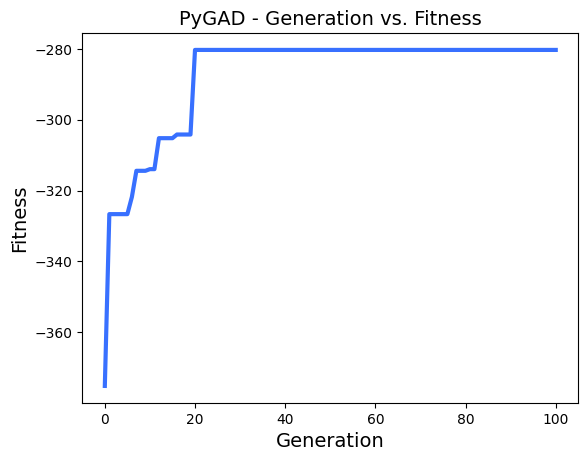

Parameters of best solution : [1. 0. 8. 3. 7. 4. 5. 9. 2. 6.]
Fitness of the best solution = -325.74132709433985


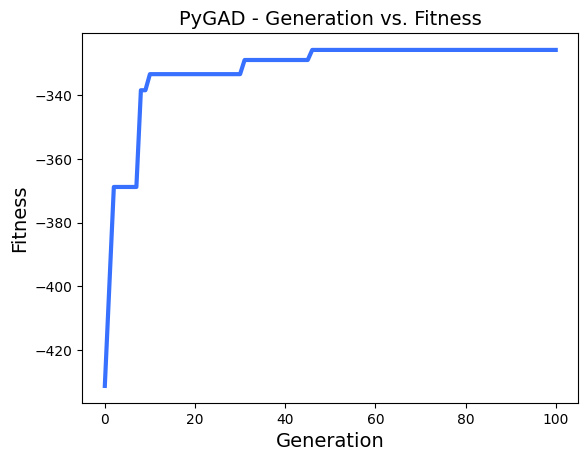

Parameters of best solution : [5. 4. 1. 2. 3. 0. 9. 8. 7. 6.]
Fitness of the best solution = -280.3072206992613


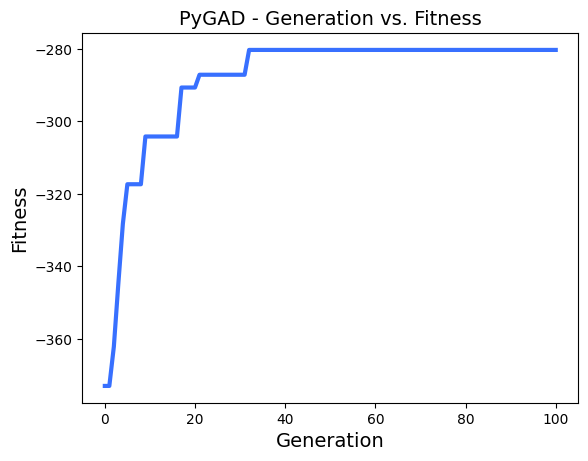

Parameters of best solution : [8. 7. 6. 5. 4. 1. 0. 2. 3. 9.]
Fitness of the best solution = -287.1532110304816


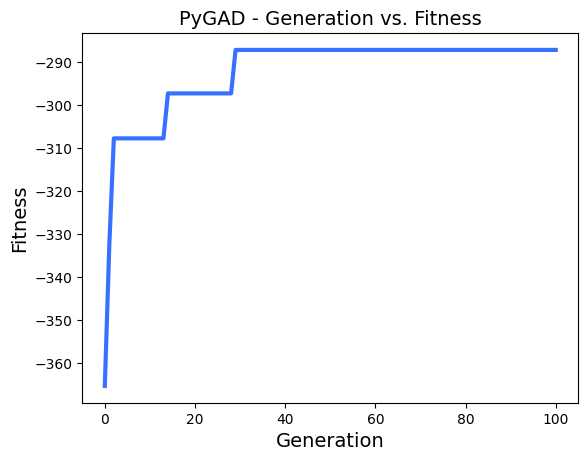

Parameters of best solution : [8. 7. 6. 5. 4. 1. 2. 3. 0. 9.]
Fitness of the best solution = -280.3072206992613


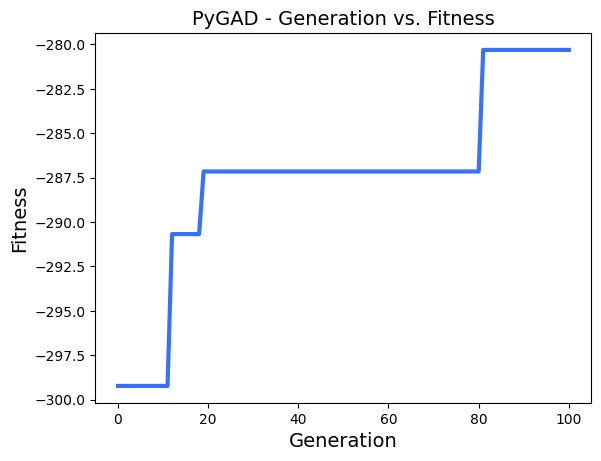

Parameters of best solution : [5. 7. 4. 6. 2. 3. 1. 8. 0. 9.]
Fitness of the best solution = -321.6398485576058


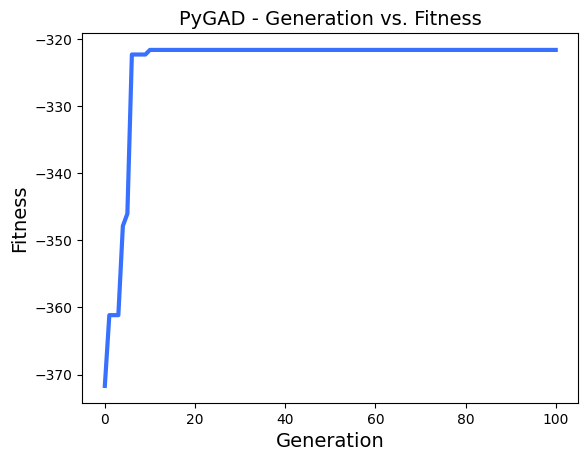

Parameters of best solution : [7. 8. 9. 0. 3. 2. 1. 4. 5. 6.]
Fitness of the best solution = -280.3072206992613


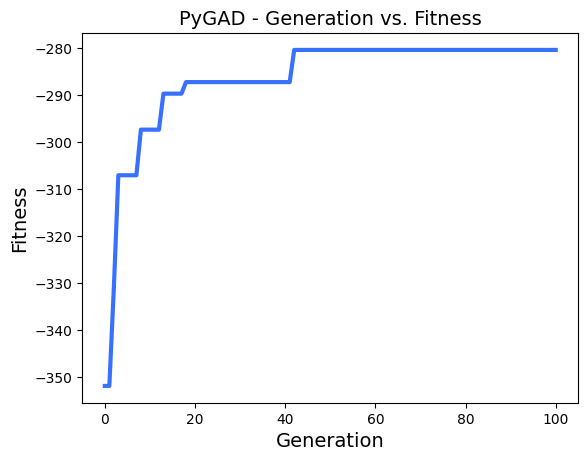

Parameters of best solution : [9. 8. 7. 6. 5. 4. 1. 2. 3. 0.]
Fitness of the best solution = -280.3072206992613


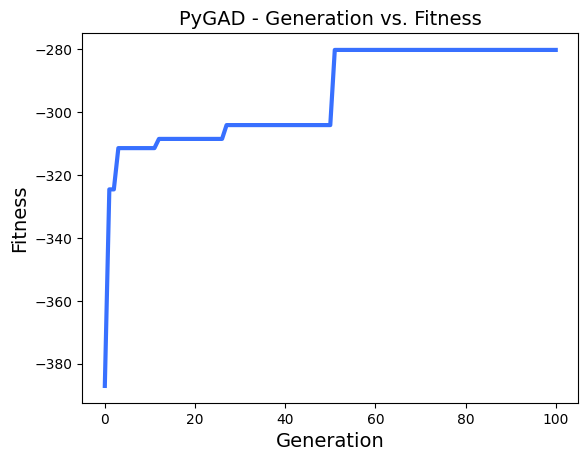

Parameters of best solution : [2. 9. 5. 4. 7. 3. 8. 0. 1. 6.]
Fitness of the best solution = -325.7413270943398


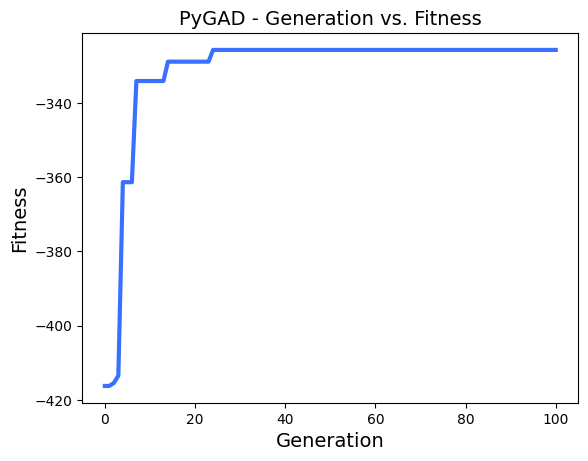

Parameters of best solution : [4. 5. 6. 7. 8. 9. 0. 3. 2. 1.]
Fitness of the best solution = -280.3072206992613


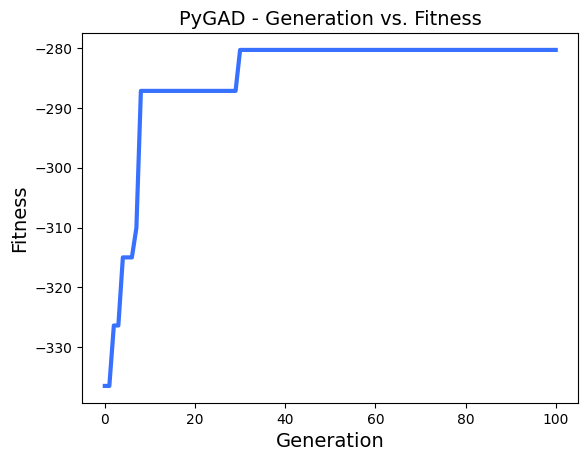

Parameters of best solution : [4. 5. 6. 7. 8. 9. 0. 3. 2. 1.]
Fitness of the best solution = -280.3072206992613


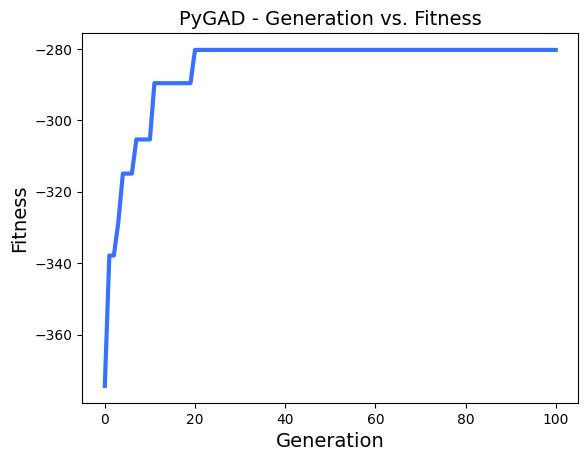

Parameters of best solution : [7. 8. 9. 0. 3. 2. 1. 4. 5. 6.]
Fitness of the best solution = -280.3072206992613


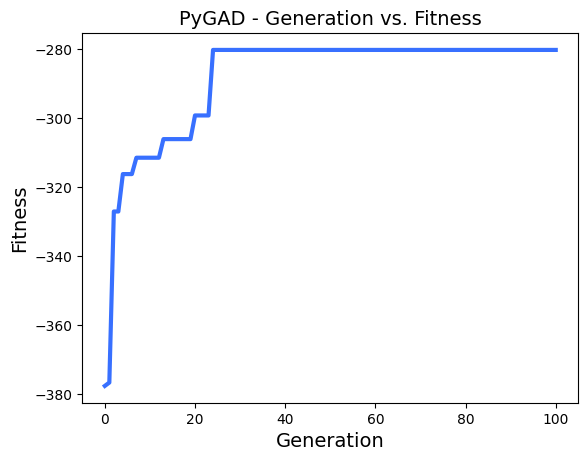

Parameters of best solution : [9. 0. 3. 2. 1. 4. 5. 6. 7. 8.]
Fitness of the best solution = -280.3072206992613


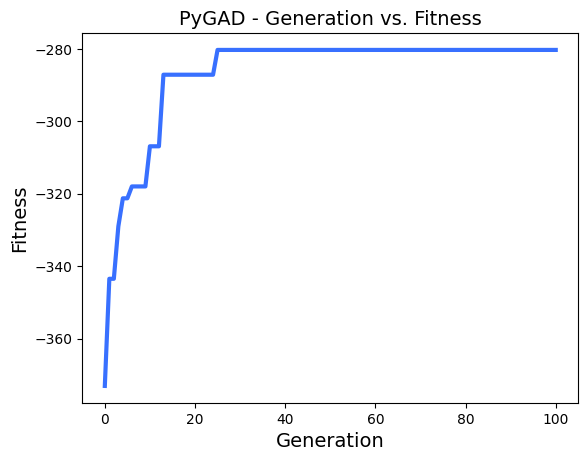

Parameters of best solution : [9. 0. 3. 2. 1. 4. 5. 6. 7. 8.]
Fitness of the best solution = -280.3072206992613


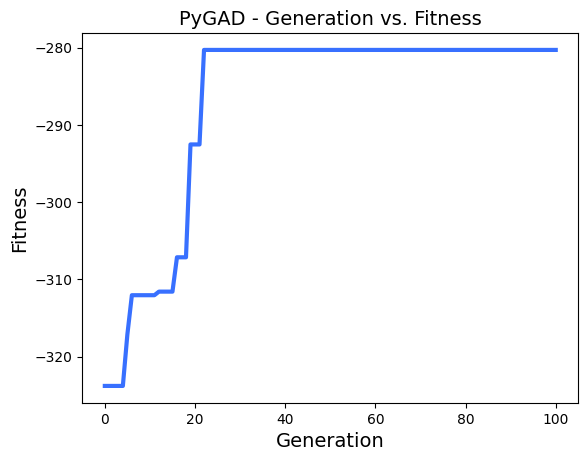

Parameters of best solution : [8. 0. 1. 6. 2. 9. 5. 4. 7. 3.]
Fitness of the best solution = -325.74132709433985


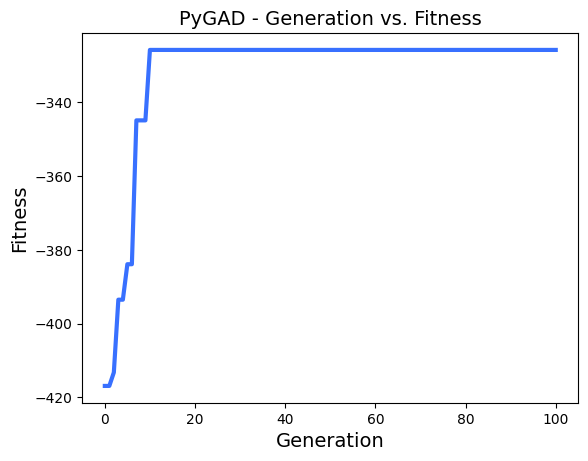

Parameters of best solution : [6. 5. 4. 1. 2. 3. 0. 9. 8. 7.]
Fitness of the best solution = -280.30722069926134


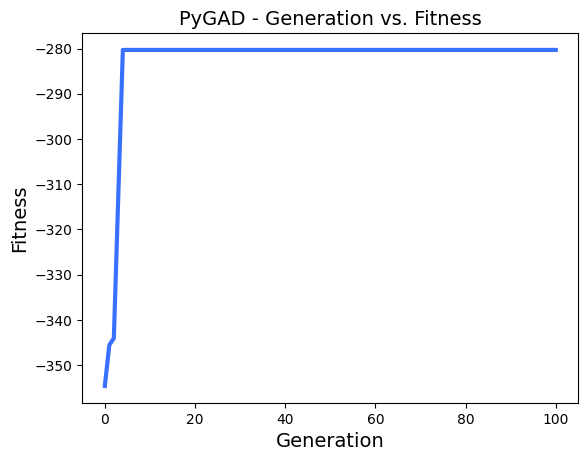

Parameters of best solution : [9. 0. 3. 2. 1. 4. 5. 6. 7. 8.]
Fitness of the best solution = -280.3072206992613


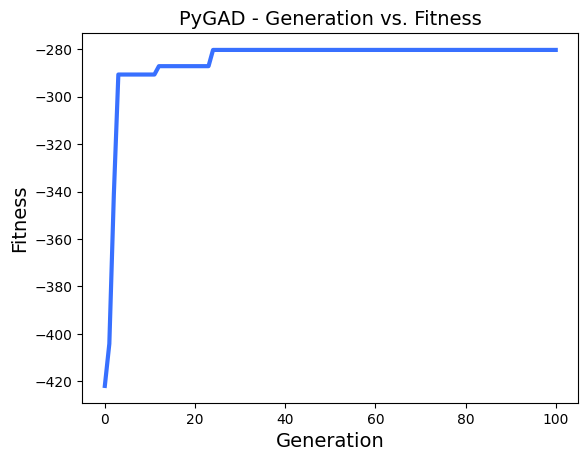

Parameters of best solution : [3. 2. 6. 4. 7. 5. 9. 0. 8. 1.]
Fitness of the best solution = -321.6398485576058


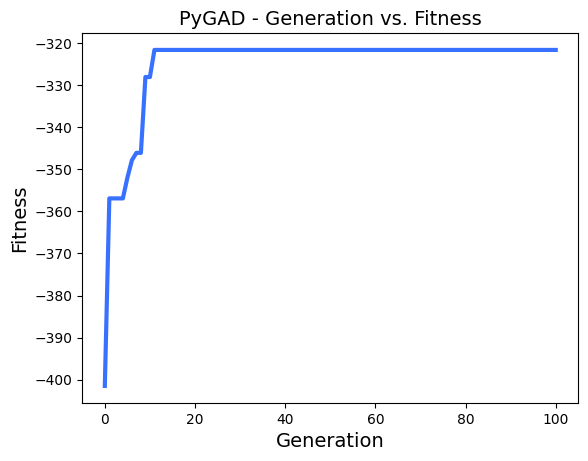

Parameters of best solution : [2. 9. 5. 4. 7. 3. 8. 0. 1. 6.]
Fitness of the best solution = -325.7413270943398


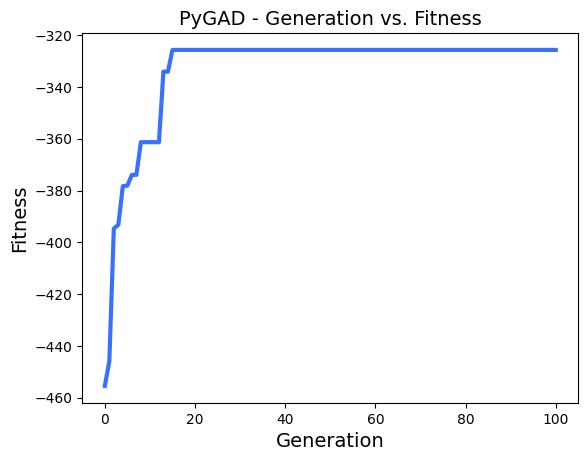

Parameters of best solution : [8. 0. 1. 6. 2. 9. 5. 4. 7. 3.]
Fitness of the best solution = -325.74132709433985


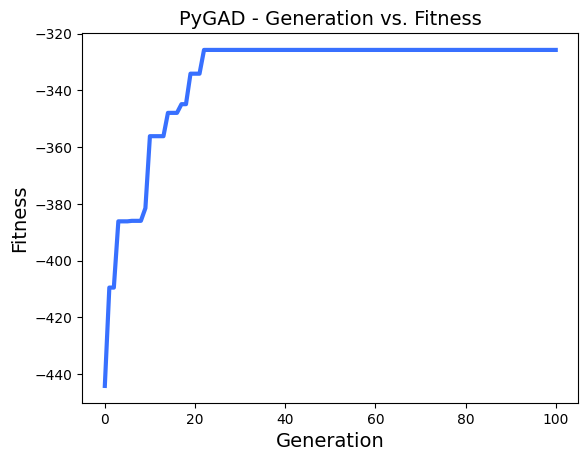

Parameters of best solution : [9. 0. 3. 2. 1. 4. 5. 6. 7. 8.]
Fitness of the best solution = -280.3072206992613


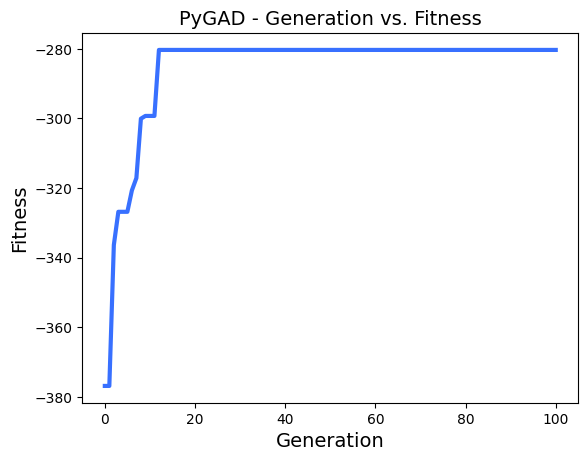

Parameters of best solution : [9. 2. 6. 1. 0. 8. 3. 7. 4. 5.]
Fitness of the best solution = -325.7413270943398


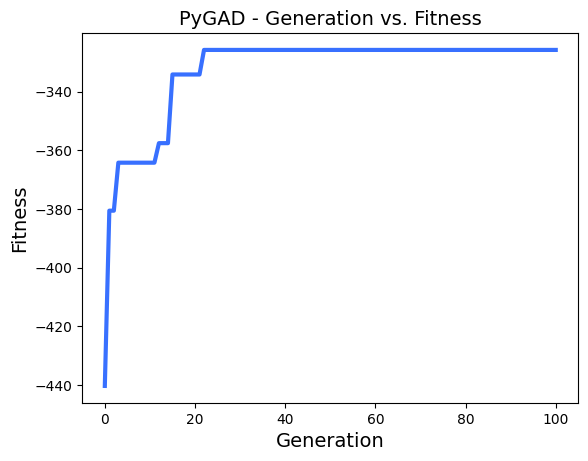

Parameters of best solution : [9. 2. 6. 1. 0. 8. 3. 7. 4. 5.]
Fitness of the best solution = -325.7413270943398


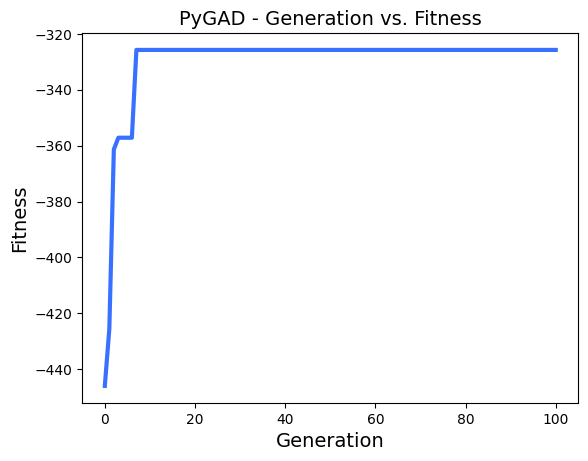

Parameters of best solution : [9. 2. 6. 1. 0. 8. 3. 7. 4. 5.]
Fitness of the best solution = -325.7413270943398


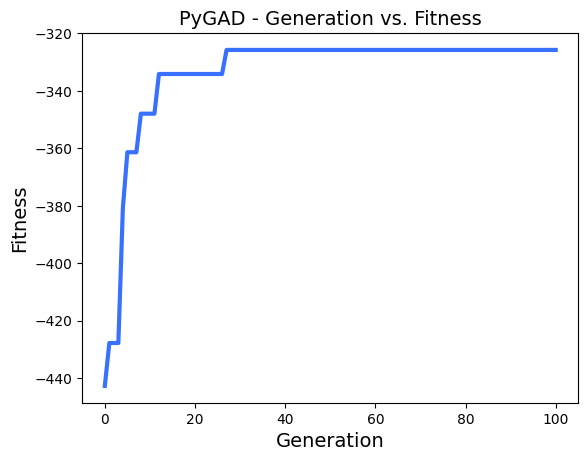

Parameters of best solution : [2. 6. 1. 0. 8. 3. 7. 4. 5. 9.]
Fitness of the best solution = -325.74132709433985


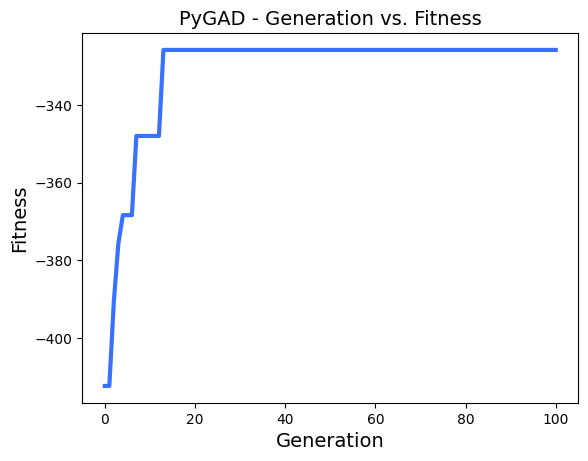

Parameters of best solution : [6. 7. 8. 9. 0. 3. 2. 1. 4. 5.]
Fitness of the best solution = -280.3072206992613


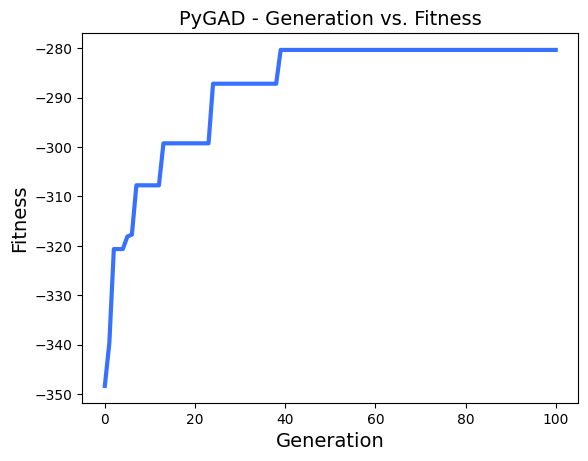

Parameters of best solution : [2. 6. 1. 0. 8. 3. 7. 4. 5. 9.]
Fitness of the best solution = -325.74132709433985


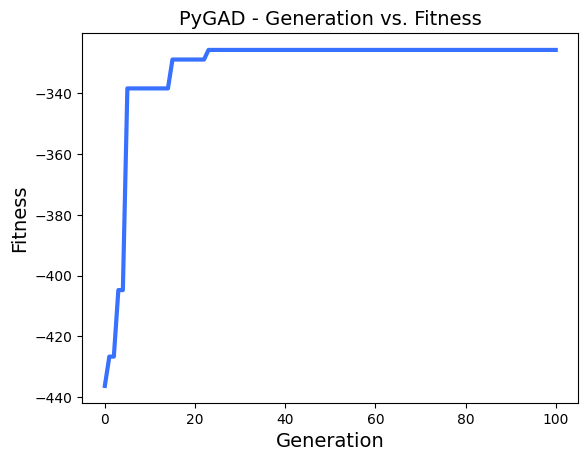

Parameters of best solution : [9. 2. 6. 1. 0. 8. 3. 7. 4. 5.]
Fitness of the best solution = -325.7413270943398


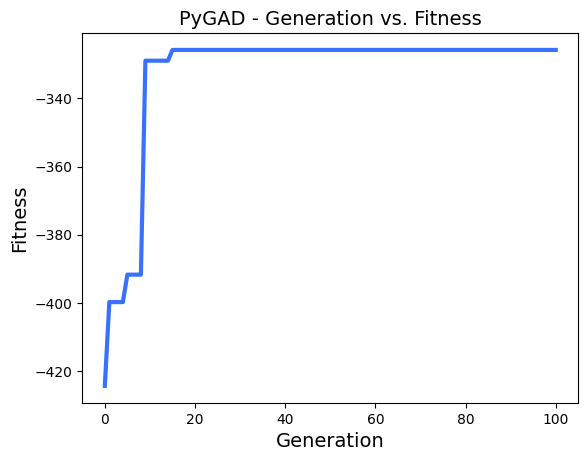

Parameters of best solution : [9. 0. 3. 2. 1. 4. 5. 6. 7. 8.]
Fitness of the best solution = -280.3072206992613


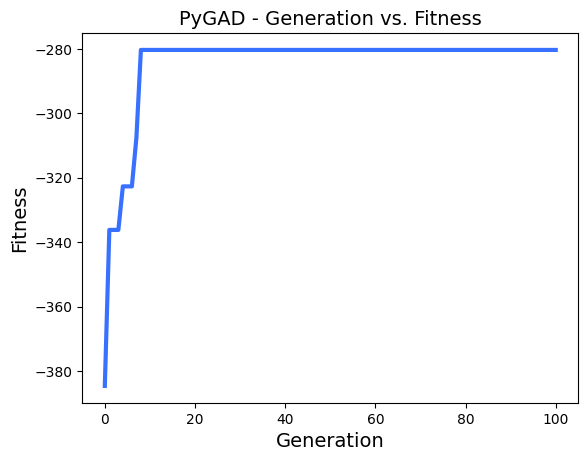

Parameters of best solution : [5. 9. 2. 6. 1. 0. 8. 3. 7. 4.]
Fitness of the best solution = -325.74132709433985


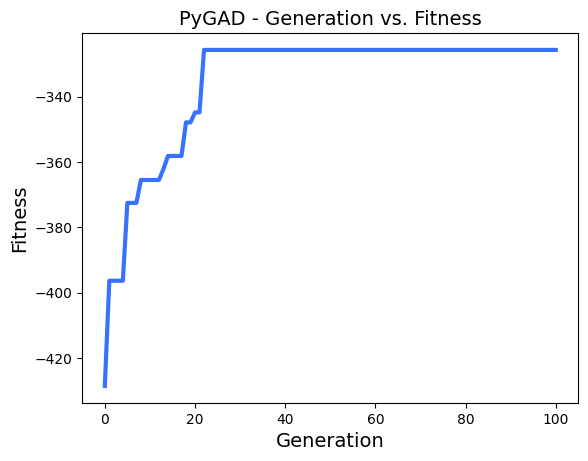

Parameters of best solution : [2. 9. 5. 4. 7. 3. 8. 0. 1. 6.]
Fitness of the best solution = -325.7413270943398


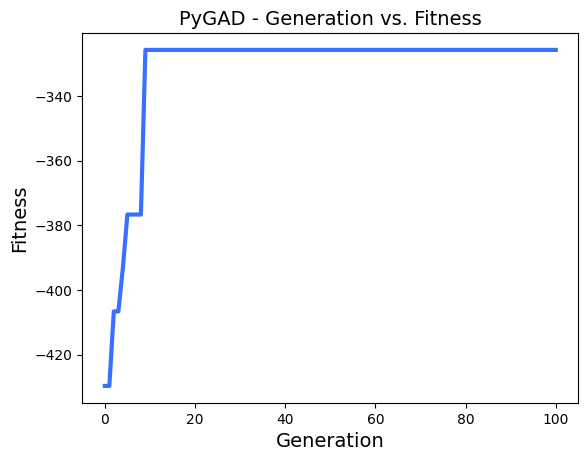

Parameters of best solution : [9. 5. 4. 7. 3. 8. 0. 1. 6. 2.]
Fitness of the best solution = -325.7413270943398


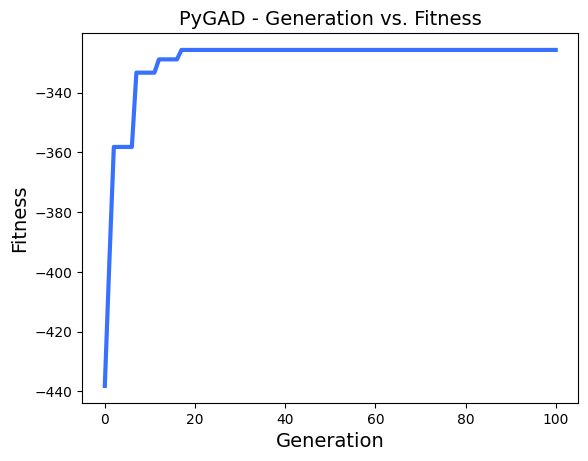

Parameters of best solution : [8. 7. 6. 5. 4. 1. 2. 3. 0. 9.]
Fitness of the best solution = -280.3072206992613


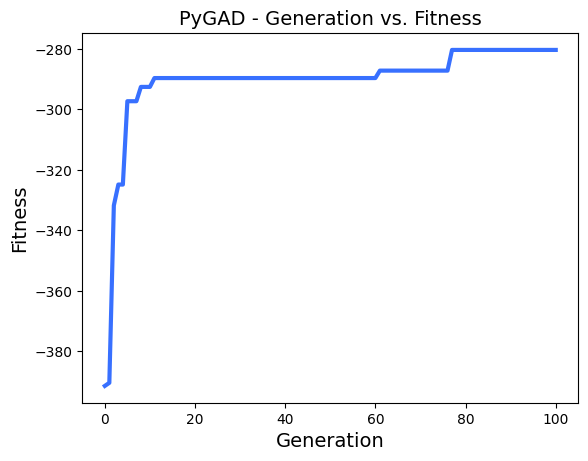

Parameters of best solution : [9. 8. 7. 6. 5. 4. 1. 2. 3. 0.]
Fitness of the best solution = -280.3072206992613


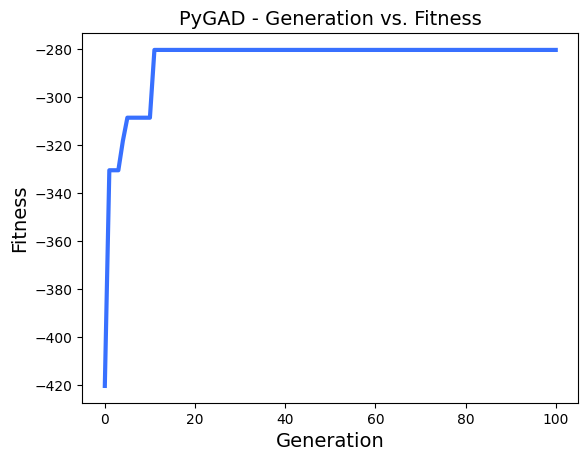

Parameters of best solution : [9. 2. 6. 1. 0. 8. 3. 7. 4. 5.]
Fitness of the best solution = -325.7413270943398


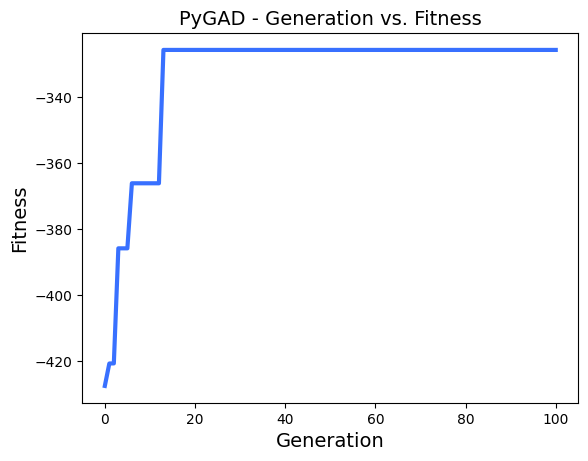

Parameters of best solution : [8. 0. 1. 6. 2. 9. 5. 4. 7. 3.]
Fitness of the best solution = -325.74132709433985


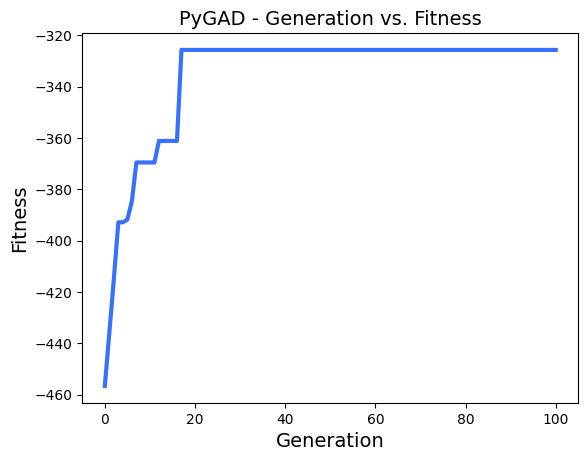

Parameters of best solution : [3. 2. 6. 4. 7. 5. 9. 0. 8. 1.]
Fitness of the best solution = -321.6398485576058


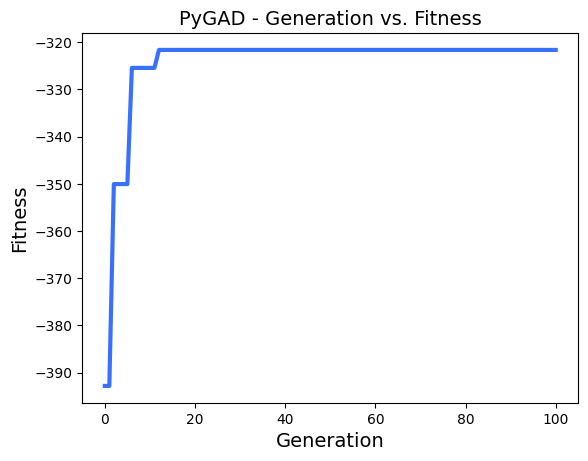

Parameters of best solution : [4. 7. 5. 9. 0. 8. 1. 3. 2. 6.]
Fitness of the best solution = -321.6398485576058


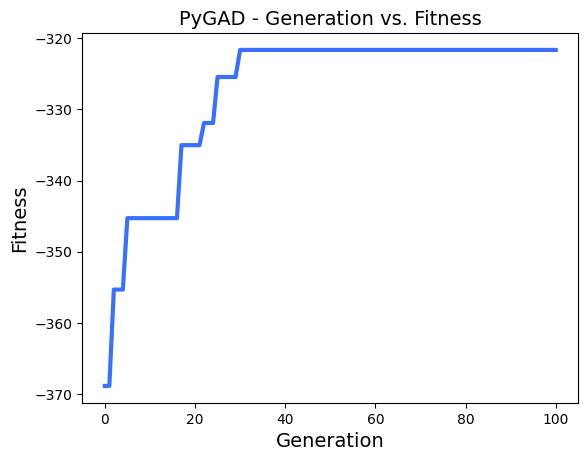

Parameters of best solution : [9. 2. 6. 1. 0. 8. 3. 7. 4. 5.]
Fitness of the best solution = -325.7413270943398


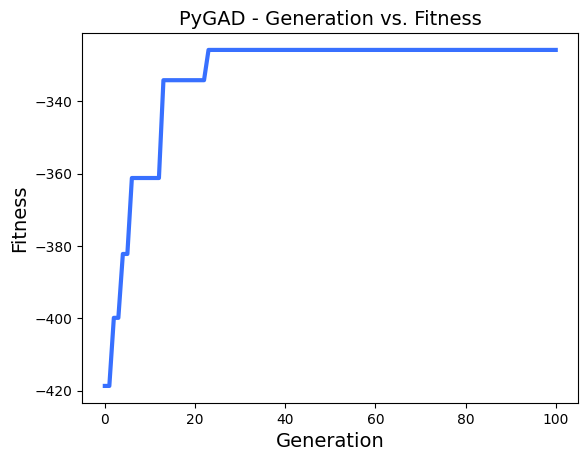

Parameters of best solution : [5. 7. 4. 6. 2. 3. 1. 8. 0. 9.]
Fitness of the best solution = -321.6398485576058


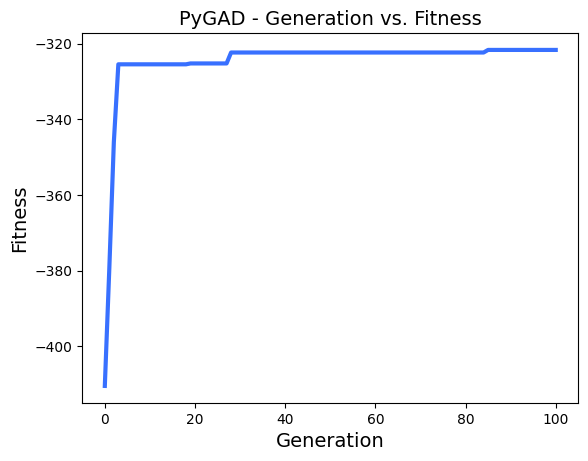

Parameters of best solution : [8. 0. 1. 6. 2. 9. 5. 4. 7. 3.]
Fitness of the best solution = -325.74132709433985


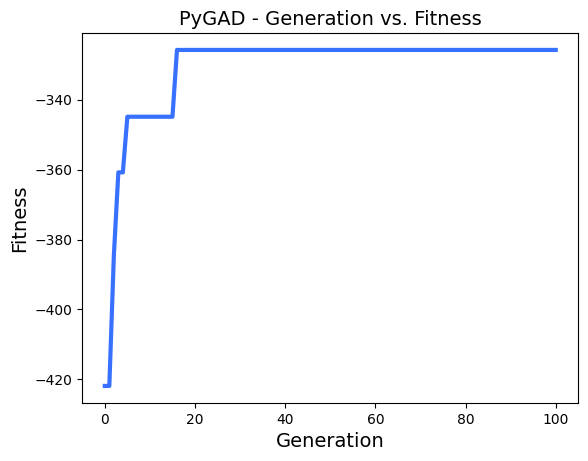

Parameters of best solution : [7. 6. 5. 4. 1. 2. 3. 0. 9. 8.]
Fitness of the best solution = -280.30722069926134


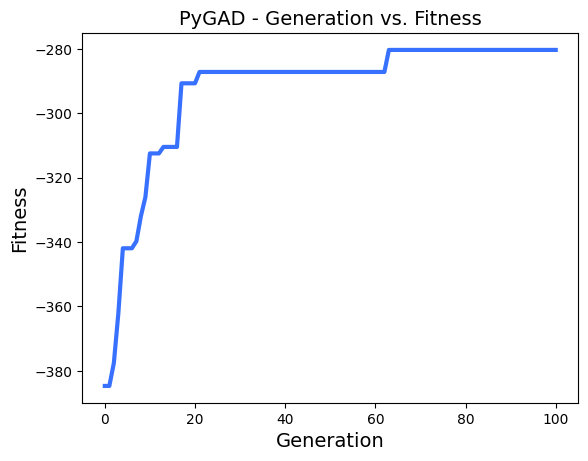

Parameters of best solution : [9. 5. 7. 4. 6. 2. 3. 1. 8. 0.]
Fitness of the best solution = -321.6398485576057


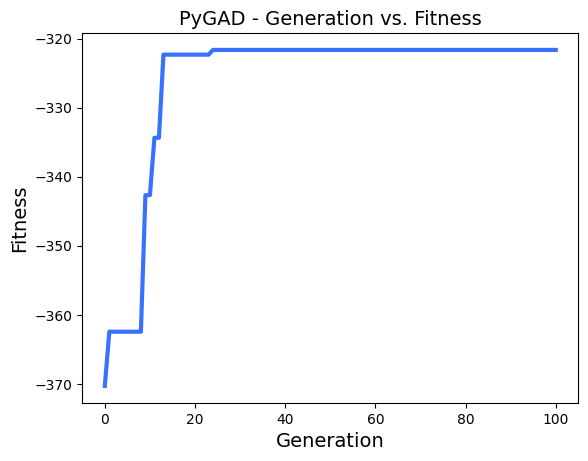

Parameters of best solution : [8. 7. 6. 5. 4. 1. 2. 3. 0. 9.]
Fitness of the best solution = -280.3072206992613


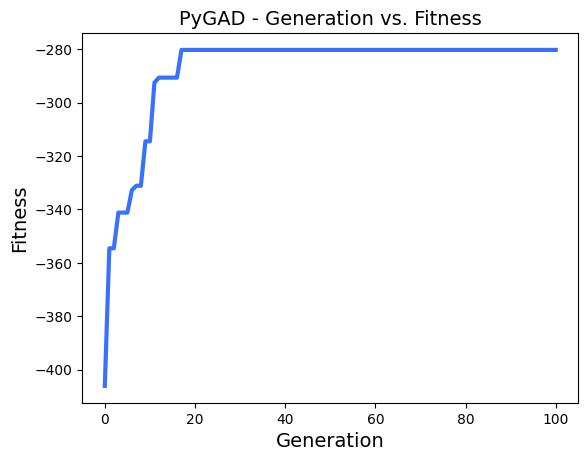

Parameters of best solution : [3. 2. 6. 4. 7. 5. 9. 0. 8. 1.]
Fitness of the best solution = -321.6398485576058


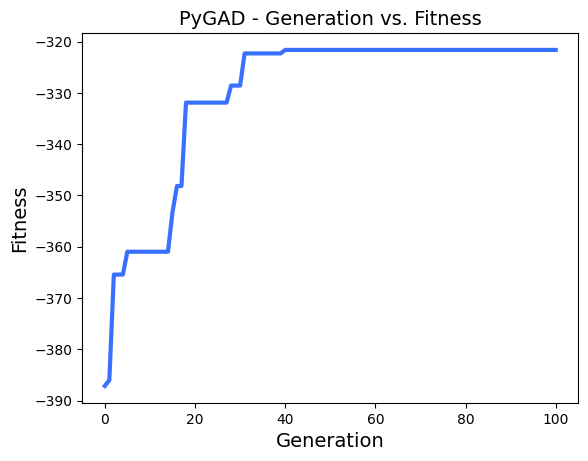

Parameters of best solution : [5. 7. 4. 6. 2. 3. 1. 8. 0. 9.]
Fitness of the best solution = -321.6398485576058


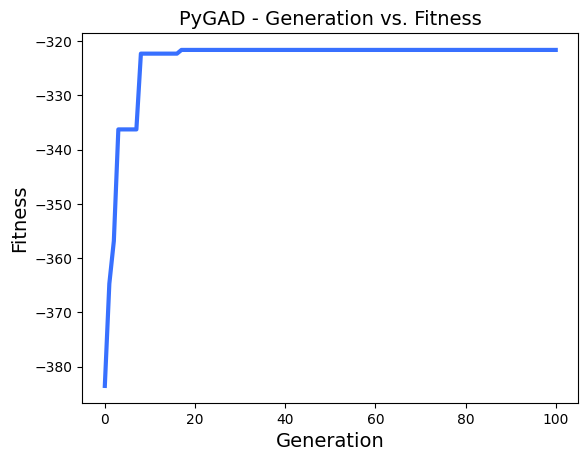

Parameters of best solution : [9. 5. 7. 4. 6. 2. 3. 1. 8. 0.]
Fitness of the best solution = -321.6398485576057


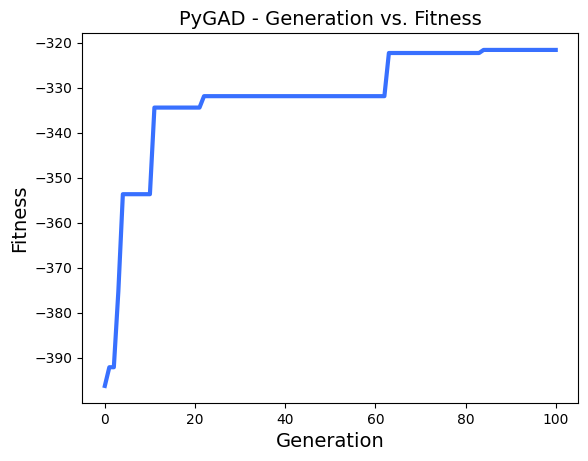

Parameters of best solution : [9. 5. 4. 7. 3. 8. 0. 1. 6. 2.]
Fitness of the best solution = -325.7413270943398


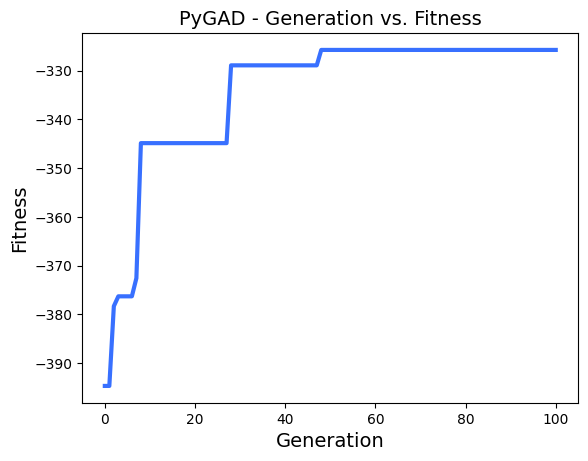

Parameters of best solution : [0. 8. 1. 3. 2. 6. 4. 7. 5. 9.]
Fitness of the best solution = -321.6398485576058


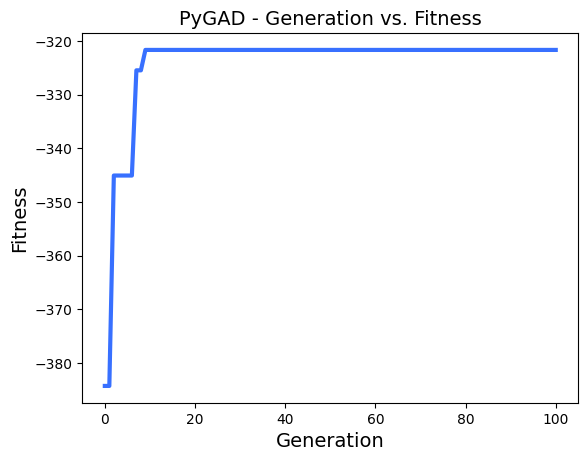

Parameters of best solution : [8. 7. 6. 5. 4. 1. 2. 3. 0. 9.]
Fitness of the best solution = -280.3072206992613


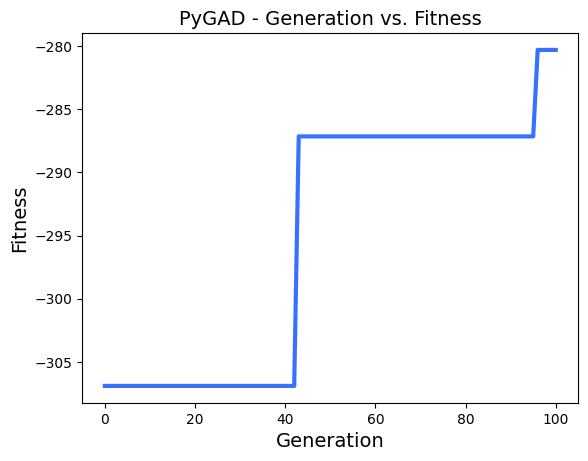

Parameters of best solution : [8. 7. 6. 5. 4. 1. 2. 3. 0. 9.]
Fitness of the best solution = -280.3072206992613


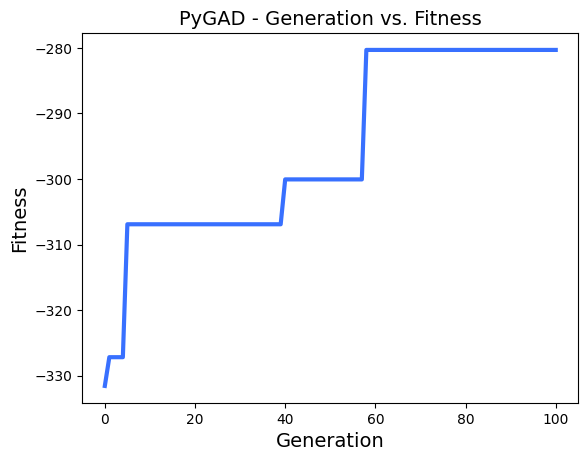

Parameters of best solution : [1. 4. 5. 6. 7. 8. 9. 0. 3. 2.]
Fitness of the best solution = -280.30722069926134


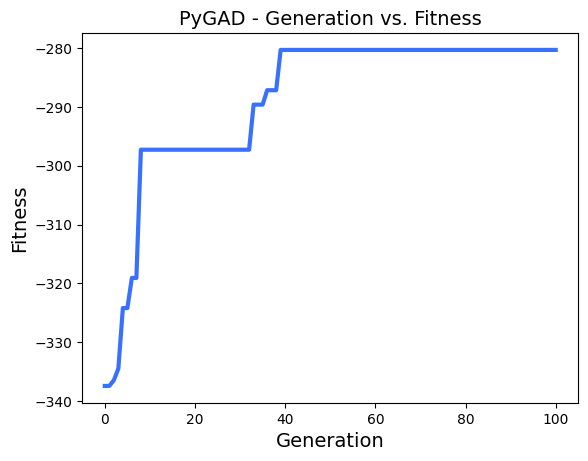

Parameters of best solution : [7. 6. 5. 4. 1. 2. 3. 0. 9. 8.]
Fitness of the best solution = -280.30722069926134


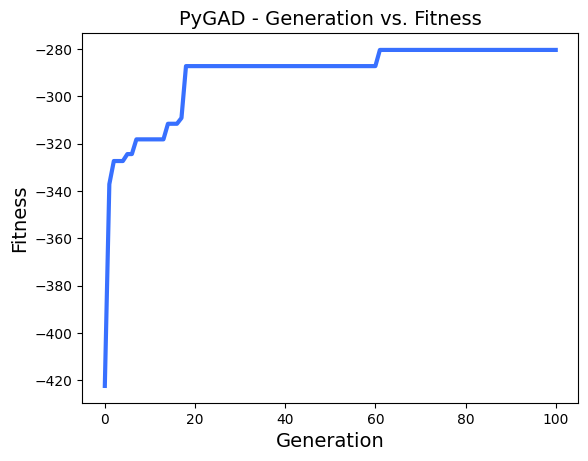

Parameters of best solution : [3. 2. 6. 4. 7. 5. 9. 0. 8. 1.]
Fitness of the best solution = -321.6398485576058


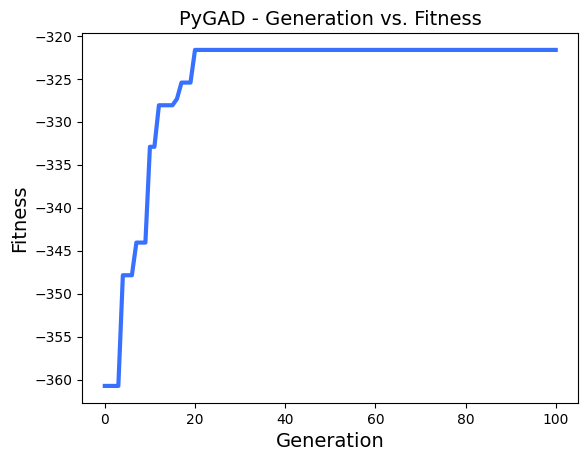

Parameters of best solution : [9. 5. 4. 7. 3. 8. 0. 1. 6. 2.]
Fitness of the best solution = -325.7413270943398


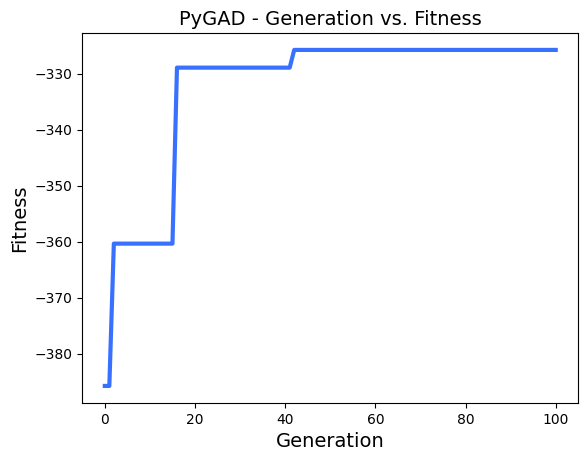

Parameters of best solution : [7. 8. 9. 0. 3. 2. 1. 4. 5. 6.]
Fitness of the best solution = -280.3072206992613


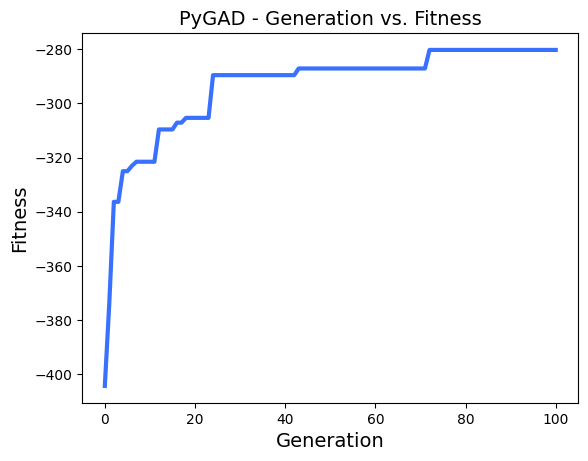

Parameters of best solution : [1. 3. 2. 6. 4. 7. 5. 9. 0. 8.]
Fitness of the best solution = -321.6398485576058


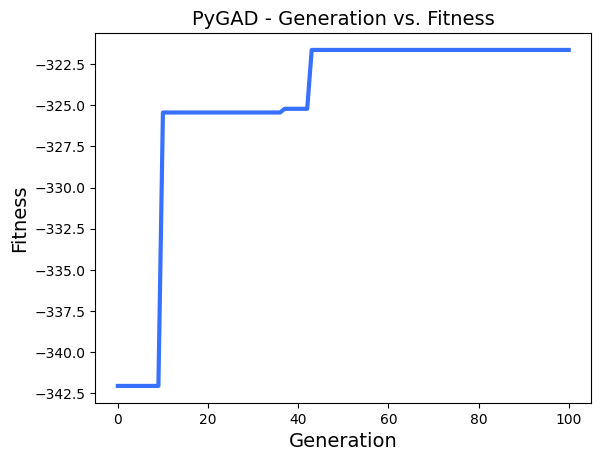

Parameters of best solution : [5. 7. 4. 6. 2. 3. 1. 8. 0. 9.]
Fitness of the best solution = -321.6398485576058


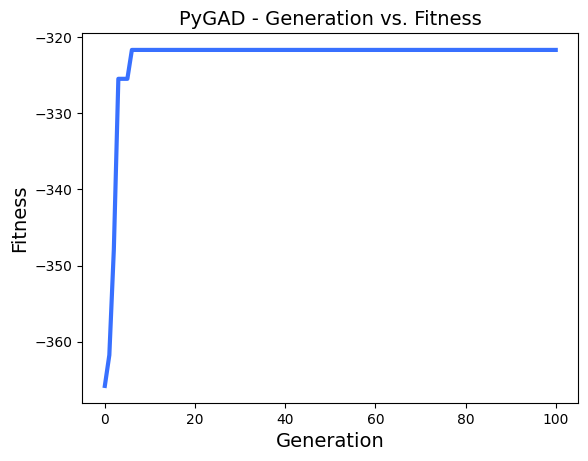

Parameters of best solution : [3. 2. 1. 4. 5. 6. 7. 8. 9. 0.]
Fitness of the best solution = -280.3072206992613


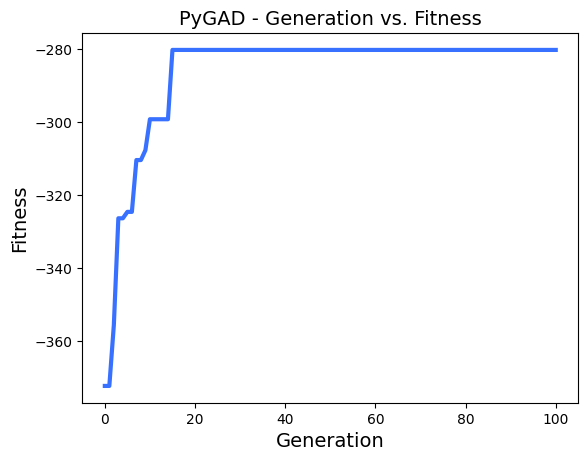

Parameters of best solution : [9. 0. 3. 2. 1. 4. 5. 6. 7. 8.]
Fitness of the best solution = -280.3072206992613


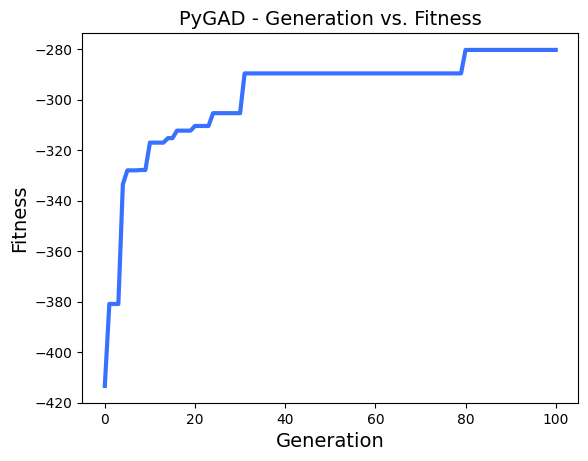

Parameters of best solution : [4. 5. 6. 7. 8. 9. 0. 3. 2. 1.]
Fitness of the best solution = -280.3072206992613


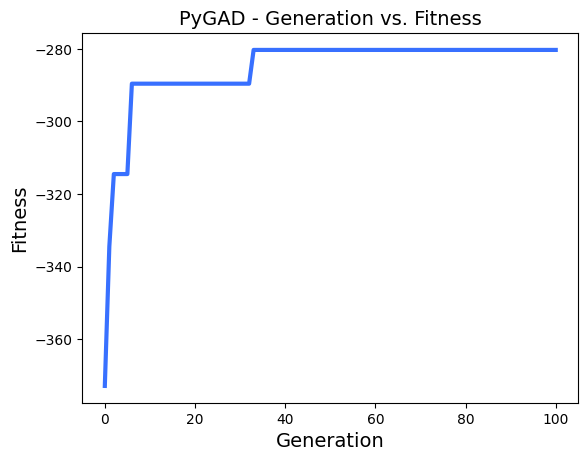

Parameters of best solution : [4. 7. 5. 9. 0. 8. 1. 3. 2. 6.]
Fitness of the best solution = -321.6398485576058


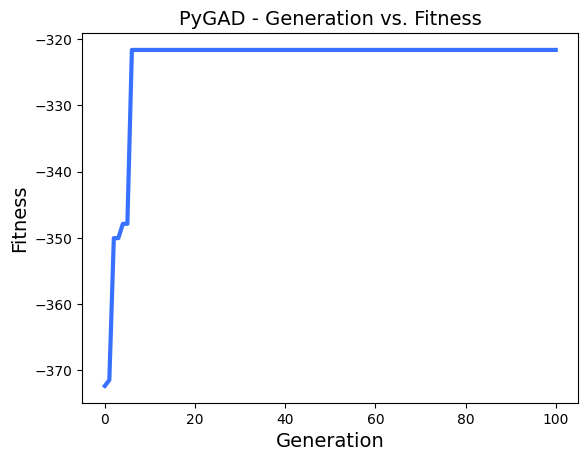

Parameters of best solution : [9. 2. 6. 1. 0. 8. 3. 7. 4. 5.]
Fitness of the best solution = -325.7413270943398


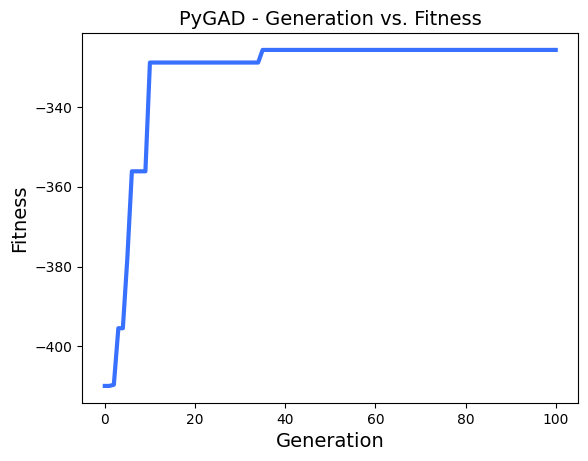

Parameters of best solution : [3. 2. 6. 4. 7. 5. 9. 0. 8. 1.]
Fitness of the best solution = -321.6398485576058


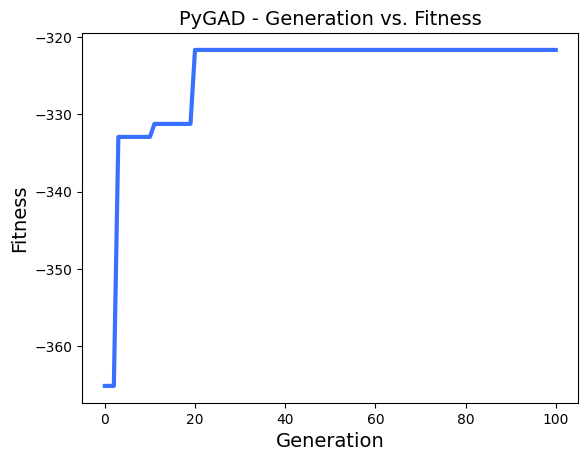

Parameters of best solution : [8. 7. 6. 5. 4. 1. 2. 3. 0. 9.]
Fitness of the best solution = -280.3072206992613


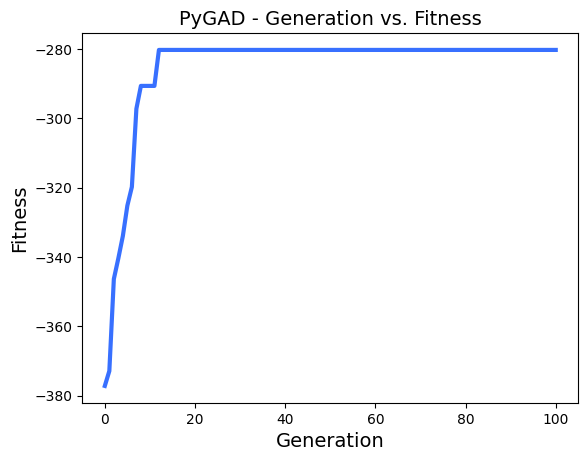

In [98]:
effectivness_graph,counters, mean_time, all_results = effectiveness_genetic(graphs_medium)

In [99]:
#effectivness table for each of large graphs
df_medium = {
  "Graph": [1, 2, 3],
  "Time": [effectivness_graph[0][2], effectivness_graph[1][2], effectivness_graph[2][2]],
    "Effectivness(%)" : [round((effectivness_graph[0][0]/effectivness_graph[0][1])*100,2), round((effectivness_graph[1][0]/effectivness_graph[1][1])*100,2),round((effectivness_graph[2][0]/effectivness_graph[2][1])*100,2)]}

table_medium = pd.DataFrame(df_medium)
table_medium

Graph      Time  Effectivness(%)
0      1  1.027644           100.00
1      2  1.018978           100.00
2      3  1.012201            97.56

In [100]:
medium_results.append(counters)
medium_results.append(mean_time)

In [101]:
medium_results

[99, 1.019040928946601]

#### 2.1.3 Large inputs.

In [106]:
large_results = []

Parameters of best solution : [13. 14.  7. 10.  4. 12. 11.  0.  3.  5.  6.  1.  9.  2.  8.]
Fitness of the best solution = -335.5624237143021


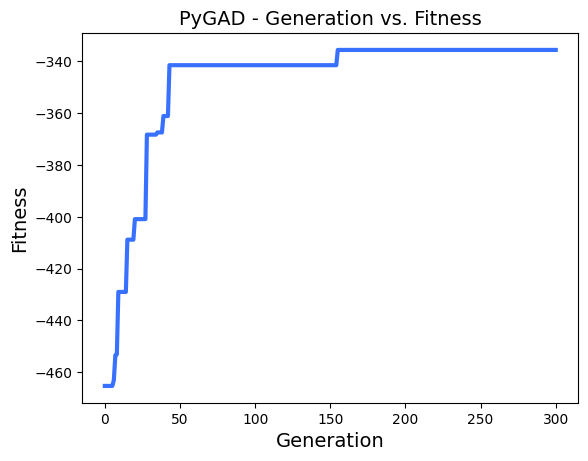

Parameters of best solution : [11.  3.  4.  1.  0.  8. 14.  5.  6. 13.  7.  2.  9. 12. 10.]
Fitness of the best solution = -408.42829828580386


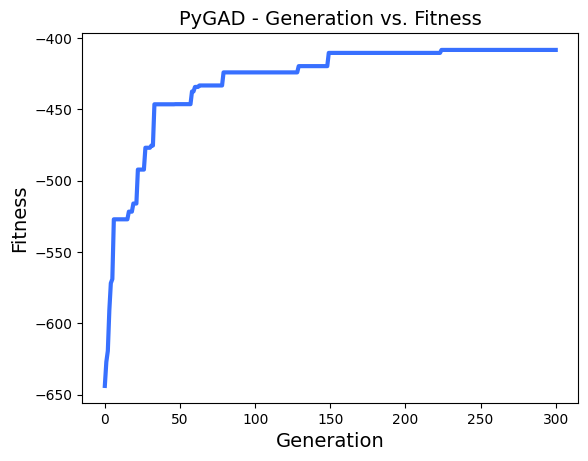

Parameters of best solution : [ 3.  5.  1.  9.  0. 10.  4. 12. 11.  7. 14. 13.  8.  2.  6.]
Fitness of the best solution = -336.4119016603054


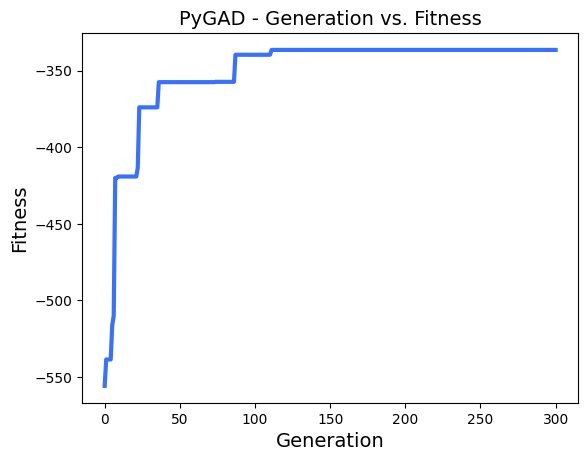

Parameters of best solution : [ 9.  0.  8. 12. 10. 14. 13.  7.  1.  5.  3. 11.  2.  6.  4.]
Fitness of the best solution = -333.9050085276733


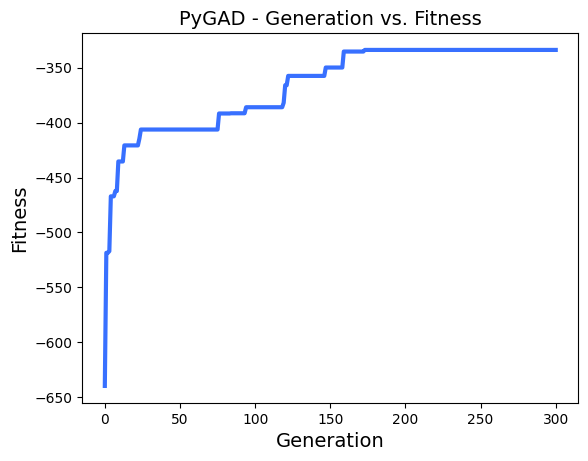

Parameters of best solution : [ 3.  5.  6.  1.  9.  2.  8. 13. 14.  7. 11. 12.  4. 10.  0.]
Fitness of the best solution = -310.00748627759214


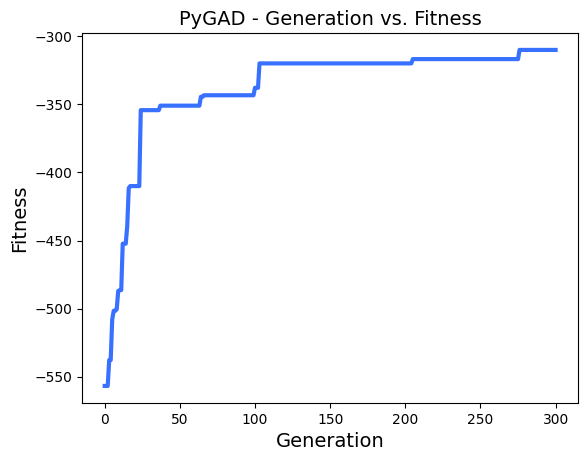

Parameters of best solution : [ 3. 11.  1.  7. 13. 14. 10. 12.  8.  0.  9.  4.  6.  2.  5.]
Fitness of the best solution = -361.2771330137322


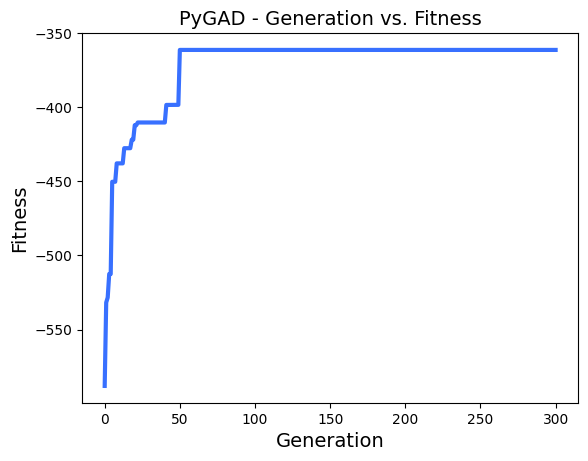

Parameters of best solution : [14.  8.  0.  1.  4.  3. 11. 10. 12.  9.  2.  7. 13.  6.  5.]
Fitness of the best solution = -408.42829828580386


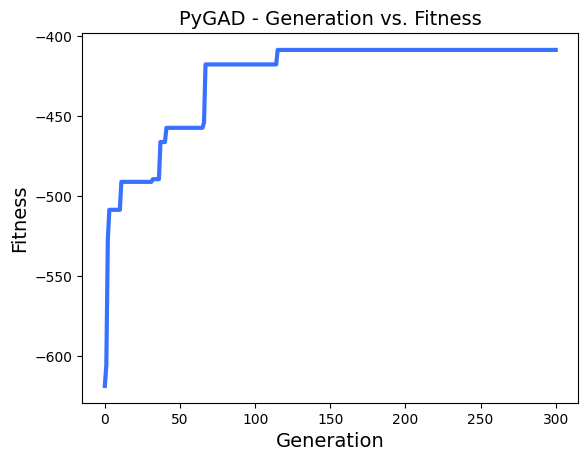

Parameters of best solution : [14.  7. 11. 12.  4. 10.  0.  5.  3.  6.  1.  9.  2.  8. 13.]
Fitness of the best solution = -311.1260187045795


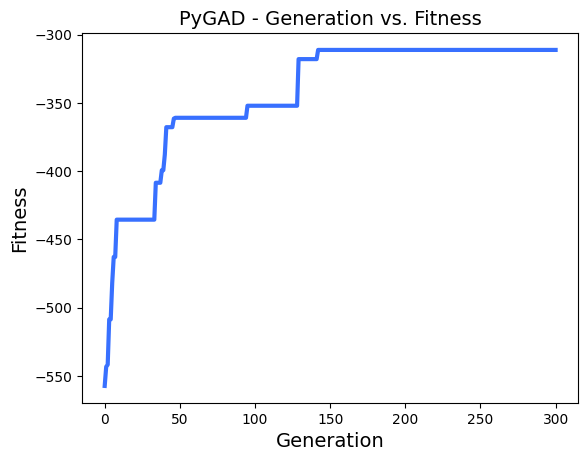

Parameters of best solution : [ 2.  6.  4.  9.  0.  8. 12. 10. 14. 13.  7.  1.  5.  3. 11.]
Fitness of the best solution = -333.90500852767343


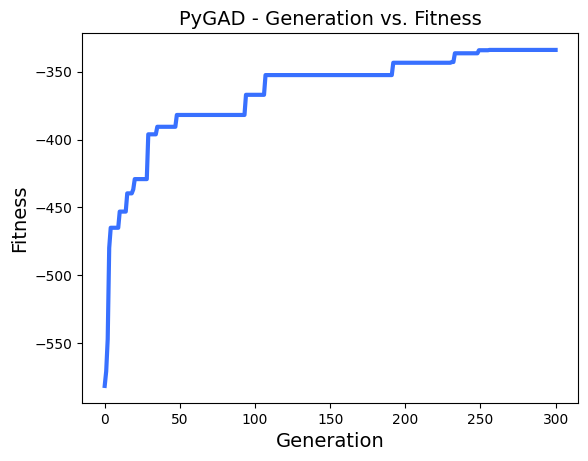

Parameters of best solution : [ 6.  2. 11.  3.  5.  1.  9.  7. 13. 14. 10. 12.  8.  0.  4.]
Fitness of the best solution = -335.381579693071


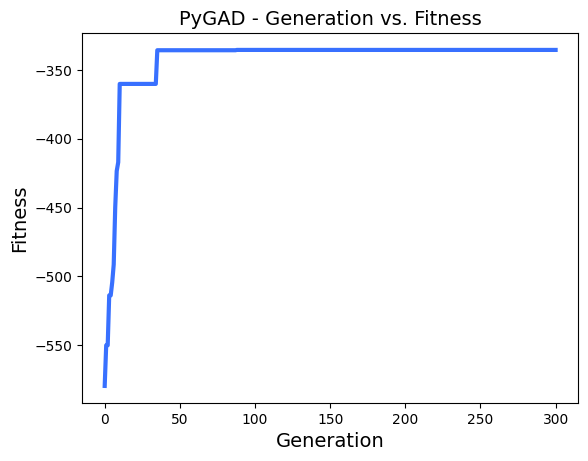

Parameters of best solution : [13. 12.  0.  8. 10.  9.  4.  6.  2. 11.  3.  5.  1.  7. 14.]
Fitness of the best solution = -343.5680278826581


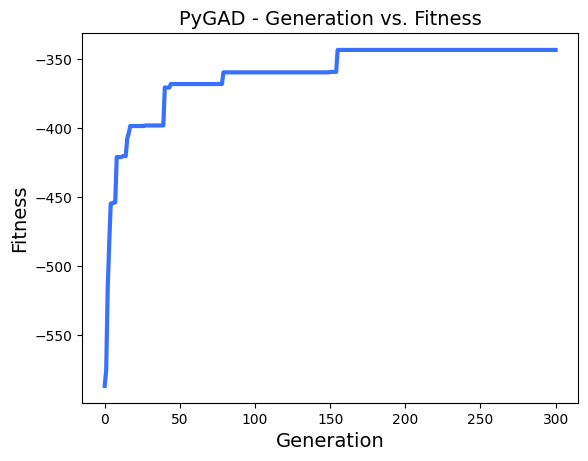

Parameters of best solution : [ 0.  8. 12. 10. 13. 14.  7.  1.  5.  3. 11.  2.  6.  4.  9.]
Fitness of the best solution = -334.13238422185174


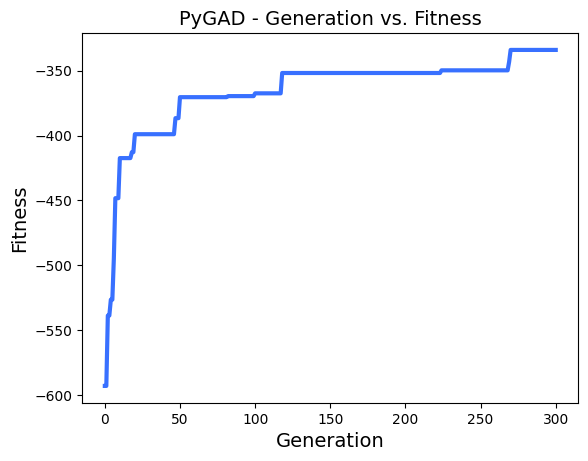

Parameters of best solution : [14.  4.  3. 11. 10. 12.  5.  6. 13.  7.  2.  9.  1.  0.  8.]
Fitness of the best solution = -425.91130255008534


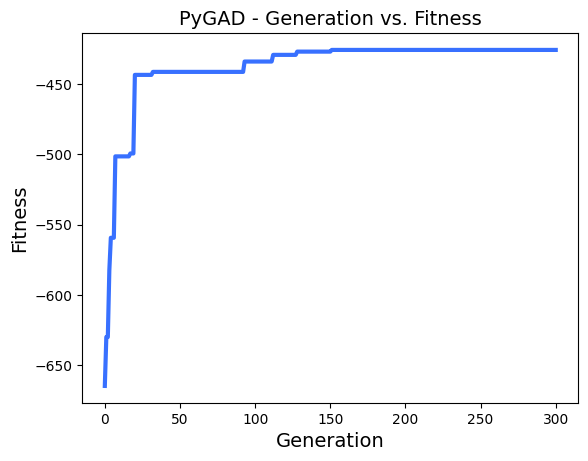

Parameters of best solution : [ 9.  0.  8. 12. 10. 14. 13.  7.  1.  5.  3. 11.  2.  6.  4.]
Fitness of the best solution = -333.9050085276733


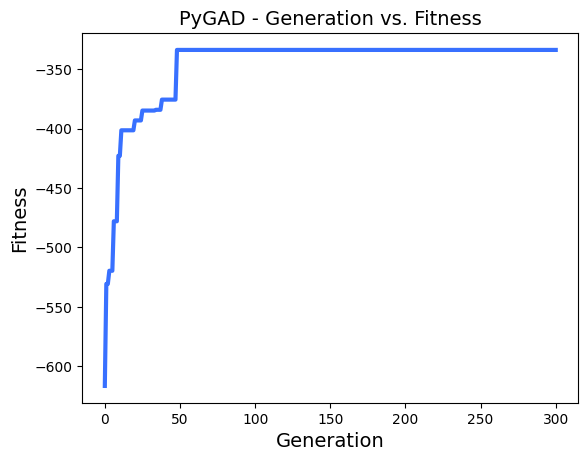

Parameters of best solution : [13. 12. 10. 11. 14.  8.  0.  3.  4.  1.  9.  2.  7.  6.  5.]
Fitness of the best solution = -408.518090121132


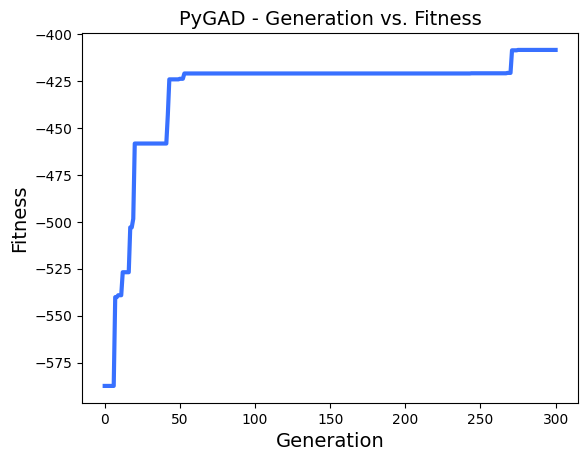

Parameters of best solution : [ 2.  9.  1.  6.  5.  3.  0. 10.  4. 12.  7. 11. 14. 13.  8.]
Fitness of the best solution = -321.37660903222525


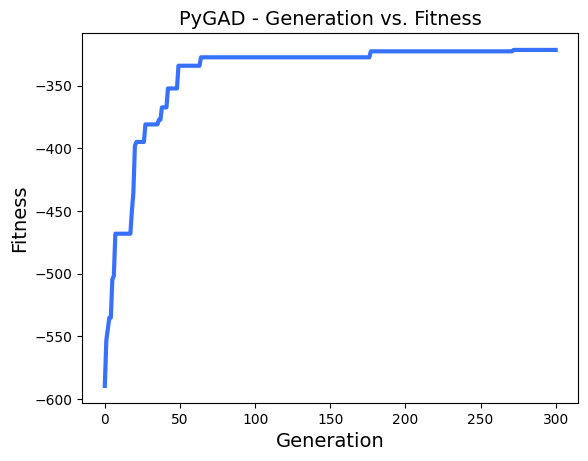

Parameters of best solution : [14.  8.  0.  1.  4.  3. 11.  9.  2. 12. 10. 13.  7.  6.  5.]
Fitness of the best solution = -418.6229332953298


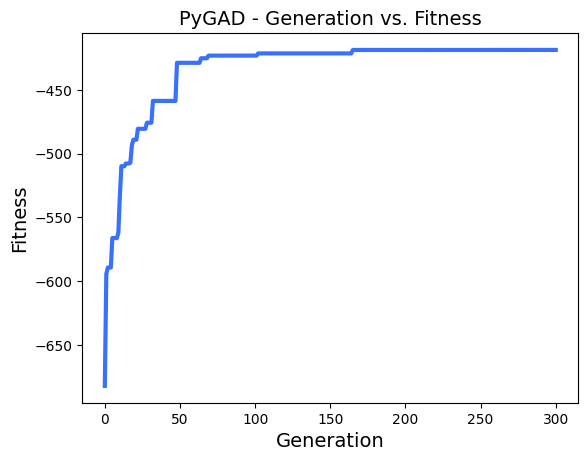

Parameters of best solution : [ 4. 12. 11.  7. 14. 13.  8.  2.  9.  1.  6.  5.  3.  0. 10.]
Fitness of the best solution = -310.0074862775921


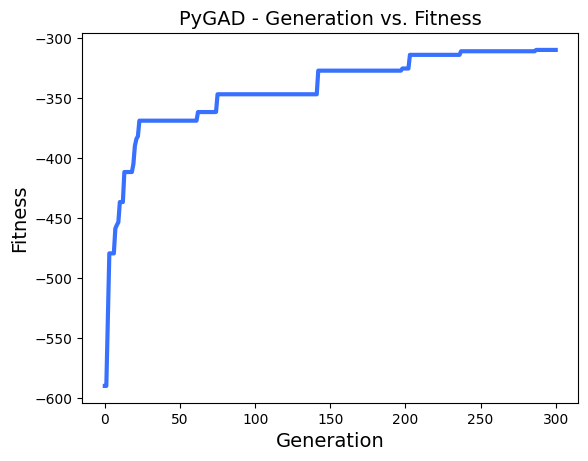

Parameters of best solution : [ 2.  0.  3.  5.  6.  1.  9.  8. 13. 14.  7. 11. 12. 10.  4.]
Fitness of the best solution = -327.49952735488534


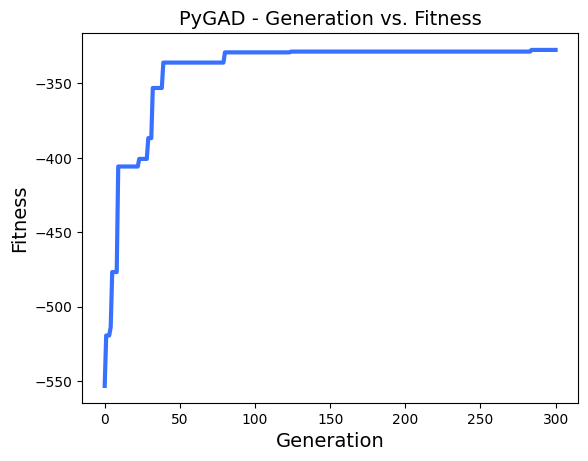

Parameters of best solution : [14. 13.  7.  1.  5.  3. 11.  2.  6.  4.  9.  0.  8. 12. 10.]
Fitness of the best solution = -333.90500852767343


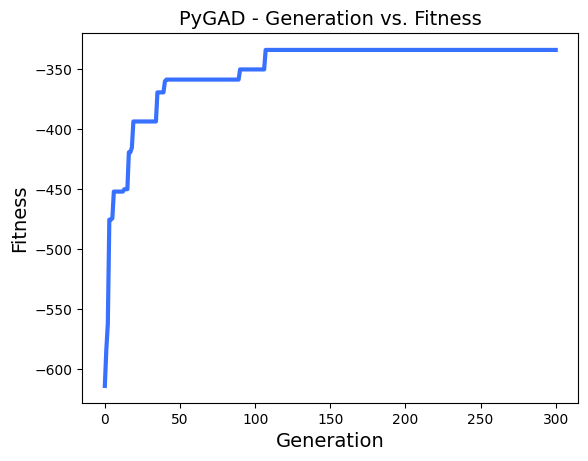

Parameters of best solution : [ 4.  9.  0.  8. 12. 10. 14. 13.  7.  1.  5.  3. 11.  2.  6.]
Fitness of the best solution = -333.9050085276734


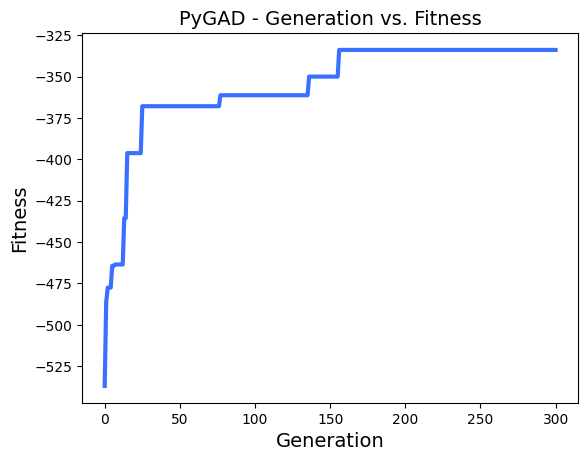

Parameters of best solution : [ 1.  6.  3.  5.  0. 10.  4. 12. 11.  7. 14. 13.  8.  2.  9.]
Fitness of the best solution = -311.12601870457956


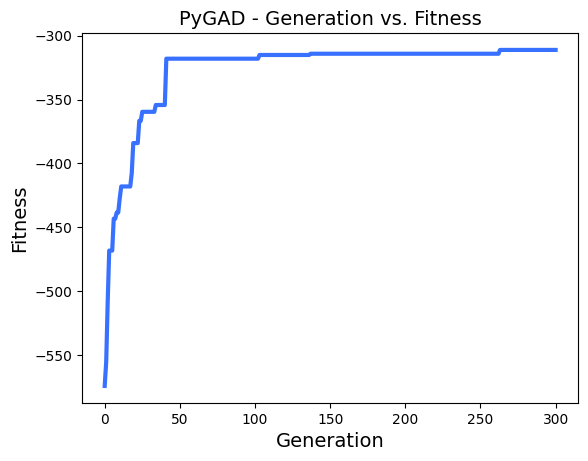

Parameters of best solution : [ 3.  5.  0. 12. 10.  4. 11.  7. 14. 13.  8.  2.  9.  1.  6.]
Fitness of the best solution = -321.92805107036315


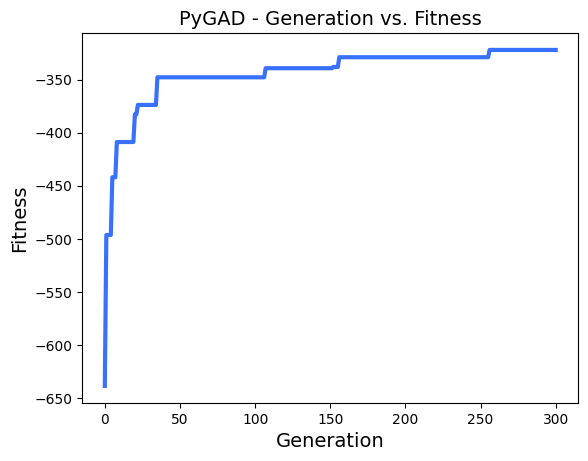

Parameters of best solution : [ 5.  1.  7. 14. 13.  8.  0. 12. 10.  9.  4.  6.  2. 11.  3.]
Fitness of the best solution = -336.3815281803316


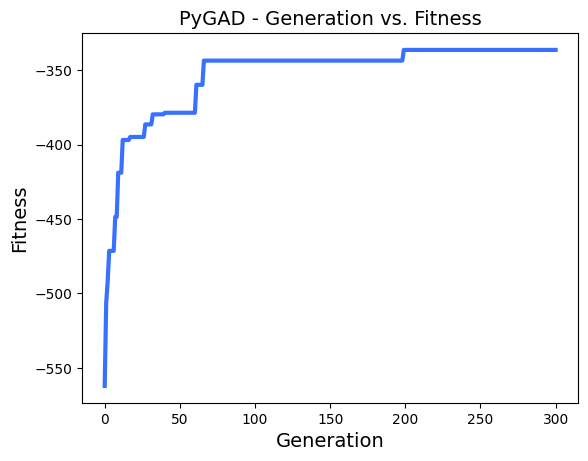

Parameters of best solution : [ 3. 11.  8.  0. 14.  5.  6.  7. 13. 10. 12.  2.  9.  1.  4.]
Fitness of the best solution = -430.6434699417556


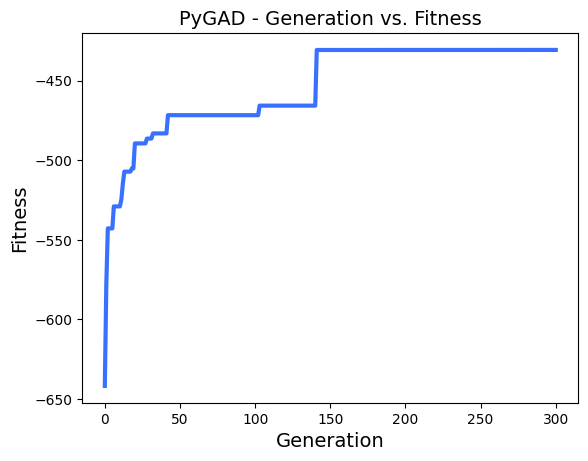

Parameters of best solution : [ 5.  6. 13.  7.  2.  9. 12.  3.  4.  1.  0.  8. 14. 11. 10.]
Fitness of the best solution = -430.4493224240242


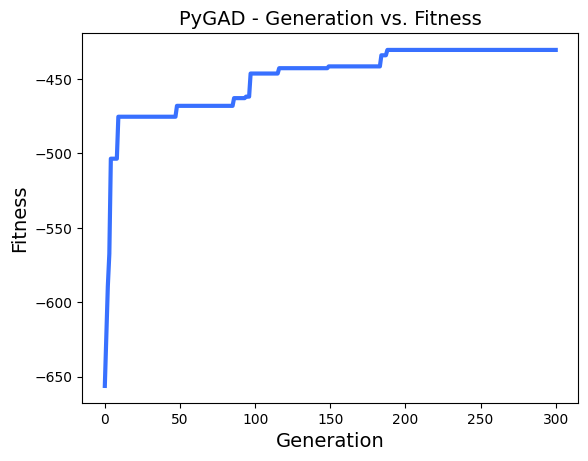

Parameters of best solution : [10.  0.  3.  5.  6.  1.  9.  2.  8. 13. 14.  7. 11. 12.  4.]
Fitness of the best solution = -310.0074862775921


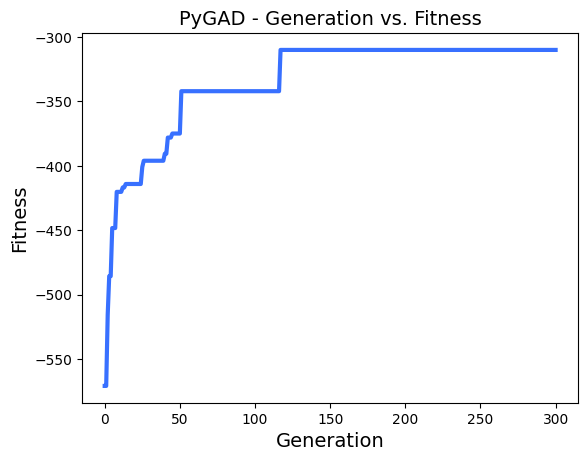

Parameters of best solution : [ 8. 14.  7. 11. 12.  4. 10.  0.  5.  6.  3.  1.  9.  2. 13.]
Fitness of the best solution = -320.85191886093276


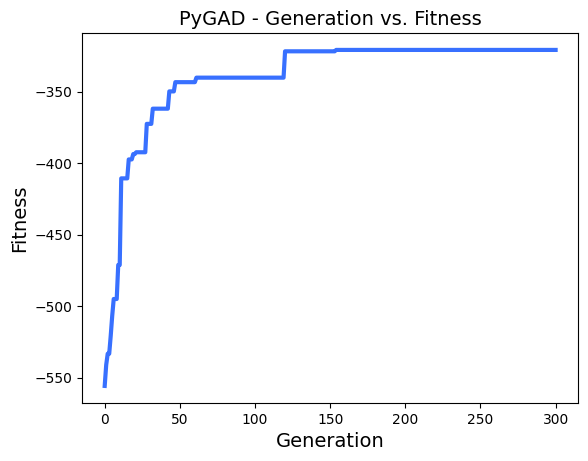

Parameters of best solution : [ 1.  5.  3. 11.  2.  6.  4.  9.  0.  8. 12. 10. 14. 13.  7.]
Fitness of the best solution = -333.90500852767343


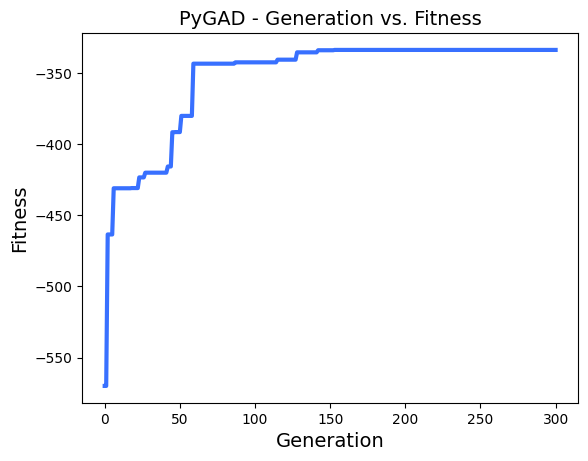

Parameters of best solution : [ 9.  0.  8. 12. 10. 13. 14.  7.  1.  3.  5. 11.  2.  6.  4.]
Fitness of the best solution = -348.67790621839174


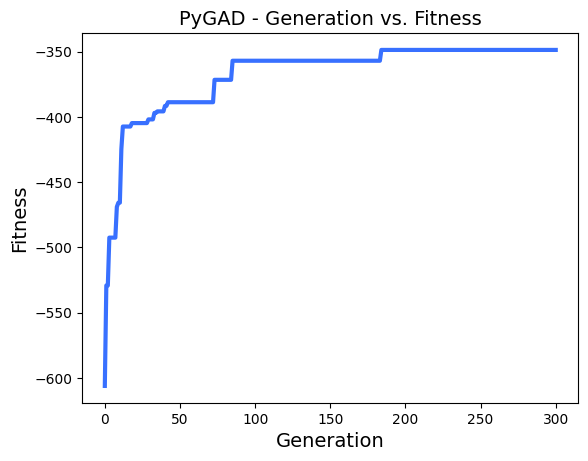

Parameters of best solution : [ 2. 12.  7. 13.  6.  5. 10. 11. 14.  8.  0.  3.  4.  1.  9.]
Fitness of the best solution = -406.4270602205307


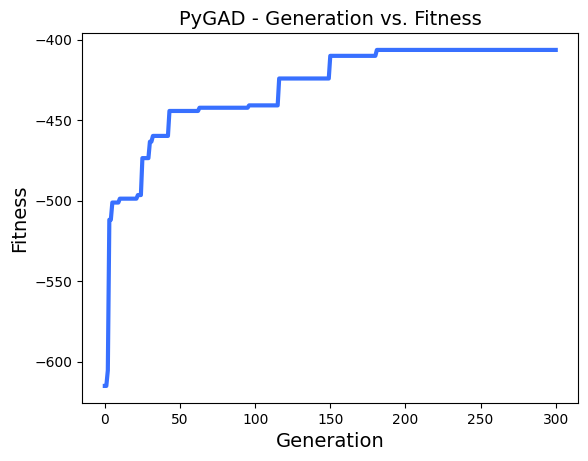

Parameters of best solution : [10. 12.  5.  6. 13.  7.  2.  9.  1.  4.  3.  0.  8. 14. 11.]
Fitness of the best solution = -407.0093888409938


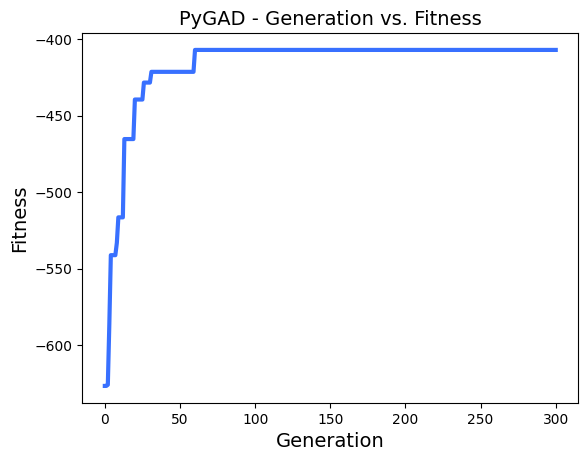

Parameters of best solution : [ 7.  5.  6.  2.  9.  1.  0.  8. 14.  3.  4. 11. 10. 12. 13.]
Fitness of the best solution = -430.06145255589877


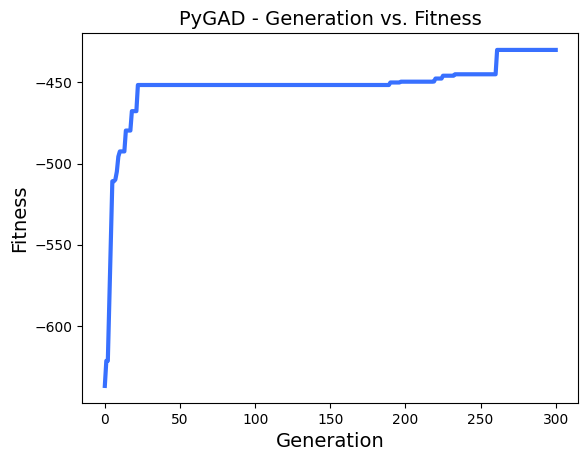

Parameters of best solution : [10.  4. 12.  0.  5.  3.  6.  1.  9.  2.  8. 13. 14.  7. 11.]
Fitness of the best solution = -321.74699203284547


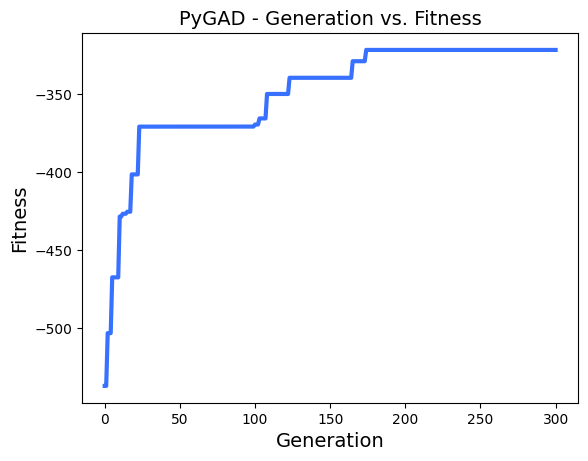

Parameters of best solution : [ 7. 13. 14. 10. 12.  8.  0.  9.  4.  6.  2. 11.  3.  5.  1.]
Fitness of the best solution = -333.90500852767343


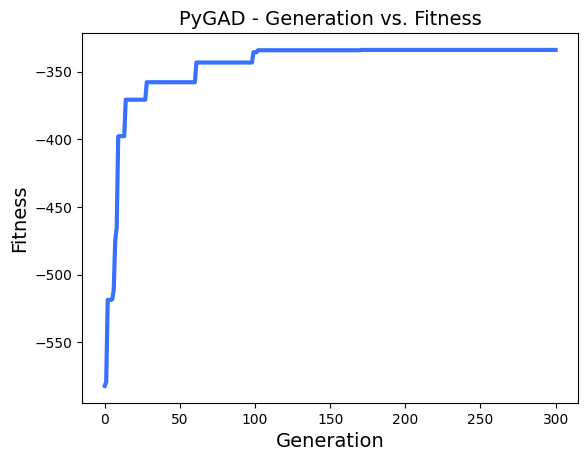

Parameters of best solution : [13. 14.  7.  9.  1.  5.  3. 11.  2.  6.  4.  0.  8. 12. 10.]
Fitness of the best solution = -335.60895538724924


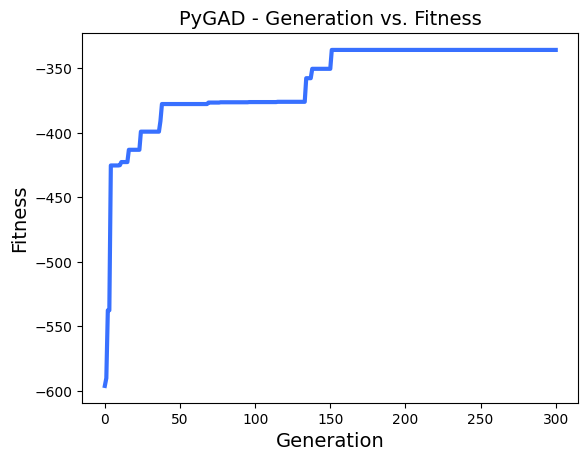

Parameters of best solution : [10. 12. 11.  4.  3.  1.  0.  8. 14.  5.  6.  7. 13.  2.  9.]
Fitness of the best solution = -440.90010065342335


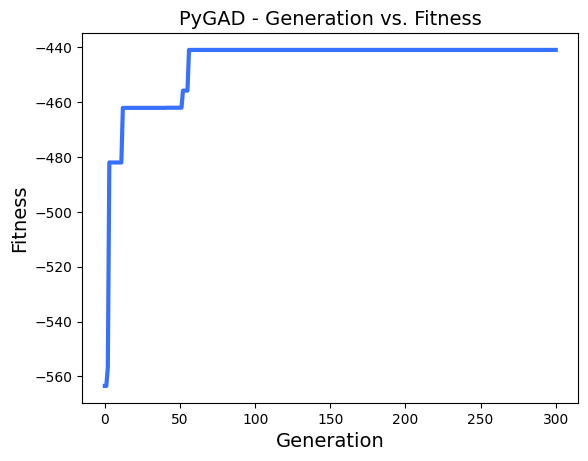

Parameters of best solution : [ 0.  5.  6.  3.  1.  9.  2. 13.  8. 14.  7. 11. 12.  4. 10.]
Fitness of the best solution = -320.8519188609328


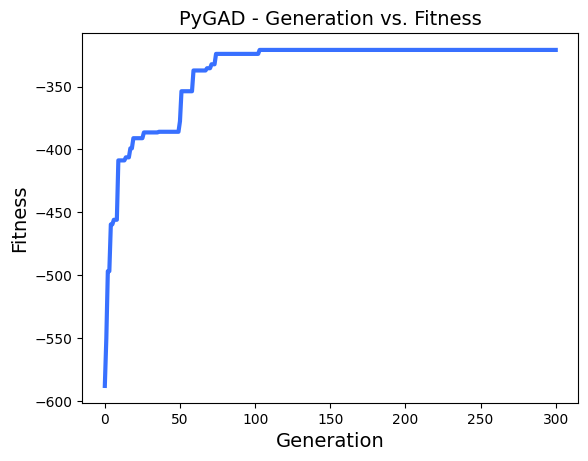

Parameters of best solution : [ 0.  3.  5.  6.  1.  9.  2.  8. 13. 14.  7. 11. 12.  4. 10.]
Fitness of the best solution = -310.0074862775921


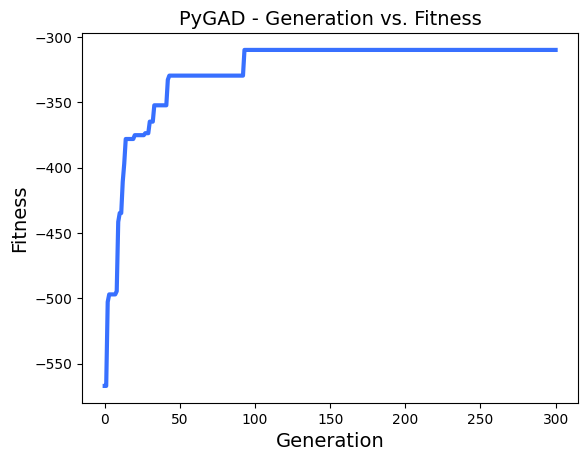

Parameters of best solution : [ 7. 13. 14. 10. 12.  8.  0.  9.  4.  6.  2. 11.  3.  5.  1.]
Fitness of the best solution = -333.90500852767343


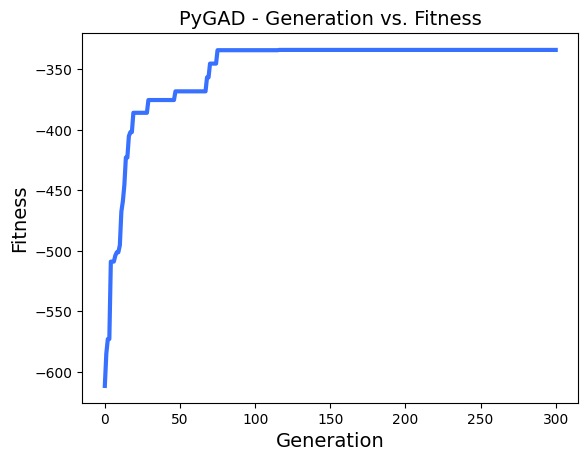

Parameters of best solution : [ 4.  0.  8. 14. 11. 10.  5.  6.  7. 13. 12.  2.  9.  1.  3.]
Fitness of the best solution = -414.2133514654744


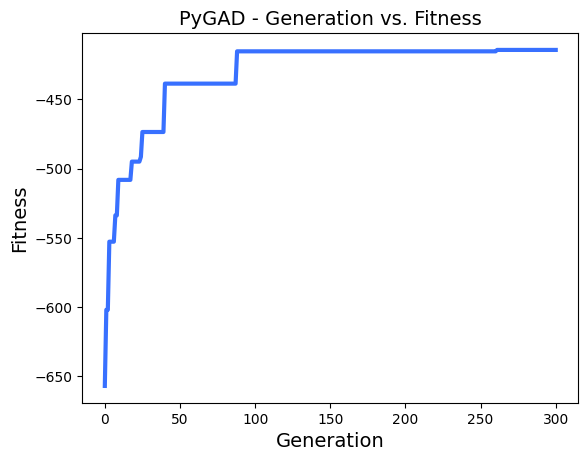

Parameters of best solution : [10.  4. 12. 11.  7. 14. 13.  8.  2.  9.  1.  6.  5.  3.  0.]
Fitness of the best solution = -310.0074862775921


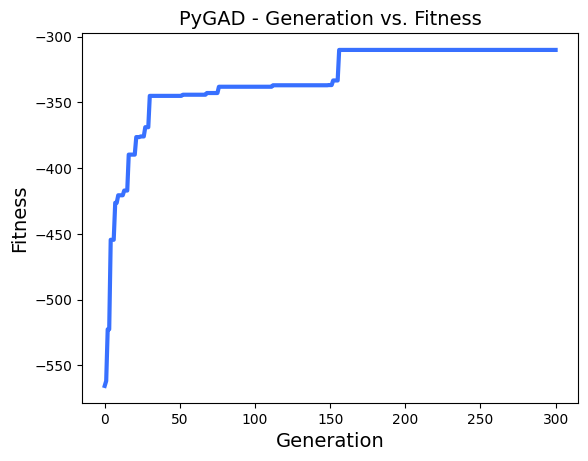

Parameters of best solution : [ 0.  8. 14. 11. 10.  6.  5. 13.  7. 12.  2.  9.  1.  4.  3.]
Fitness of the best solution = -409.8352726599361


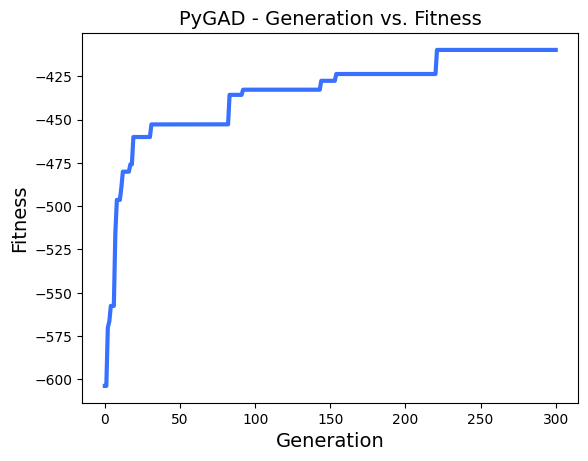

Parameters of best solution : [11.  2.  6.  4.  9.  0.  8. 12. 10. 14. 13.  7.  1.  5.  3.]
Fitness of the best solution = -333.90500852767343


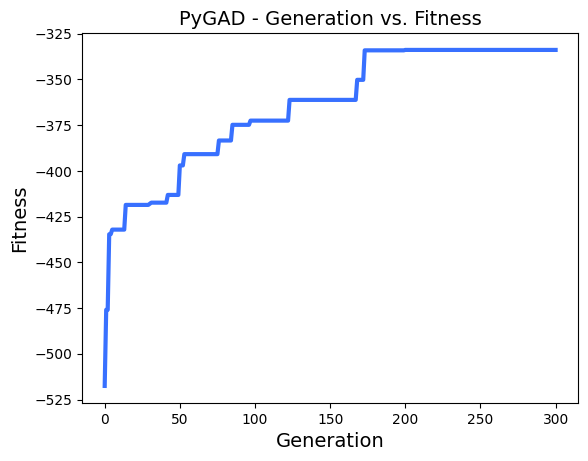

Parameters of best solution : [12.  7. 13.  6.  5. 10. 11.  3. 14.  8.  0.  4.  1.  9.  2.]
Fitness of the best solution = -430.3821303019333


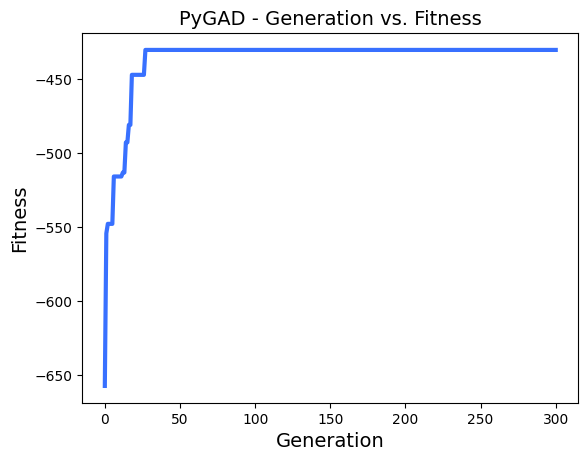

Parameters of best solution : [14. 13.  7.  9.  1.  5.  3. 11.  2.  6.  4.  0.  8. 12. 10.]
Fitness of the best solution = -335.381579693071


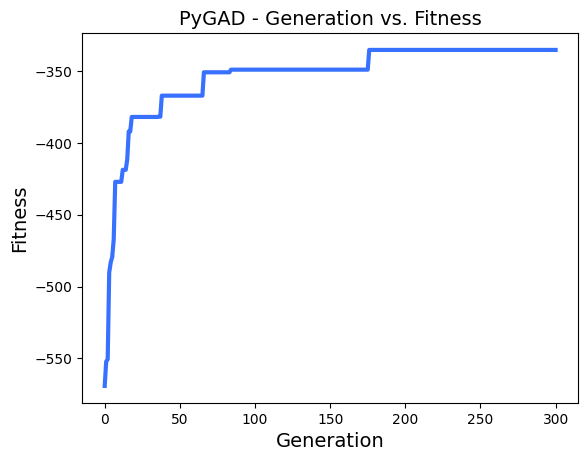

Parameters of best solution : [ 5.  0. 10.  4. 12. 11.  7. 14. 13.  8.  2.  9.  1.  6.  3.]
Fitness of the best solution = -311.12601870457956


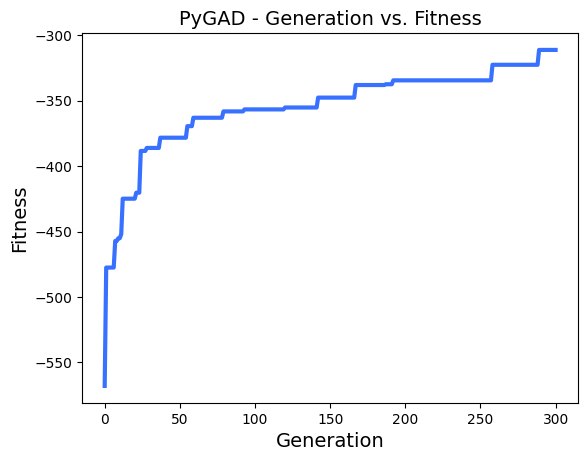

Parameters of best solution : [ 3. 14.  8.  0.  4.  1.  9.  2.  7. 13.  6.  5. 12. 10. 11.]
Fitness of the best solution = -430.96445892239626


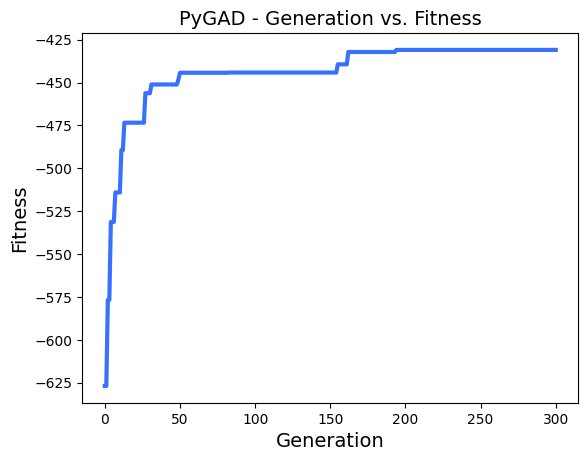

Parameters of best solution : [13. 14.  7. 11. 12.  4. 10.  0.  3.  5.  6.  1.  9.  2.  8.]
Fitness of the best solution = -310.007486277592


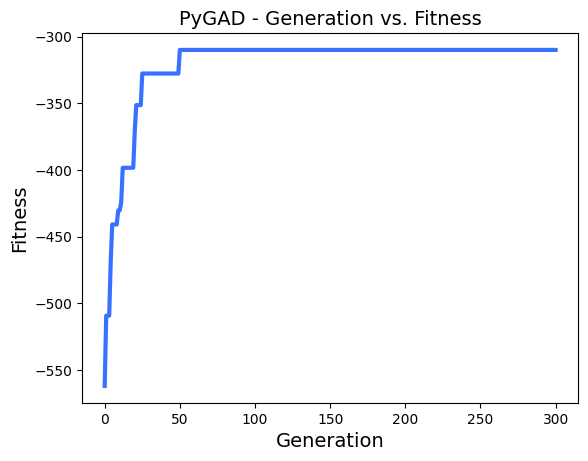

Parameters of best solution : [ 3. 11.  2.  6.  4. 10. 12.  0.  8. 13. 14.  7.  9.  1.  5.]
Fitness of the best solution = -347.91533747280675


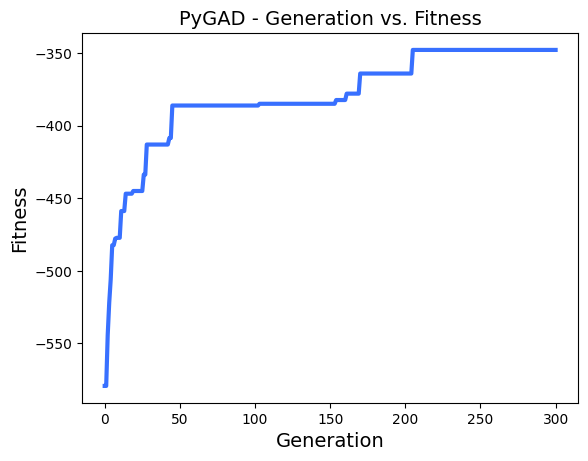

Parameters of best solution : [ 9.  2. 12.  7. 13.  6.  5. 10. 14.  8.  0. 11.  3.  4.  1.]
Fitness of the best solution = -414.6354112434083


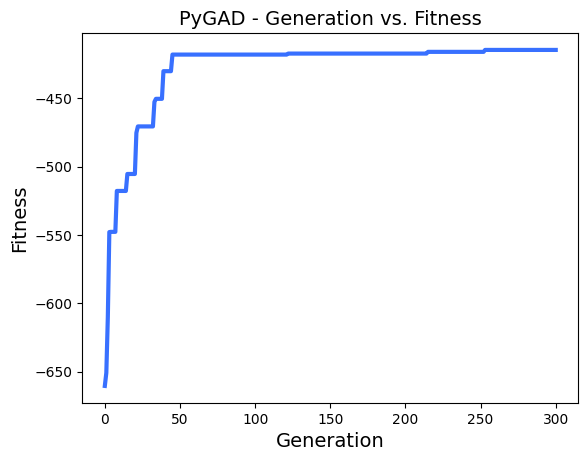

Parameters of best solution : [14.  7. 11. 12. 10.  4.  0.  3.  5.  6.  1.  9.  2.  8. 13.]
Fitness of the best solution = -313.1639806636414


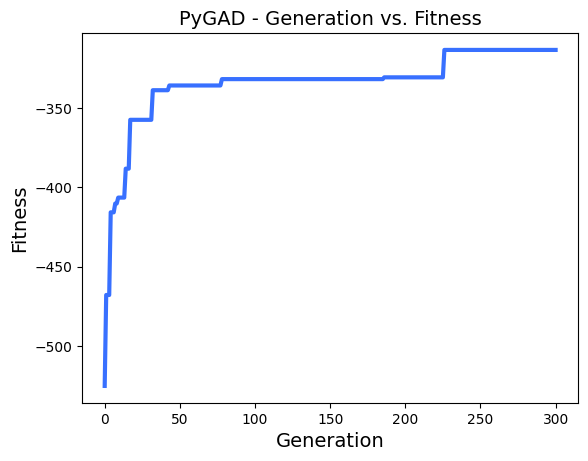

Parameters of best solution : [ 1.  5.  3. 11.  2.  6.  4.  9.  0.  8. 12. 10. 14. 13.  7.]
Fitness of the best solution = -333.90500852767343


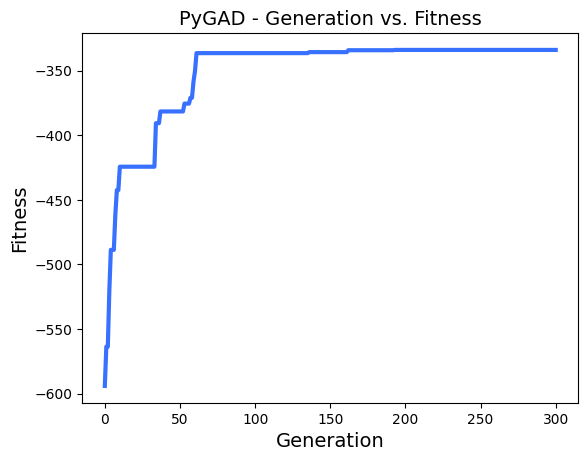

Parameters of best solution : [14. 13. 10. 12.  8.  0.  9.  4.  6.  2. 11.  3.  5.  1.  7.]
Fitness of the best solution = -334.13238422185174


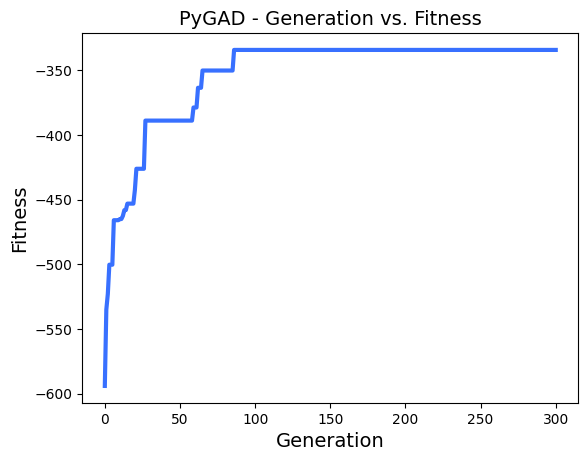

Parameters of best solution : [ 1.  3.  5.  6.  0.  2.  8. 13. 14.  7. 11. 12. 10.  4.  9.]
Fitness of the best solution = -337.02894001604454


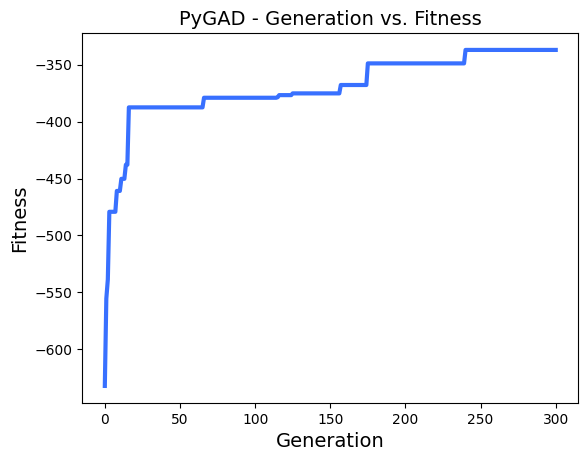

Parameters of best solution : [14.  8.  0. 11.  3.  4.  1.  9.  2.  6.  5. 13.  7. 12. 10.]
Fitness of the best solution = -416.0536015961352


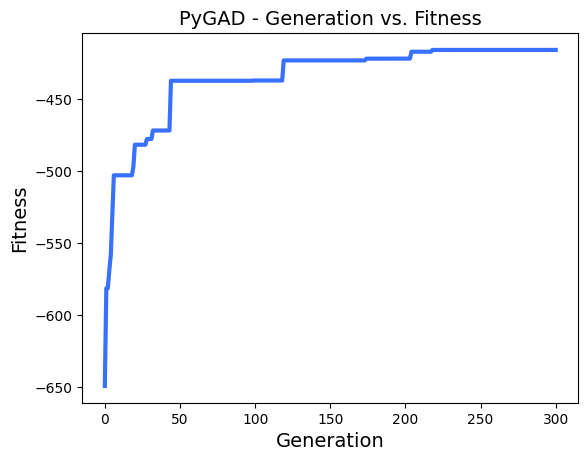

Parameters of best solution : [ 7. 14. 13. 10. 12.  8.  0.  9.  4.  6.  2. 11.  3.  5.  1.]
Fitness of the best solution = -334.1323842218517


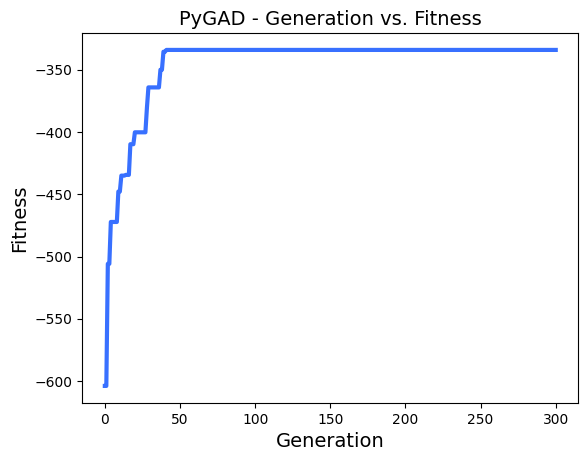

Parameters of best solution : [ 9.  1.  3.  6.  5.  0. 10.  4. 12. 11.  7. 14. 13.  8.  2.]
Fitness of the best solution = -314.1125892751558


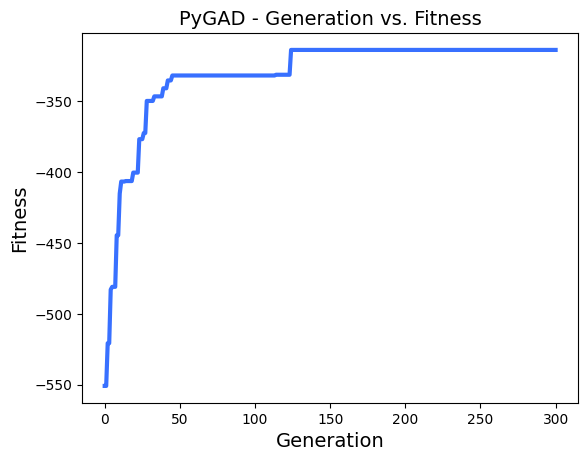

Parameters of best solution : [12. 10.  4.  6.  2. 11.  3.  5.  1.  9.  7. 14. 13.  8.  0.]
Fitness of the best solution = -347.91533747280675


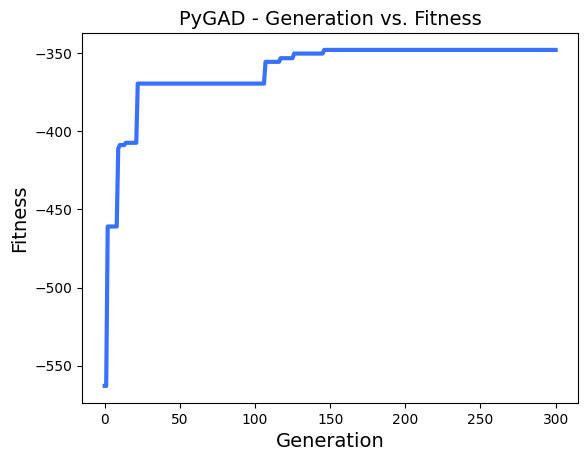

Parameters of best solution : [ 9.  2.  7. 13.  6.  5. 14.  8.  0.  1.  4.  3. 11. 10. 12.]
Fitness of the best solution = -408.4282982858038


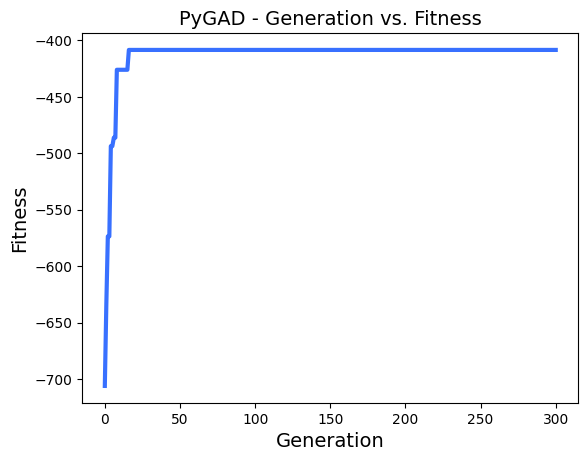

Parameters of best solution : [ 4. 10. 12.  0.  8. 13. 14.  7.  9.  1.  5.  3. 11.  2.  6.]
Fitness of the best solution = -347.9153374728067


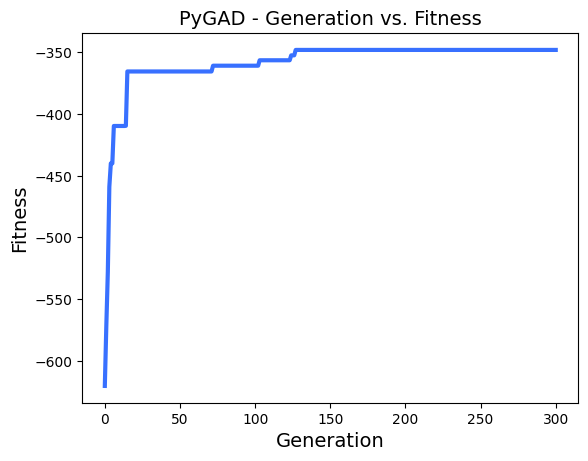

Parameters of best solution : [10. 13. 14.  7.  1.  5.  3. 11.  6.  2.  4.  9.  0.  8. 12.]
Fitness of the best solution = -343.21915319321573


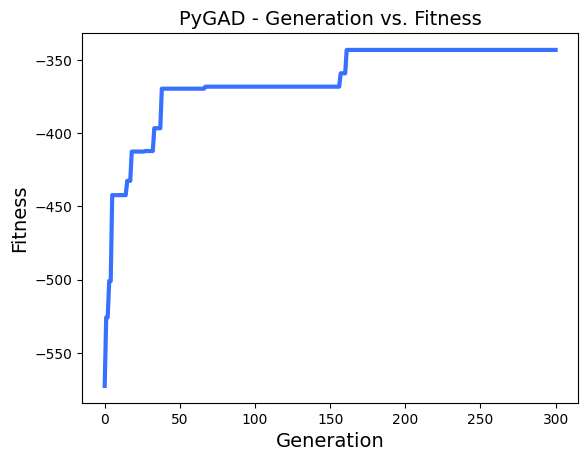

Parameters of best solution : [10. 14.  8.  0. 11.  3.  4.  1.  9.  2. 12.  7. 13.  6.  5.]
Fitness of the best solution = -414.6354112434084


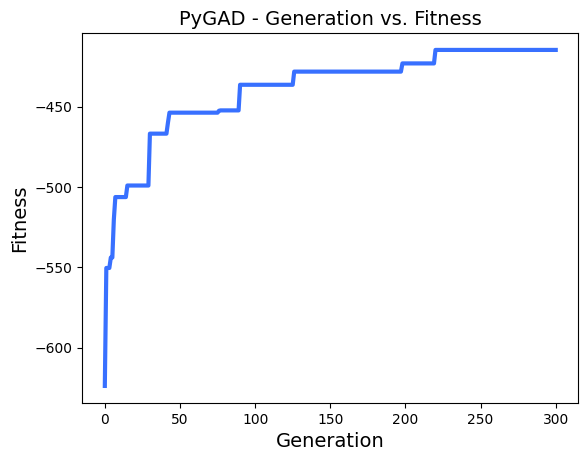

Parameters of best solution : [ 6. 13.  7. 12. 10. 11. 14.  8.  0.  3.  4.  1.  9.  2.  5.]
Fitness of the best solution = -408.8415883957566


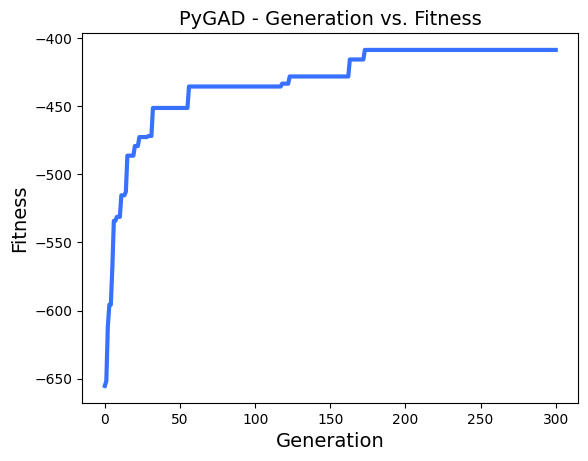

Parameters of best solution : [ 7. 12.  2.  9.  1.  4.  3.  0.  8. 14. 11. 10.  5.  6. 13.]
Fitness of the best solution = -406.42706022053073


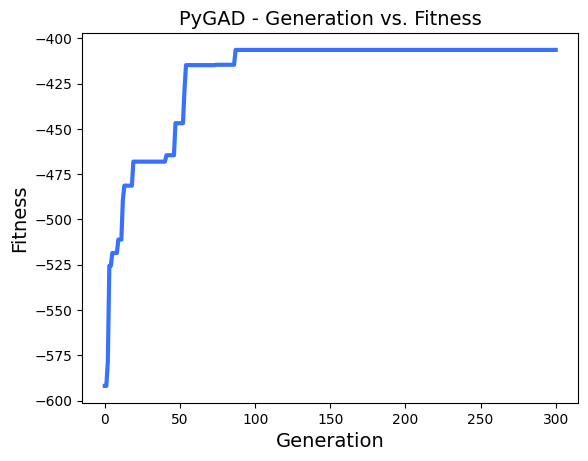

Parameters of best solution : [ 6.  4.  9. 10. 12.  0.  8. 13. 14.  7.  1.  5.  3. 11.  2.]
Fitness of the best solution = -336.38152818033166


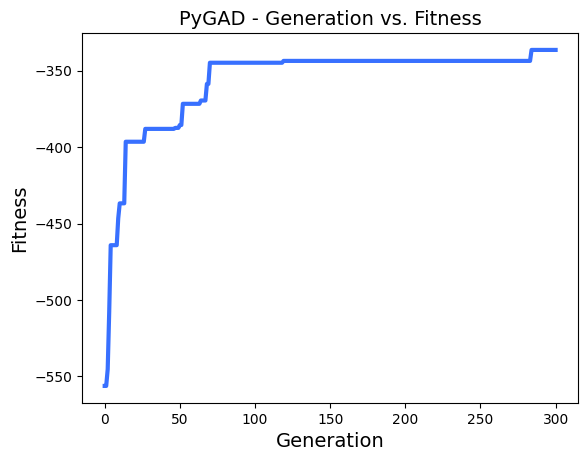

Parameters of best solution : [ 8. 14. 11. 12. 10. 13.  7.  5.  6.  2.  9.  1.  4.  3.  0.]
Fitness of the best solution = -420.50538898483927


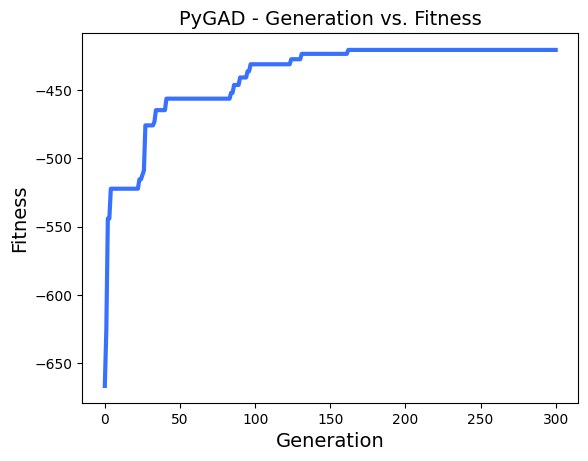

Parameters of best solution : [ 2. 11.  3.  1.  5.  9.  7. 14. 13.  0.  8. 12. 10.  4.  6.]
Fitness of the best solution = -370.2224222853081


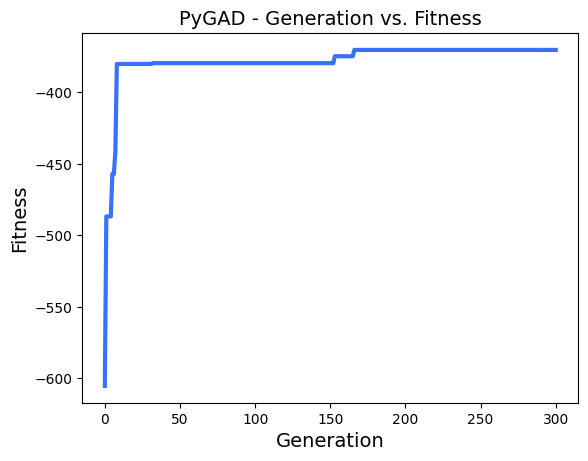

Parameters of best solution : [12.  2.  0.  5.  6.  3.  1.  9.  8. 13. 14.  7. 11. 10.  4.]
Fitness of the best solution = -335.44160532363037


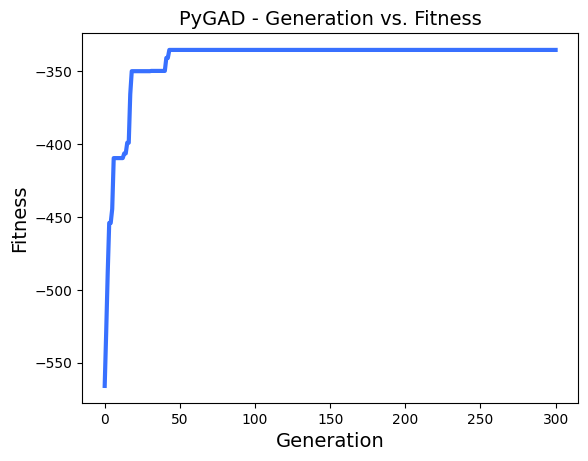

Parameters of best solution : [13. 14.  8.  0. 12. 10.  4.  6.  2. 11.  3.  5.  1.  9.  7.]
Fitness of the best solution = -353.21161025850705


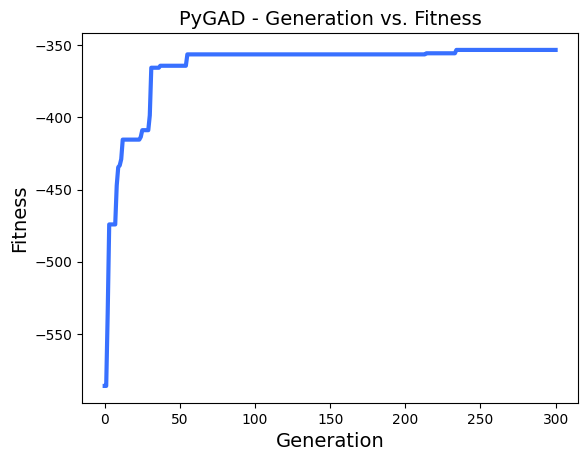

Parameters of best solution : [ 7.  1.  5.  3. 11.  2.  6.  4.  9.  0.  8. 12. 10. 14. 13.]
Fitness of the best solution = -333.90500852767343


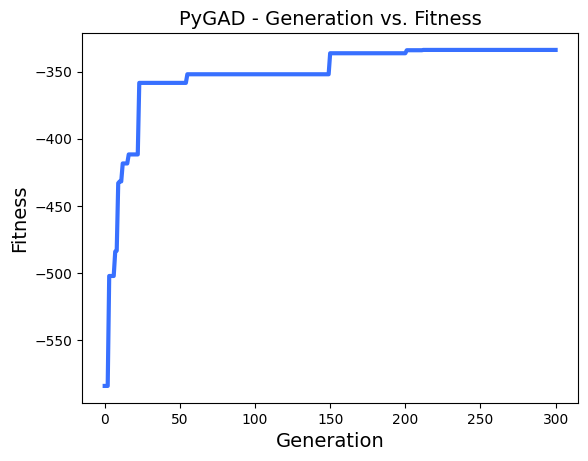

Parameters of best solution : [ 0.  5.  3.  6.  1.  9.  2.  8. 13. 14.  7. 11. 12.  4. 10.]
Fitness of the best solution = -311.12601870457956


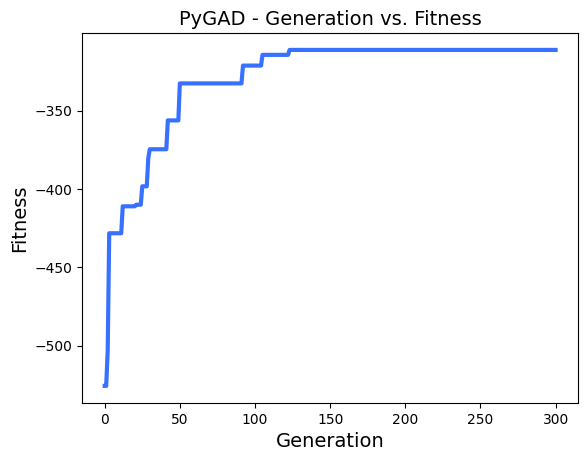

Parameters of best solution : [14.  8.  0.  3.  4.  1.  9.  2. 12.  7. 13.  6.  5. 10. 11.]
Fitness of the best solution = -406.4270602205306


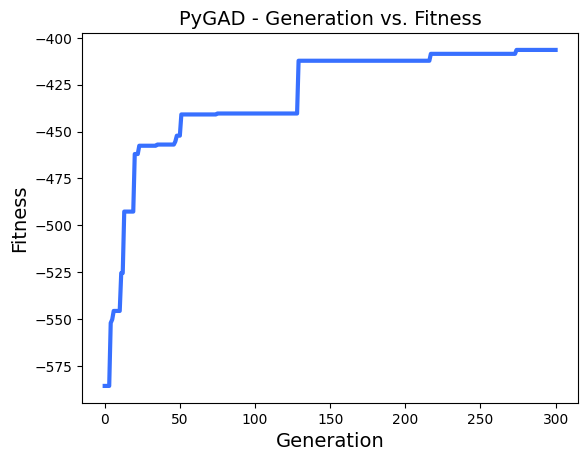

Parameters of best solution : [10.  0.  8. 12. 14. 13.  7.  1.  5.  3. 11.  2.  6.  4.  9.]
Fitness of the best solution = -344.5680774507551


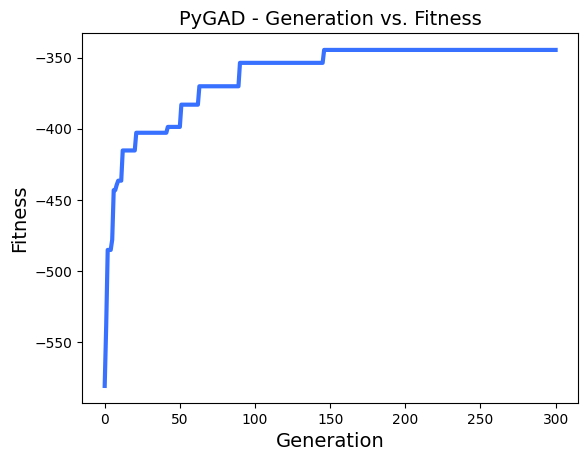

Parameters of best solution : [ 4.  6.  2. 11.  3.  5.  1.  7. 13. 14. 10. 12.  8.  0.  9.]
Fitness of the best solution = -333.90500852767343


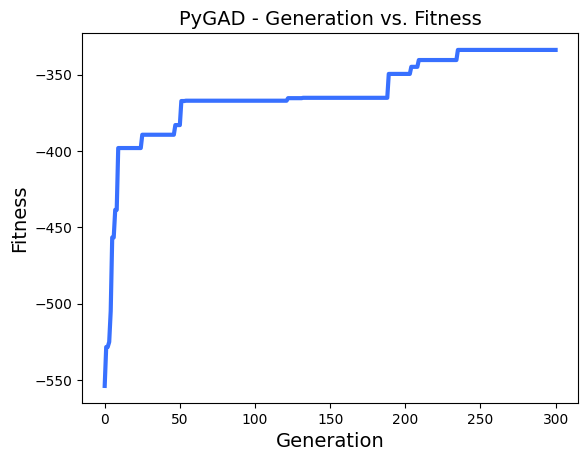

Parameters of best solution : [ 0.  8. 14.  7. 13.  6.  5. 10. 12.  2.  9.  1.  4.  3. 11.]
Fitness of the best solution = -428.1434896852145


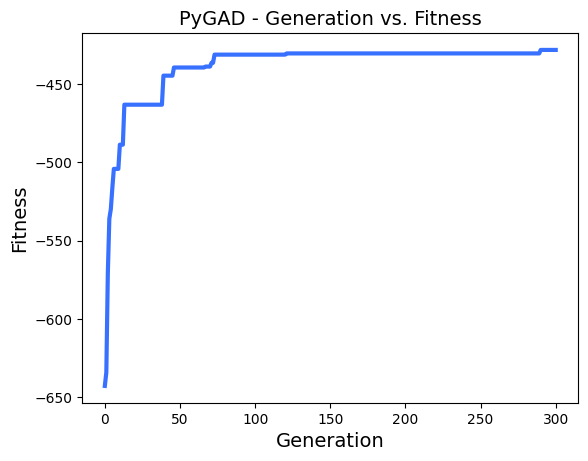

Parameters of best solution : [ 9.  0.  8. 12. 10. 13. 14.  7.  1.  5.  3. 11.  2.  6.  4.]
Fitness of the best solution = -334.1323842218516


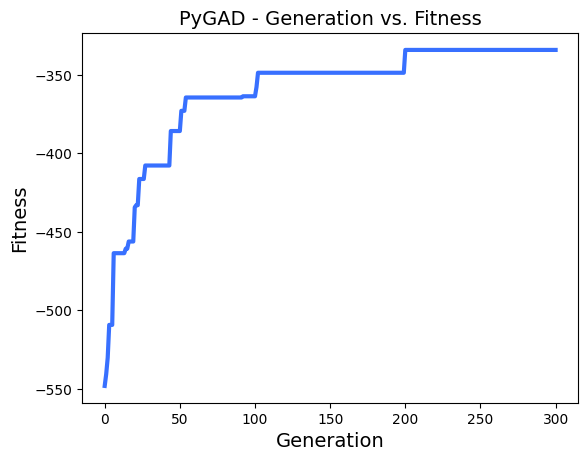

Parameters of best solution : [ 0.  8. 14. 11. 10.  5.  6. 13.  7. 12.  2.  9.  1.  4.  3.]
Fitness of the best solution = -406.42706022053073


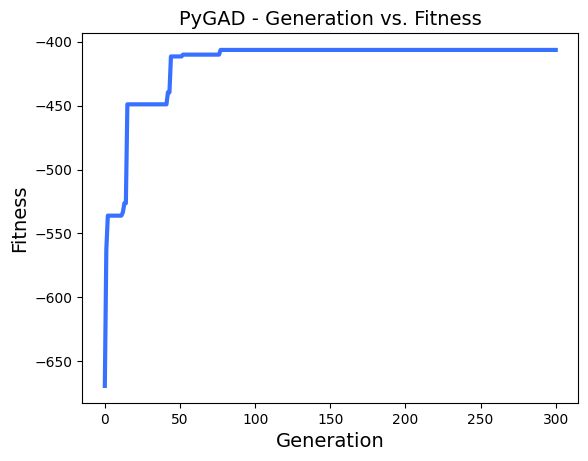

Parameters of best solution : [10.  0.  8. 12.  9.  4.  6.  2. 11.  3.  5.  1.  7. 13. 14.]
Fitness of the best solution = -342.1986398527075


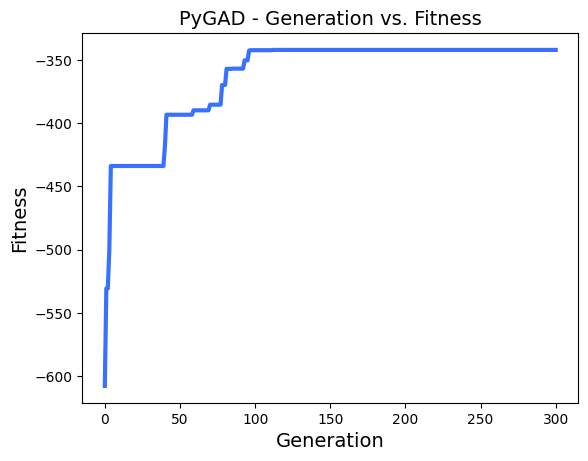

Parameters of best solution : [11.  4. 10. 12.  2.  0.  6.  5.  3.  1.  9.  8. 13. 14.  7.]
Fitness of the best solution = -336.5922388677279


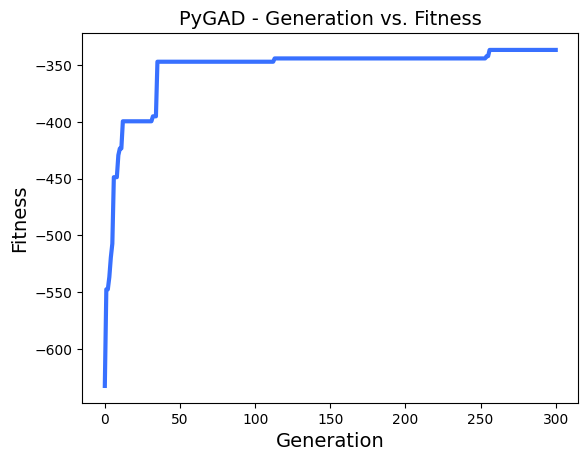

Parameters of best solution : [ 5.  3. 11.  2.  6.  4.  9.  0.  8. 12. 10. 14. 13.  7.  1.]
Fitness of the best solution = -333.90500852767343


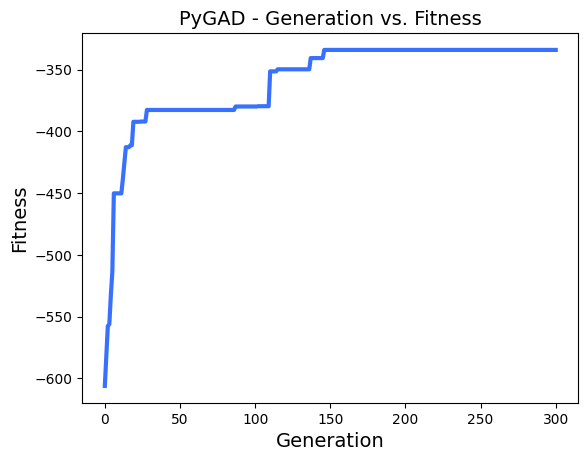

Parameters of best solution : [ 2.  9.  3.  1.  4.  0.  8. 14. 11. 10. 12.  5.  6. 13.  7.]
Fitness of the best solution = -427.3635277704057


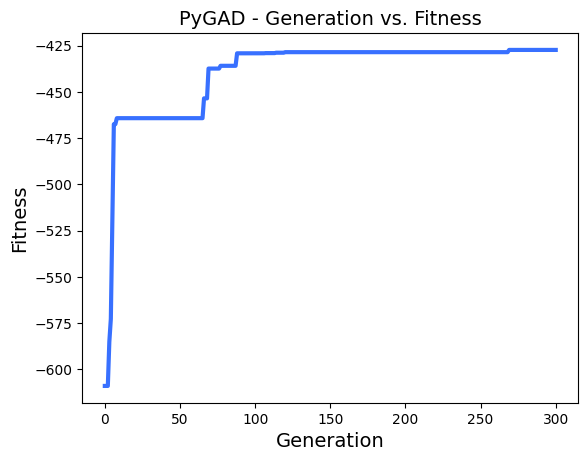

Parameters of best solution : [10. 12. 11.  7. 14. 13.  8.  2.  9.  1.  6.  3.  5.  0.  4.]
Fitness of the best solution = -314.2825130906289


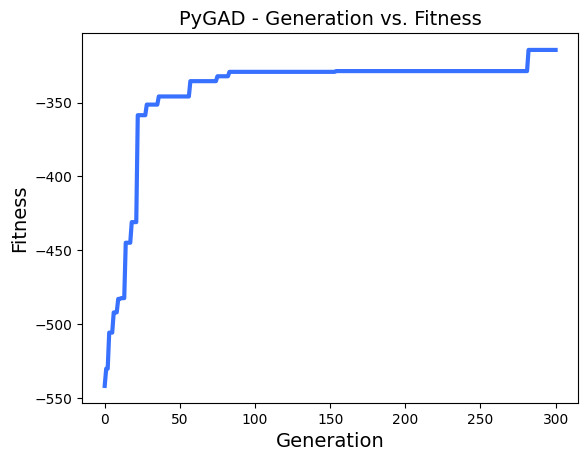

Parameters of best solution : [ 6.  3.  5.  0. 10.  4. 12. 11.  7. 14. 13.  8.  2.  9.  1.]
Fitness of the best solution = -311.12601870457956


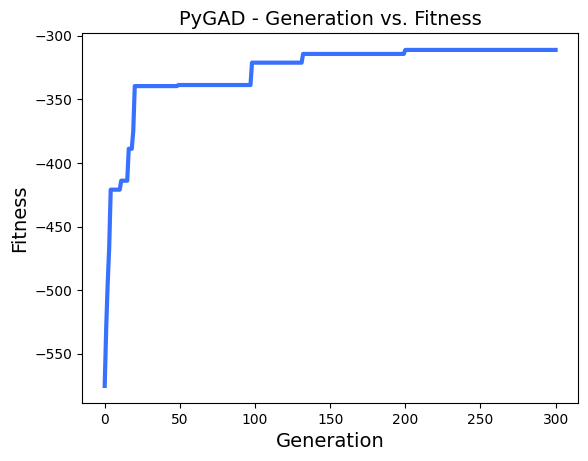

Parameters of best solution : [ 3.  1.  7. 13. 14. 10. 12.  0.  8.  9.  4.  6.  2. 11.  5.]
Fitness of the best solution = -355.0734813807305


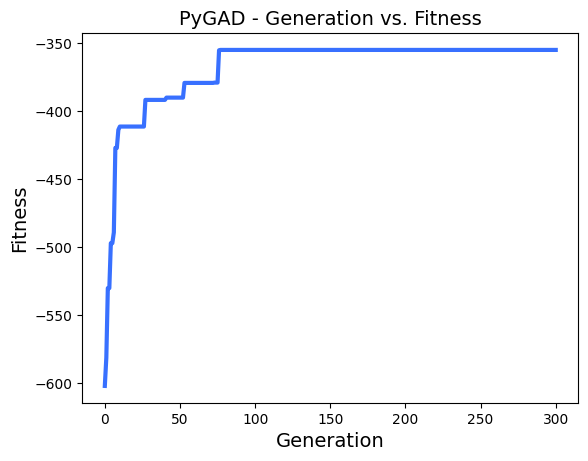

Parameters of best solution : [13. 14.  7.  1.  5.  3. 11.  2.  6.  4.  9.  8.  0. 12. 10.]
Fitness of the best solution = -340.75533507836883


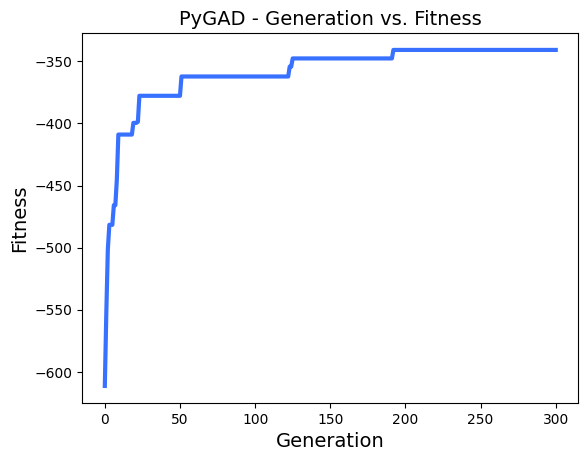

Parameters of best solution : [ 6.  1.  9.  2. 13.  8. 14.  7. 11. 12.  4. 10.  0.  3.  5.]
Fitness of the best solution = -316.7468158633691


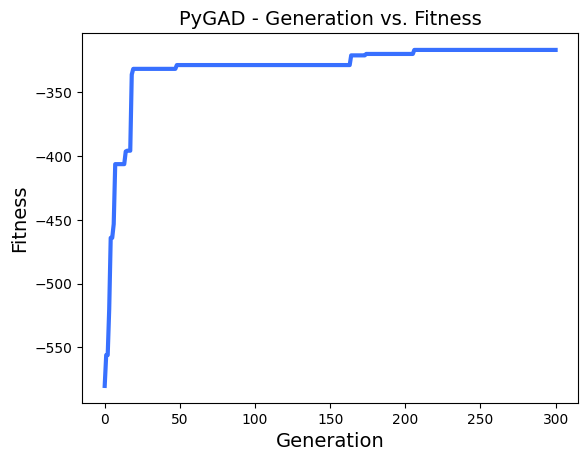

Parameters of best solution : [ 8.  0.  1.  4.  3. 11.  9.  2.  7. 13.  5.  6. 12. 10. 14.]
Fitness of the best solution = -422.5582980907324


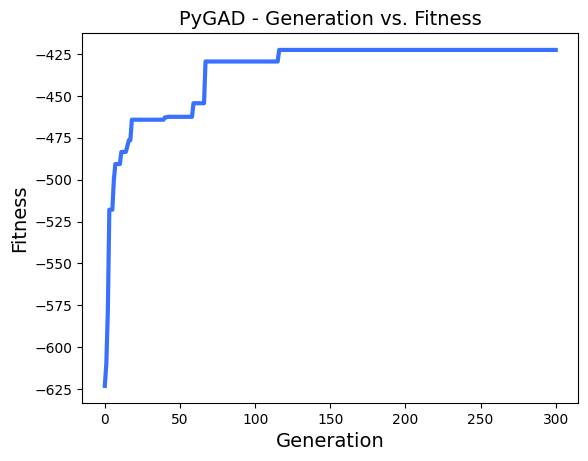

Parameters of best solution : [ 0. 12. 10. 13. 14.  7.  9.  1.  5. 11.  3.  2.  6.  4.  8.]
Fitness of the best solution = -361.46660423398805


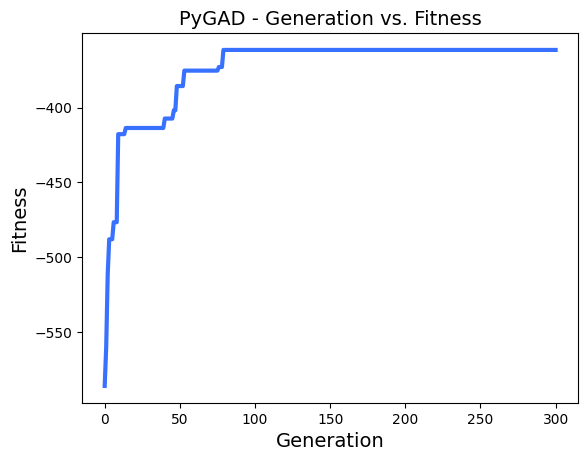

Parameters of best solution : [11. 12.  4. 10.  5.  3.  6.  1.  9.  0.  2.  8. 13. 14.  7.]
Fitness of the best solution = -328.29627889323115


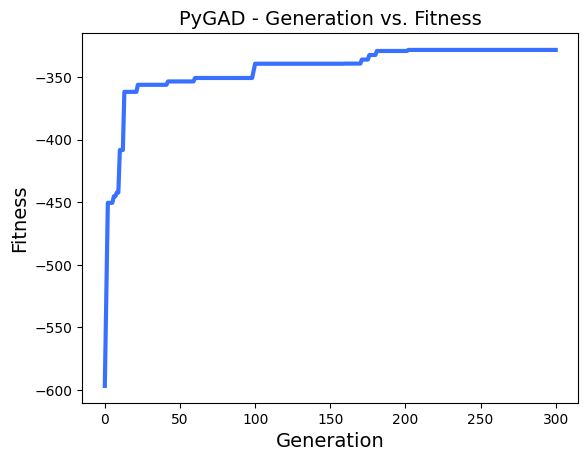

Parameters of best solution : [ 6.  1.  9.  0. 10.  4. 12. 11.  7. 14. 13.  8.  2.  3.  5.]
Fitness of the best solution = -329.6770324826412


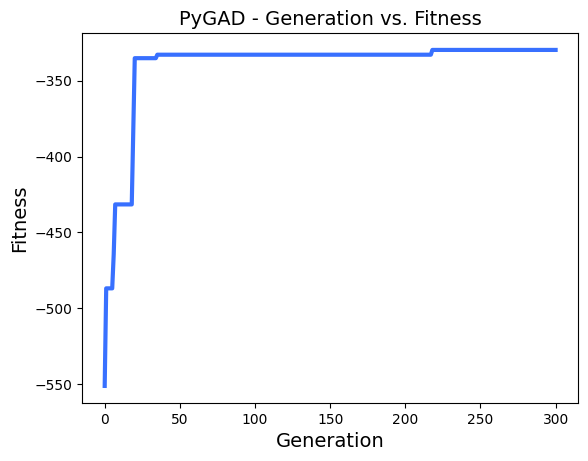

Parameters of best solution : [11.  2.  6.  4.  9.  0.  8. 12. 10. 14. 13.  7.  1.  5.  3.]
Fitness of the best solution = -333.90500852767343


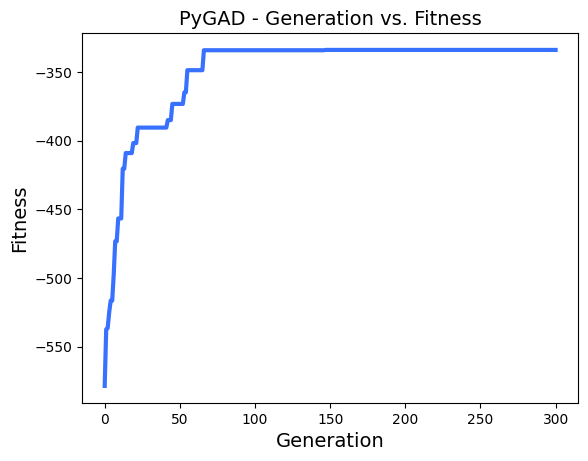

Parameters of best solution : [ 3.  6.  5.  0. 10.  4. 12. 11.  7. 14. 13.  8.  2.  9.  1.]
Fitness of the best solution = -314.11258927515587


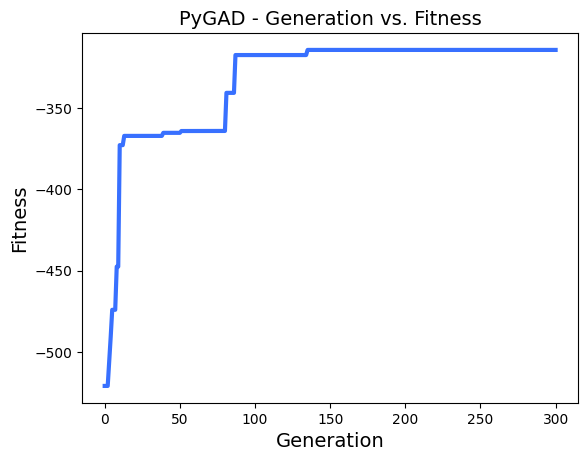

Parameters of best solution : [ 3.  5.  6.  1.  9.  8. 13. 14.  7. 10.  4. 12. 11.  2.  0.]
Fitness of the best solution = -338.4009795634739


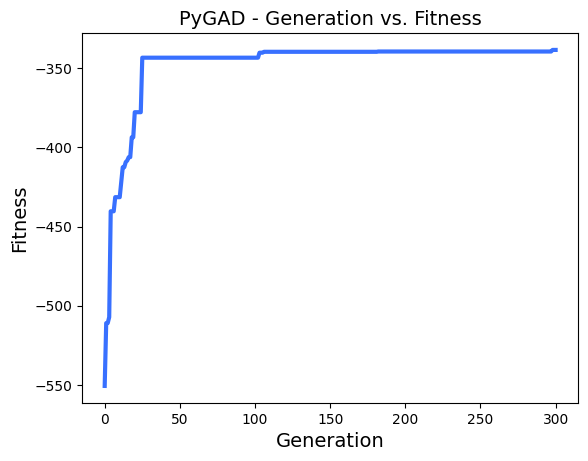

Parameters of best solution : [ 7.  1.  5.  3. 11.  2.  6.  4.  9.  0.  8. 12. 10. 14. 13.]
Fitness of the best solution = -333.90500852767343


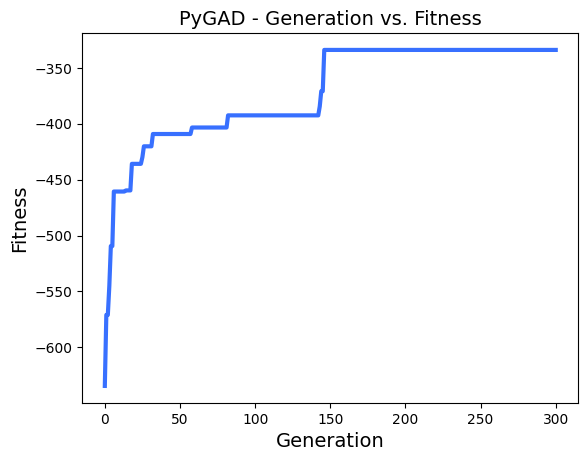

Parameters of best solution : [ 0.  8. 14. 11. 10.  5.  6.  7. 13. 12.  2.  9.  1.  4.  3.]
Fitness of the best solution = -407.1973142196921


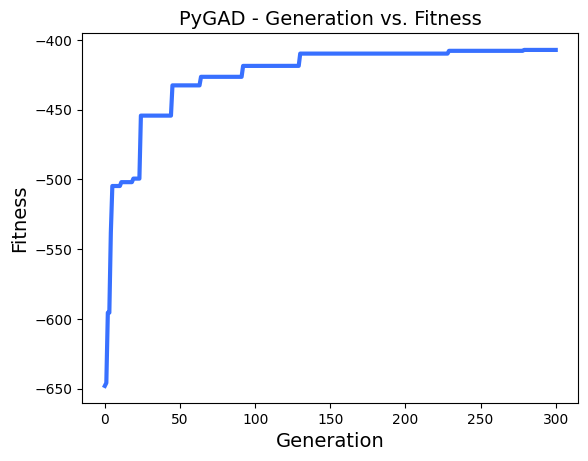

Parameters of best solution : [ 0.  1.  4.  3. 11.  9.  2.  7. 13.  6.  5. 12. 10. 14.  8.]
Fitness of the best solution = -421.35031584568054


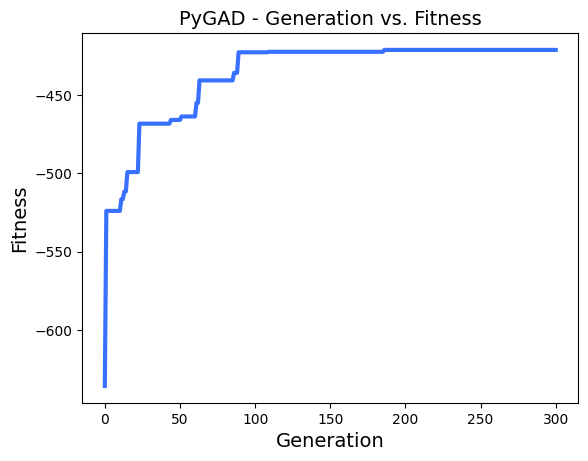

Parameters of best solution : [ 9.  2.  7. 13.  6.  5. 14.  8.  0.  1.  4.  3. 11. 10. 12.]
Fitness of the best solution = -408.4282982858038


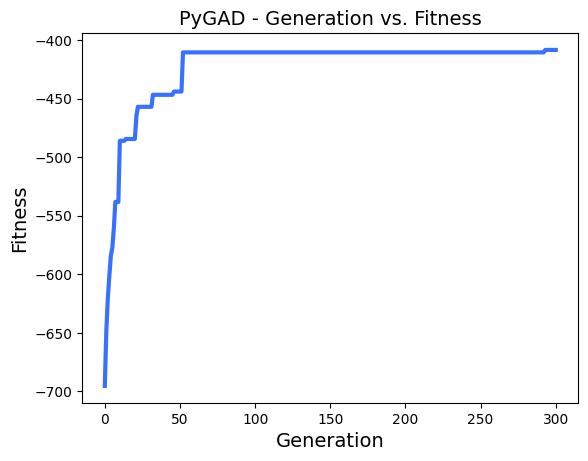

Parameters of best solution : [12.  9.  4.  6.  2. 11.  3.  5.  1.  7. 13. 14. 10.  0.  8.]
Fitness of the best solution = -342.19863985270746


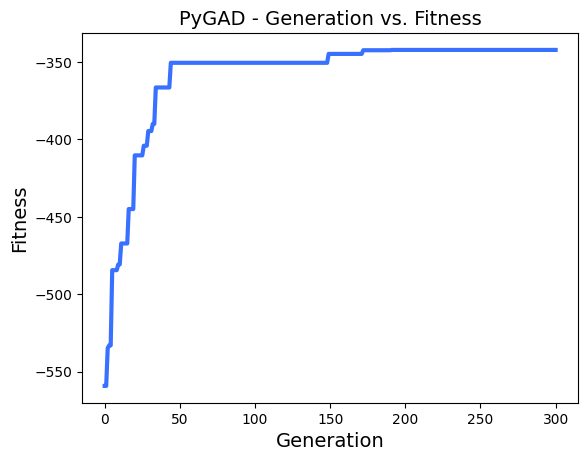

Parameters of best solution : [ 2.  8. 13. 14.  7. 11. 12.  4. 10.  0.  3.  5.  6.  1.  9.]
Fitness of the best solution = -310.0074862775921


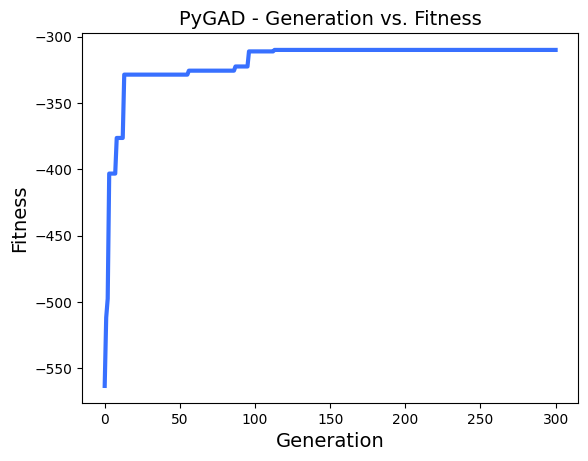

In [107]:
effectivness_graph,counters, mean_time, all_results = effectiveness_genetic(graphs_large)

In [112]:
large_results.append(counters)
large_results.append(mean_time)

In [113]:
large_results

[26, 3.5451749838315525]

In [114]:
#effectivness table for each of large graphs
df_large = {
  "Graph": [1, 2, 3],
  "Time": [effectivness_graph[0][2], effectivness_graph[1][2], effectivness_graph[2][2]],
    "Effectivness(%)" : [round((effectivness_graph[0][0]/effectivness_graph[0][1])*100,2), round((effectivness_graph[1][0]/effectivness_graph[1][1])*100,2),round((effectivness_graph[2][0]/effectivness_graph[2][1])*100,2)]}

table_large = pd.DataFrame(df_large)
table_large

Graph      Time  Effectivness(%)
0      1  3.603819            13.33
1      2  3.631696            38.46
2      3  3.326263            22.58

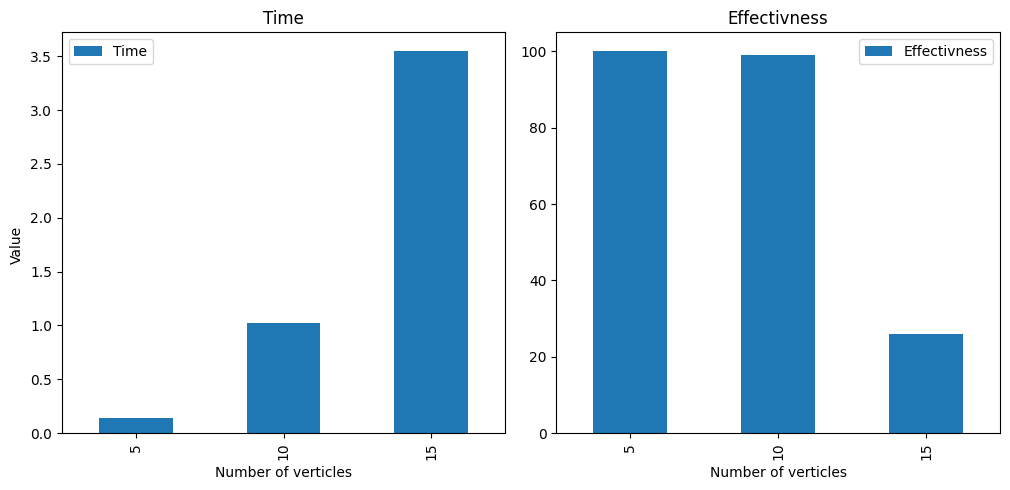

In [115]:
genetic_results = {
  "Number of verticles": [5, 10, 15],
  "Time": [small_results[1], medium_results[1], large_results[1]],
    "Effectivness" : [small_results[0], medium_results[0], large_results[0]]
    
}

genetic_results = pd.DataFrame(genetic_results)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

genetic_results.plot.bar(x='Number of verticles', y='Time', ax=ax[0])
ax[0].set_title('Time')

genetic_results.plot.bar(x='Number of verticles', y='Effectivness', ax=ax[1])
ax[1].set_title('Effectivness')

fig.text(0.002, 0.5, 'Value', ha='center', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

In [116]:
genetic_results

Number of verticles      Time  Effectivness
0                    5  0.141230           100
1                   10  1.019041            99
2                   15  3.545175            26

As can be seen from above, for graphs with 5 and 10 verticles genetic algorithm has a similar effectivness, but for graph with 15 verticles it seems that my algorithm has a trouble with finding solutions declared earlier as optimal. When it comes to computational complexity the algorithm finds solutions much faster for smaller instances of TSP problem. 

### 2.2 Extra experiment with another algorithm.

Ant Colony Optimization (ACO) is an optimization algorithm used to find the shortest path between points. It is based on behavior of ants when they follow a path to their food source. Ants are essentially blind so they follow pheromone trails left behind by other ants on the path. This algorithm follows the same approach by using the probability of going to the next node as the distance to the node and the amount of pheromones.

#### Auxiliary functions.

The functions from aco 0.2.3 package needed to be fixed so that ants from previous colony are not remembered for algorithm. Without that change new colonies created for different coordinates tend to return the solution from previous one.

In [117]:
import math
import random

from threading import Thread


class Ant(Thread):
    def __init__(
        self,
        nodes,
        pheromoneMap,
        tmpPheromoneMap,
        first_pass,
        start,
        distance_callback,
        alpha,
        beta,
        pheromone_constant,
        pheromone_evaporation_rate,
        agent_index,
    ):
        Thread.__init__(self)
        self.nodes = nodes
        self.pheromoneMap = pheromoneMap
        self.tmpPheromoneMap = tmpPheromoneMap
        self.alpha = alpha
        self.beta = beta
        self.pheromone_constant = pheromone_constant
        self.pheromone_evaporation_rate = pheromone_evaporation_rate
        self.initialNode = start
        self.agent_index = agent_index
        self.distance = distance_callback

        self.first_pass = first_pass

    def run(self):
        self.trip = [self.initialNode]
        self.trip_distance = 0
        self.currentNode = self.initialNode

        while True:
            next_path = self.choose_next()


            if next_path[0] == self.currentNode:
                self.currentNode = next_path[1]
            else:
                self.currentNode = next_path[0]

            self.trip.append(self.currentNode)
            self.trip_distance += self.distance(next_path)


            # trip completion condition
            if self.trip[0] == self.trip[-1]:
                if len(self.trip) != 1:
                    self.pheromone_update()
                    return

    def choose_next(self):

        possible_nodes = []
        weightage_array = []

        most_probable = ((), 0)

        for path in self.pheromoneMap:

            if self.currentNode not in path:
                continue

            if path[0] == self.currentNode:
                next_node = path[1]
            else:
                next_node = path[0]

            if next_node in self.trip:
                if next_node == self.initialNode:
                    if len(self.trip) == len(self.nodes):
                        possible_nodes.append(path)

                continue

            possible_nodes.append(path)

        # 50% probablity on first pass
        if self.first_pass:
            choice = random.choice(possible_nodes)
            return choice

        for path in possible_nodes:
            path_distance = self.distance(path)
            # pheromone = self.pheromoneMap[path]
            pheromone = self.pheromone_constant / path_distance

            # calculate weightage of path
            weightage = (pheromone**self.alpha) * ((1 / path_distance) ** self.beta)

            weightage_array.append(weightage)

        weightage_sum = sum(weightage_array)

        for i in range(len(possible_nodes)):
            path = possible_nodes[i]
            weightage = weightage_array[i]

            p = weightage / weightage_sum

            if p > most_probable[1]:
                most_probable = (path, p)

        return most_probable[0]

    def pheromone_update(self):
        for i in range(len(self.trip) - 1):
            path = (self.trip[i], self.trip[i + 1])

            if path not in self.pheromoneMap:
                path = path[::-1]

            self.tmpPheromoneMap[path] = (
                1 - self.pheromone_evaporation_rate
            ) * self.tmpPheromoneMap[path]

            self.tmpPheromoneMap[path] += self.pheromone_constant / self.trip_distance


class AntColony:
   

    def __init__(
        self,
        nodes,
        start=None,
        ant_count=300,
        alpha=0.5,
        beta=1.2,
        pheromone_evaporation_rate=0.40,
        pheromone_constant=1000.0,
        iterations=300,
    ):
        self.antArray = []
        self.pheromoneMap = {}
        self.tmpPheromoneMap = {}
        #print(len(self.antArray))
       
        self.nodes = nodes
        self.pheromone_evaporation_rate = pheromone_evaporation_rate
        self.pheromone_constant = pheromone_constant
        self.iterations = iterations
        self.alpha = alpha
        self.beta = beta
        self.first_pass = True
        self.ant_count = ant_count

        self.bestSeenPath = []
        self.bestDistance = math.inf

        self.distanceArray = []

        if start:
            self.start = start
        else:
            self.start = random.choice(nodes)

        # Initialize Pheromone map
        self.init_pheromone_map()

        for iter in range(self.iterations):

            # Create all ants
            for i in range(self.ant_count):
                ant = self.init_ant(i)
                self.antArray.append(ant)
                ant.start()

            for ant in self.antArray:
                ant.join()
                if ant.trip_distance < self.bestDistance:
                    self.bestDistance = ant.trip_distance
                    self.bestSeenPath = ant.trip
                self.antArray.remove(ant)
            

            for path in self.pheromoneMap:

                self.pheromoneMap[path] += self.tmpPheromoneMap[path]
                self.tmpPheromoneMap[path] = 0


    def init_ant(self, agent_index):
        return Ant(
            self.nodes,
            self.pheromoneMap,
            self.tmpPheromoneMap,
            self.first_pass,
            self.start,
            self.distance,
            self.alpha,
            self.beta,
            self.pheromone_constant,
            self.pheromone_evaporation_rate,
            agent_index,
        )

    def distance(self, path):
        (c1, c2) = path
        dx = c1[0] - c2[0]
        dy = c1[1] - c2[1]
        dist = math.sqrt(dx**2 + dy**2)
        return dist

    def init_pheromone_map(self):
        all_paths = []
        for i in self.nodes:
            for j in self.nodes:
                if i is j:
                    continue
                elif ((i, j) in all_paths) or ((j, i) in all_paths):
                    continue

                all_paths.append((i, j))

                self.pheromoneMap[(i, j)] = 0
                self.tmpPheromoneMap[(i, j)] = 0

    def get_path(self):
        print(self.bestDistance)
        return self.bestSeenPath

In [154]:
def perform_aco(graph):
    """
    Given coordinates of graph this function performs ACO algorithm with parameters adjusted to size of graph.
    
    Inputs
    ------
    graph: list of tuples
        here we represent graph as coordinates

    Returns
    -------
    distance: float
        the shortest distance found by algorithm
    aco_time: float
        time of algorithm
    best_path: list of tuples
        best found path represented by coordinates visited in order
        
    """
    alpha = 0.7
    beta = 1.2
    pheromone_evaporation_rate = 0.40
    pheromone_constant = 200.0
    
    if len(graph) == 5:
        ant_count = 100
        iterations = 50
        
    elif len(graph) == 10:
        alpha = 0.7
        beta = 1.5
        ant_count = 200
        iterations = 300
        
    elif len(graph) == 15:
        alpha = 1.3
        beta = 2.1
        ant_count = 300
        iterations = 400
        pheromone_constant = 800.0
        
    else:
        print("Not valid length of coords.")

    start = time.time() 
    colony = AntColony(graph, ant_count=ant_count, alpha=alpha, beta=beta, 
                       pheromone_evaporation_rate=pheromone_evaporation_rate, pheromone_constant=pheromone_constant,
                       iterations=iterations)
    
    best_path = colony.bestSeenPath
    distance = colony.bestDistance
    end = time.time()
    aco_time = end - start
    
    return distance,best_path, aco_time

In [119]:
def draw_path_aco(path):
    """
    Given solution found by ACO algorithm this function draws the path on plot.
    
    Inputs
    ------
    path: list of tuples
        order in which the coordinates were visited
  
    """
    x = []
    y = []
    for c in path:
        x.append(c[0])
        y.append(c[1])

    plt.plot(x, y, '-o')
    plt.title("Best path found by ACO algorithm: ")
    plt.ylabel("$y$")
    plt.xlabel("$x$")
    plt.show()

In [120]:
def effectiveness_aco(graphs):
    """
    Given list of three graphs this function performs genetic algorithm 100 times and each time it chooses randomly one graph
    then it calculates the mean time of best solutions in each chosen graph separatly and in all graphs together.
    
    Inputs
    ------
    graphs: list of lists
       list of three lists where each list represent one graph wich is also represented as list of lists

    Returns
    -------
    effectivness_graph: list of tuples
     tuple as (counters,len(results),mean_time), it represents effectivness for each example seperatly
    counters: int
        number of best solutions in all examples together
    sum_times/counters:
        mean time of best solutions in all examples together
    """
    results = [[],[],[]] #there will be resuls for each example of graphs
    coords = None
    for i in range(100):
        index = random.randint(0,2) 
        coords = graphs[index] 
        distance,best_path, my_time = perform_aco(coords)
        results[index].append(((-1)*distance,my_time))
    
    effectivness_graph = [] #effectiveness seperatly in each graph
    counters = 0
    sum_times = 0
    index_graphs = 0 
    if len(graphs[0]) == 10: #if it is one of medium graphs
        index_graphs = 1
    elif len(graphs[0]) == 15: #if it is one of large graphs
        index_graphs = 2
    for i in range(len(results)):
        counter, sum_time, mean_time = get_counter_sum_time(results[i], best_results[index_graphs][i]) 
        counters += counter #counts how many times graphs achieved its best fitness
        sum_times += sum_time #counts time of finding that solutions with best fitnesses for specyfic graph
        effectivness_graph.append((counter,len(results[i]),mean_time))
        
    if counters == 0:
        print("No solution with fitness value declared as the optimal have appeard.")
        return effectivness_graph, 0, 0, results
    else:
        return effectivness_graph,counters, sum_times/counters, results

#### 2.2.1 Small inputs.

- first small input

In [121]:
COORDS = ((70, 19), (58, 15), (5, 18), (25, 65), (61, 77))

In [122]:
graphs_small = [] #list of small graphs for aco
graphs_small.append(COORDS)

In [123]:
distance, best_path,aco_time = perform_aco(COORDS)

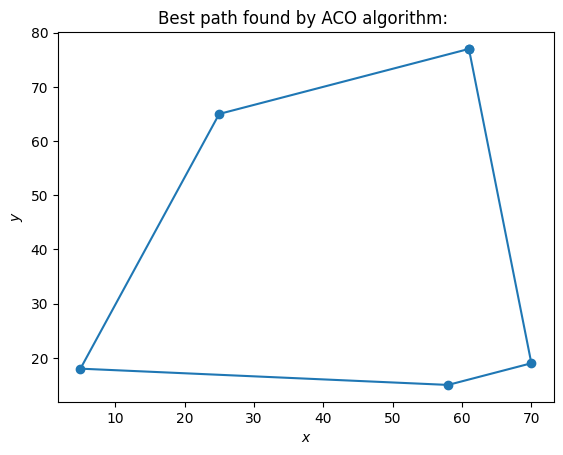

In [124]:
draw_path_aco(best_path)

- second small input

In [125]:
COORDS = ((34, 20), (52, 41), (79, 15), (40, 61), (53, 33))

In [126]:
graphs_small.append(COORDS)

In [127]:
distance, best_path,aco_time = perform_aco(COORDS)

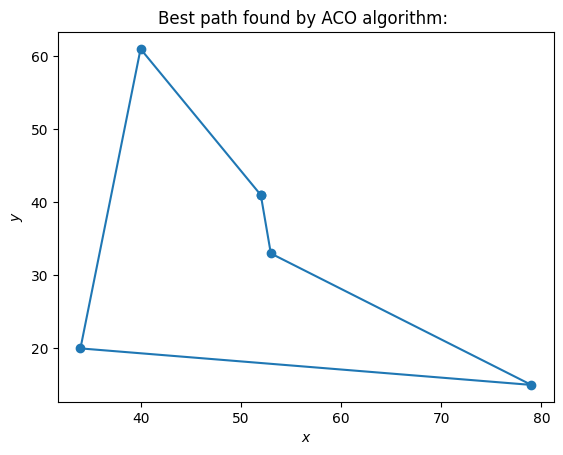

In [128]:
draw_path_aco(best_path)

- third small graph

In [129]:
COORDS = ((5, 24), (74, 85), (99, 84), (6, 49), (56, 19))

In [130]:
graphs_small.append(COORDS)

In [131]:
distance, best_path,aco_time = perform_aco(COORDS)

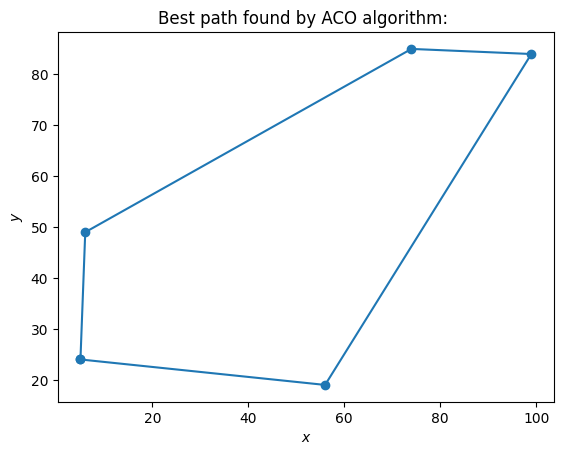

In [132]:
draw_path_aco(best_path)

#### Effectivness for small graphs:

In [133]:
effectivness_graph,counters, mean_time, all_results = effectiveness_aco(graphs_small)

In [134]:
small_results = []
small_results.append(counters)
small_results.append(mean_time)

In [135]:
#effectivness table for each of small graphs
df_aco_small = {
  "Graph": [1, 2, 3],
  "Time": [effectivness_graph[0][2], effectivness_graph[1][2], effectivness_graph[2][2]],
    "Effectivness(%)" : [round((effectivness_graph[0][0]/effectivness_graph[0][1])*100,2), round((effectivness_graph[1][0]/effectivness_graph[1][1])*100,2),round((effectivness_graph[2][0]/effectivness_graph[2][1])*100,2)]}

table_aco_small = pd.DataFrame(df_aco_small)
table_aco_small

Graph      Time  Effectivness(%)
0      1  0.860474            100.0
1      2  0.850729            100.0
2      3  0.847292            100.0

#### 2.2.2 Medium inputs.

- first medium graph

In [136]:
COORDS = ((26, 87), (9, 93), (14, 14), (10, 68), (99, 38), (30, 72), (87, 7), (70, 47), (21, 80), (38, 90))

In [137]:
graphs_medium = [] #list of medium graphs
graphs_medium.append(COORDS)

In [140]:
distance, best_path,aco_time = perform_aco(COORDS)

In [141]:
distance

321.6398485576058

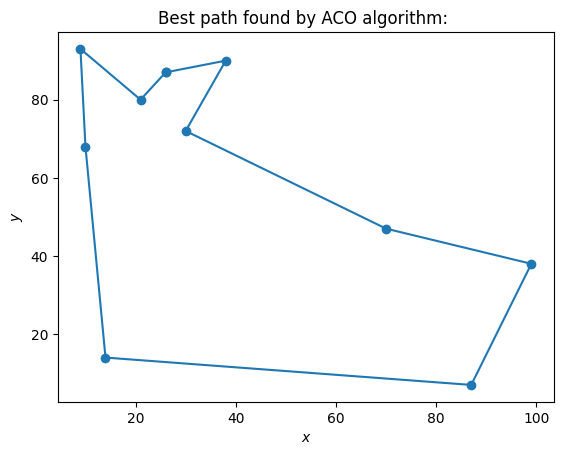

In [142]:
draw_path_aco(best_path)

- second medium graph

In [143]:
COORDS = ((79, 36), (90, 64), (53, 88), (20, 48), (35, 57), (4, 94), (100, 98), (23, 56), (30, 11), (35, 94))

In [144]:
graphs_medium.append(COORDS)

In [147]:
distance, best_path,aco_time = perform_aco(COORDS)

In [148]:
distance

325.74132709433985

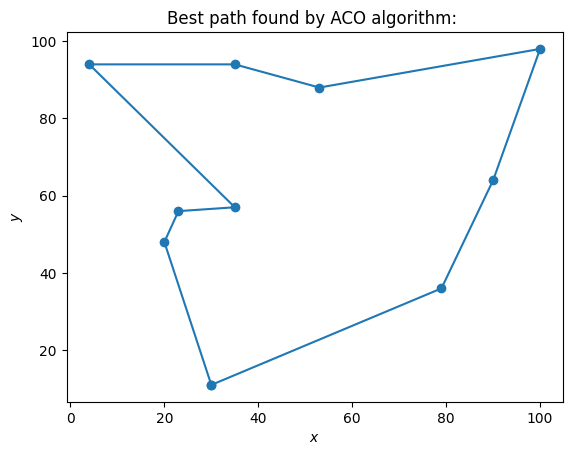

In [149]:
draw_path_aco(best_path)

- third medium graph

In [150]:
COORDS = ((20, 85), (14, 68), (3, 88), (15, 96), (92, 12), (100, 39), (88, 72), (80, 79), (61, 81), (48, 86))

In [151]:
graphs_medium.append(COORDS)

In [157]:
distance, best_path,aco_time = perform_aco(COORDS)

In [158]:
distance

280.30722069926134

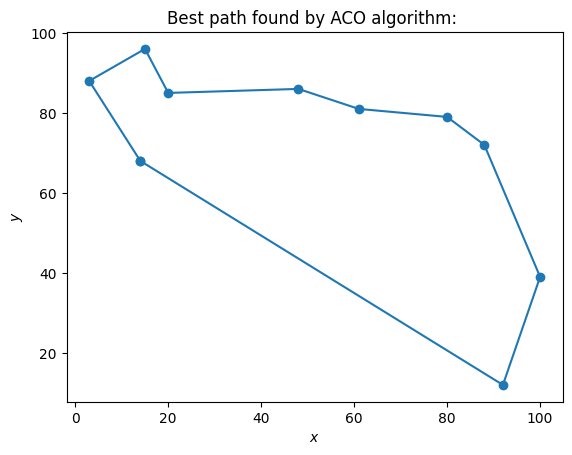

In [159]:
draw_path_aco(best_path)

#### Effectivness for medium graphs:

In [160]:
effectivness_graph,counters, mean_time, all_results = effectiveness_aco(graphs_medium)

In [162]:
medium_results = []
medium_results.append(counters)
medium_results.append(mean_time)

In [166]:
medium_results

[26, 15.466527021848238]

In [167]:
#effectivness table for each of large graphs
df_aco_medium = {
  "Graph": [1, 2, 3],
  "Time": [effectivness_graph[0][2], effectivness_graph[1][2], effectivness_graph[2][2]],
    "Effectivness(%)" : [round((effectivness_graph[0][0]/effectivness_graph[0][1])*100,2), round((effectivness_graph[1][0]/effectivness_graph[1][1])*100,2),round((effectivness_graph[2][0]/effectivness_graph[2][1])*100,2)]}

table_aco_medium = pd.DataFrame(df_aco_medium)
table_aco_medium

Graph       Time  Effectivness(%)
0      1  16.017633            33.33
1      2  15.304764            32.26
2      3  14.817622            15.38

#### 2.2.3 Large inputs.

- first large graph

In [168]:
COORDS = ((100, 37), (96, 97), (7, 72), (69, 63), (74, 68), (23, 12), (20, 19), (23, 36), (100, 7), (22, 97), (43, 39), (59, 47), (34, 46), (24, 35), (75, 19))

In [169]:
graphs_large = []
graphs_large.append(COORDS)

In [174]:
distance, best_path,aco_time = perform_aco(COORDS)

In [175]:
distance

494.83643352394495

In [176]:
aco_time

44.89227294921875

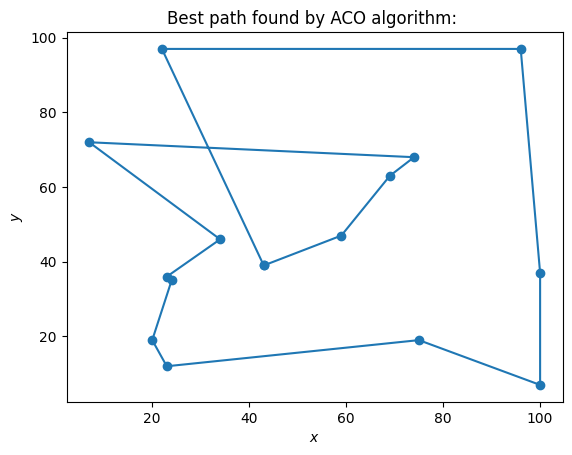

In [177]:
draw_path_aco(best_path)

- second large graph

In [178]:
COORDS = ((2, 83), (48, 26), (25, 3), (51, 7), (18, 29), (50, 18), (22, 9), (57, 63), (6, 95), (33, 45), (30, 77), (39, 7), (22, 81), (87, 98), (62, 80))

In [179]:
graphs_large.append(COORDS)

In [180]:
distance, best_path,aco_time = perform_aco(COORDS)

In [181]:
distance

402.39362661348804

In [182]:
aco_time

45.004199743270874

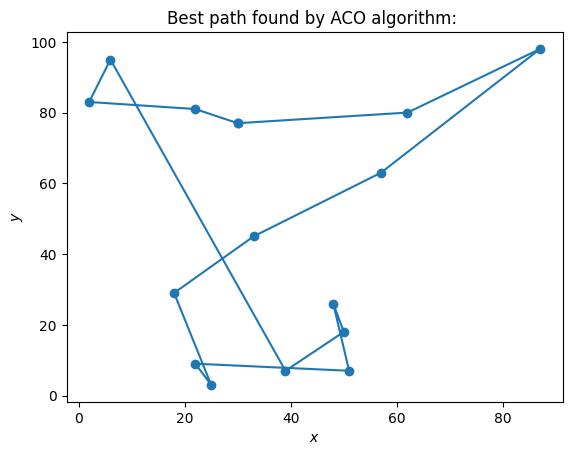

In [183]:
draw_path_aco(best_path)

- third large graph

In [184]:
COORDS = ((62, 46), (83, 22), (43, 33), (94, 39), (21, 76), (99, 43), (97, 35), (6, 49), (15, 27), (70, 11), (18, 96), (12, 52), (17, 69), (7, 19), (1, 42))

In [185]:
graphs_large.append(COORDS)

In [186]:
distance, best_path, aco_time = perform_aco(COORDS)

In [187]:
distance

437.4670969669797

In [188]:
aco_time

44.58440351486206

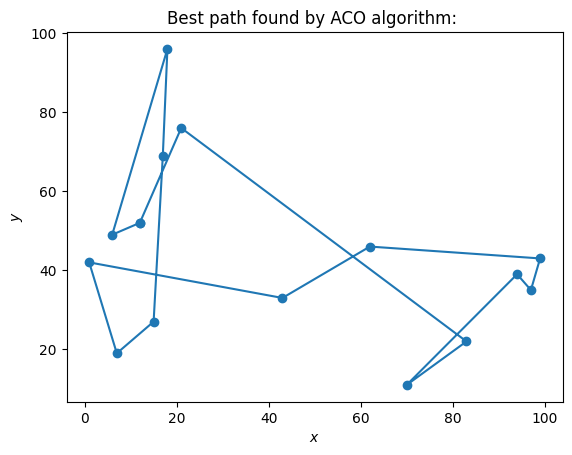

In [189]:
draw_path_aco(best_path)

Unfourtunatelly I didn't manage to find optimal solution of TSP problem using ACO algorithm for large graphs in reasonable time. Maybe it could be posiible after making much more iterations and giving more ants which significantly increases the computational complexity of the algorithm. After many tests with different number of iterations I still couldn't get results close to those achieved by genetic algorithm. I didn't check the effectivness of large graphs for ACO algorithm as it would take too much time assuming from time needed for solving TSP for medium graphs.

#### Effectivness and for small and medium results in ACO

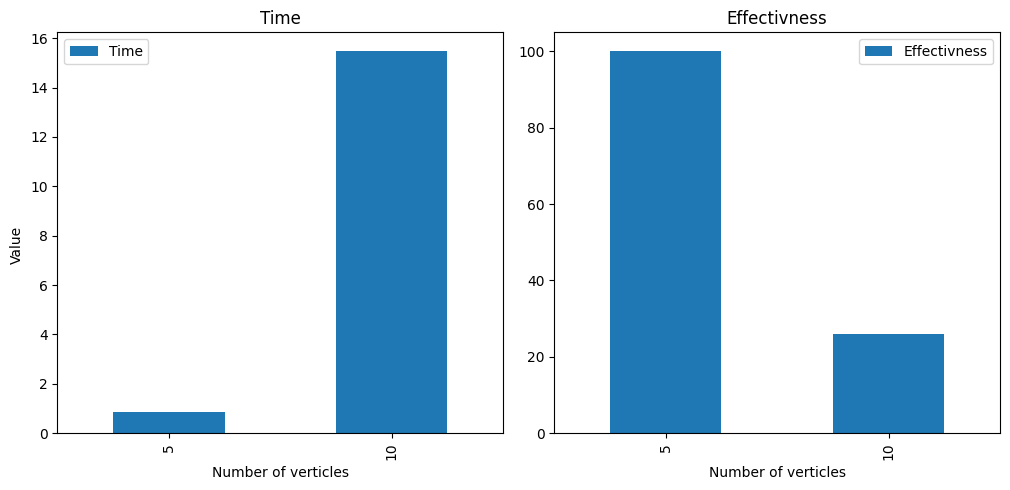

In [190]:
aco_results = {
  "Number of verticles": [5, 10], 
  "Time": [small_results[1], medium_results[1]],
    "Effectivness" : [small_results[0], medium_results[0]]
    
}

#Difficulty as number of verticles in graph(5,10)

aco_results = pd.DataFrame(aco_results)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

aco_results.plot.bar(x='Number of verticles', y='Time', ax=ax[0])
ax[0].set_title('Time')

aco_results.plot.bar(x='Number of verticles', y='Effectivness', ax=ax[1])
ax[1].set_title('Effectivness')

fig.text(0.002, 0.5, 'Value', ha='center', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

In [191]:
aco_results

Number of verticles       Time  Effectivness
0                    5   0.851934           100
1                   10  15.466527            26

As can be seen from plots above for graphs with 5 verticles ACO effectivness is perfect but it takes more time than in genetic algorithm to find that solution. As the number of verticles in graph increases the effectivness is much worse.

### 2.3 Comparison of two models.

After many test that I have made I consider genetic algorithm as a better from ACO algorithm. Both algorithms have high effectivness for small graphs but ACO algorithm definitely works much longer. When it comes to solving medium graphs genetic algorithm performs much better and for large graphs ACO couldn't get close to solutions achieved by genetic algorithm.

## 3. Summary.

In summary, genetic algorithms are generally better for solving optimization problems, but they also have disadvantages such as lower effectivness for bigger problems. However, the choice of algorithm depends on the specific problem being solved and the available computational resources.

## 4. Bibliography

https://en.wikipedia.org/wiki/NP-hardness

https://en.wikipedia.org/wiki/Travelling_salesman_problem